In [1]:
from utils_1551 import Corpus, load_train_and_test, text2tokens

from bpemb import BPEmb
from uk_stopwords import STOP_WORDS
from typing import List, Dict
import numpy as np
import random

In [2]:
train, test = load_train_and_test()

In [3]:
dim = 300
bpemb_ua = BPEmb(lang="uk", dim=dim)

In [4]:
print(bpemb_ua.embed('щось там').shape)
print(bpemb_ua.encode('щось там'))

(3, 300)
['▁що', 'сь', '▁там']


In [5]:
s = "Ваша відповідь:  Повідомляємо, що відповідно до п. 5.7 Державного стандарту України 4123-2006 «Пристрій примусового зниження швидкості дорожньо-транспортної техніки на вулицях і дорогах. Загальні технічні вимоги» заборонено встановлювати пристрої примусового зниження швидкості руху транспортних засобів на магістральних вулицях, а просп. Григоренка має категорію магістральної вулиці районного значення."
print(text2tokens(s))

['Ваша', 'відповідь', 'Повідомляємо', 'що', 'відповідно', 'до', 'п', '5', '7', 'Державного', 'стандарту', 'України', '4123', '2006', 'Пристрій', 'примусового', 'зниження', 'швидкості', 'дорожньо', 'транспортної', 'техніки', 'на', 'вулицях', 'і', 'дорогах', 'Загальні', 'технічні', 'вимоги', 'заборонено', 'встановлювати', 'пристрої', 'примусового', 'зниження', 'швидкості', 'руху', 'транспортних', 'засобів', 'на', 'магістральних', 'вулицях', 'а', 'просп', 'Григоренка', 'має', 'категорію', 'магістральної', 'вулиці', 'районного', 'значення']


In [6]:
def text2vec(text: str):
    res = np.zeros(dim)
    words = text2tokens(text.lower())
    for w in words:
        if w in STOP_WORDS:
            continue
        for v in bpemb_ua.embed(w):
            res += v
    res /= max(np.linalg.norm(res), 1e-6)
    return res

print(text2vec(s).shape)

(300,)


In [7]:
def corpus2xy(corpus: Corpus)->(np.array, np.array):
    x, y = [], []
    for name, messages in corpus.items():
        for id_, text in messages:
            vec = text2vec(text)
            x.append(vec)
            y.append(name)
    return np.array(x), np.array(y)

def extract_labels(corpus: Corpus)->Dict[str, int]:
    res = {name:i for i, name in enumerate(corpus.keys())}
    return res

labels_dict = extract_labels(train)
def labels_to_ind(y: np.array)->np.array:
    return np.array([labels_dict[name] for name in y])

def shuffle_xy(x: np.array, y:np.array)->(np.array, np.array):
    assert len(x) == len(y)
    p = np.random.permutation(len(x))
    return x[p], y[p]

In [8]:
x_train, y_train = corpus2xy(train)

#print(x_train[:3])
print(y_train[:3])

['Інші-Подяки' 'Інші-Подяки' 'Інші-Подяки']


In [9]:
x_train, y_train = shuffle_xy(x_train, y_train)
#print(x_train[:3])
print(y_train[:3])

['Відсутність-ГВП'
 'Перевірка-наявності-дозволів-на-виконання-будівельних-робіт'
 'Відсутність-освітлення-на-опорних-стовпах-за-відсутності-несправності-лампочок']


In [10]:
y_train_idx = labels_to_ind(y_train)

In [11]:
print(x_train.shape, x_train.dtype)
print(y_train_idx.shape, y_train_idx.dtype)

(48120, 300) float64
(48120,) int32


In [12]:
x_test, y_test = corpus2xy(test)
y_test_idx = labels_to_ind(y_test)

In [18]:
print(x_test.shape, x_test.dtype)
print(y_test_idx.shape, y_test_idx.dtype)

(16147, 300) float64
(16147,) int32


In [196]:
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [225]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10060599704802565441
]


In [204]:
early_stopping=EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)

In [205]:
one_hot_train_labels = to_categorical(y_train_idx) 
one_hot_test_labels = to_categorical(y_test_idx)

x_val = x_train[:8000]
partial_x_train = x_train[8000:]
y_val = one_hot_train_labels[:8000]
partial_y_train = one_hot_train_labels[8000:]

In [206]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(dim,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(labels_dict), activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [207]:
history = model.fit(
            partial_x_train,
            partial_y_train,
            epochs=100,
            batch_size=256,
            validation_data=(x_val, y_val),
            callbacks=[early_stopping]
          )

Train on 40120 samples, validate on 8000 samples
Epoch 1/100
40120/40120 [==============================] - ETA: 1:09 - loss: 5.2329 - acc: 0.0000e+0 - ETA: 9s - loss: 5.1859 - acc: 0.0547      - ETA: 4s - loss: 5.0721 - acc: 0.079 - ETA: 3s - loss: 4.9326 - acc: 0.093 - ETA: 2s - loss: 4.8214 - acc: 0.098 - ETA: 2s - loss: 4.7440 - acc: 0.099 - ETA: 1s - loss: 4.6815 - acc: 0.103 - ETA: 1s - loss: 4.6320 - acc: 0.106 - ETA: 1s - loss: 4.5824 - acc: 0.110 - ETA: 1s - loss: 4.5366 - acc: 0.116 - ETA: 0s - loss: 4.4933 - acc: 0.121 - ETA: 0s - loss: 4.4529 - acc: 0.126 - ETA: 0s - loss: 4.4156 - acc: 0.130 - ETA: 0s - loss: 4.3837 - acc: 0.135 - ETA: 0s - loss: 4.3521 - acc: 0.139 - ETA: 0s - loss: 4.3229 - acc: 0.143 - ETA: 0s - loss: 4.2924 - acc: 0.147 - ETA: 0s - loss: 4.2666 - acc: 0.151 - ETA: 0s - loss: 4.2388 - acc: 0.154 - ETA: 0s - loss: 4.2167 - acc: 0.157 - 2s 51us/sample - loss: 4.1933 - acc: 0.1616 - val_loss: 3.6837 - val_acc: 0.2456
Epoch 2/100
40120/40120 [==============

40120/40120 [==============================] - ETA: 1s - loss: 2.4088 - acc: 0.355 - ETA: 1s - loss: 2.2492 - acc: 0.429 - ETA: 1s - loss: 2.2535 - acc: 0.429 - ETA: 1s - loss: 2.2463 - acc: 0.429 - ETA: 0s - loss: 2.2351 - acc: 0.433 - ETA: 0s - loss: 2.2212 - acc: 0.435 - ETA: 0s - loss: 2.2248 - acc: 0.438 - ETA: 0s - loss: 2.2194 - acc: 0.440 - ETA: 0s - loss: 2.2272 - acc: 0.440 - ETA: 0s - loss: 2.2357 - acc: 0.439 - ETA: 0s - loss: 2.2383 - acc: 0.438 - ETA: 0s - loss: 2.2385 - acc: 0.438 - ETA: 0s - loss: 2.2407 - acc: 0.438 - ETA: 0s - loss: 2.2416 - acc: 0.438 - ETA: 0s - loss: 2.2374 - acc: 0.438 - ETA: 0s - loss: 2.2393 - acc: 0.438 - ETA: 0s - loss: 2.2344 - acc: 0.440 - ETA: 0s - loss: 2.2355 - acc: 0.440 - ETA: 0s - loss: 2.2367 - acc: 0.440 - ETA: 0s - loss: 2.2351 - acc: 0.440 - ETA: 0s - loss: 2.2310 - acc: 0.440 - 1s 31us/sample - loss: 2.2308 - acc: 0.4409 - val_loss: 2.2718 - val_acc: 0.4367
Epoch 10/100
40120/40120 [==============================] - ETA: 1s - loss

Epoch 17/100
40120/40120 [==============================] - ETA: 1s - loss: 1.9741 - acc: 0.472 - ETA: 1s - loss: 1.8988 - acc: 0.490 - ETA: 1s - loss: 1.9176 - acc: 0.484 - ETA: 1s - loss: 1.9243 - acc: 0.488 - ETA: 1s - loss: 1.9115 - acc: 0.495 - ETA: 1s - loss: 1.9188 - acc: 0.494 - ETA: 1s - loss: 1.9045 - acc: 0.500 - ETA: 0s - loss: 1.9098 - acc: 0.500 - ETA: 0s - loss: 1.9092 - acc: 0.501 - ETA: 0s - loss: 1.9063 - acc: 0.503 - ETA: 0s - loss: 1.9075 - acc: 0.503 - ETA: 0s - loss: 1.9108 - acc: 0.503 - ETA: 0s - loss: 1.9061 - acc: 0.503 - ETA: 0s - loss: 1.9031 - acc: 0.503 - ETA: 0s - loss: 1.9087 - acc: 0.503 - ETA: 0s - loss: 1.9040 - acc: 0.504 - ETA: 0s - loss: 1.9061 - acc: 0.503 - ETA: 0s - loss: 1.9067 - acc: 0.503 - ETA: 0s - loss: 1.9035 - acc: 0.503 - ETA: 0s - loss: 1.9063 - acc: 0.503 - ETA: 0s - loss: 1.9081 - acc: 0.503 - ETA: 0s - loss: 1.9100 - acc: 0.503 - ETA: 0s - loss: 1.9090 - acc: 0.503 - ETA: 0s - loss: 1.9090 - acc: 0.503 - 1s 37us/sample - loss: 1.907

40120/40120 [==============================] - ETA: 1s - loss: 1.9978 - acc: 0.484 - ETA: 1s - loss: 1.7661 - acc: 0.522 - ETA: 1s - loss: 1.7625 - acc: 0.531 - ETA: 1s - loss: 1.7813 - acc: 0.529 - ETA: 1s - loss: 1.7762 - acc: 0.532 - ETA: 1s - loss: 1.7622 - acc: 0.535 - ETA: 0s - loss: 1.7657 - acc: 0.534 - ETA: 0s - loss: 1.7637 - acc: 0.534 - ETA: 0s - loss: 1.7472 - acc: 0.539 - ETA: 0s - loss: 1.7438 - acc: 0.539 - ETA: 0s - loss: 1.7479 - acc: 0.537 - ETA: 0s - loss: 1.7508 - acc: 0.536 - ETA: 0s - loss: 1.7536 - acc: 0.535 - ETA: 0s - loss: 1.7544 - acc: 0.535 - ETA: 0s - loss: 1.7558 - acc: 0.536 - ETA: 0s - loss: 1.7575 - acc: 0.536 - ETA: 0s - loss: 1.7569 - acc: 0.535 - ETA: 0s - loss: 1.7622 - acc: 0.534 - ETA: 0s - loss: 1.7573 - acc: 0.536 - ETA: 0s - loss: 1.7604 - acc: 0.534 - ETA: 0s - loss: 1.7610 - acc: 0.534 - ETA: 0s - loss: 1.7613 - acc: 0.534 - ETA: 0s - loss: 1.7618 - acc: 0.533 - ETA: 0s - loss: 1.7597 - acc: 0.534 - ETA: 0s - loss: 1.7560 - acc: 0.534 - 1s 

40120/40120 [==============================] - ETA: 1s - loss: 1.6203 - acc: 0.546 - ETA: 1s - loss: 1.6745 - acc: 0.551 - ETA: 1s - loss: 1.6679 - acc: 0.556 - ETA: 1s - loss: 1.6710 - acc: 0.554 - ETA: 1s - loss: 1.6576 - acc: 0.555 - ETA: 1s - loss: 1.6553 - acc: 0.555 - ETA: 0s - loss: 1.6543 - acc: 0.552 - ETA: 0s - loss: 1.6501 - acc: 0.550 - ETA: 0s - loss: 1.6585 - acc: 0.551 - ETA: 0s - loss: 1.6548 - acc: 0.551 - ETA: 0s - loss: 1.6627 - acc: 0.551 - ETA: 0s - loss: 1.6611 - acc: 0.552 - ETA: 0s - loss: 1.6609 - acc: 0.551 - ETA: 0s - loss: 1.6613 - acc: 0.551 - ETA: 0s - loss: 1.6626 - acc: 0.552 - ETA: 0s - loss: 1.6538 - acc: 0.554 - ETA: 0s - loss: 1.6552 - acc: 0.554 - ETA: 0s - loss: 1.6552 - acc: 0.553 - ETA: 0s - loss: 1.6532 - acc: 0.553 - ETA: 0s - loss: 1.6593 - acc: 0.552 - ETA: 0s - loss: 1.6590 - acc: 0.552 - ETA: 0s - loss: 1.6583 - acc: 0.552 - ETA: 0s - loss: 1.6581 - acc: 0.552 - ETA: 0s - loss: 1.6572 - acc: 0.553 - 1s 36us/sample - loss: 1.6588 - acc: 0.55

40120/40120 [==============================] - ETA: 1s - loss: 1.3866 - acc: 0.597 - ETA: 1s - loss: 1.5388 - acc: 0.579 - ETA: 1s - loss: 1.5374 - acc: 0.582 - ETA: 1s - loss: 1.5547 - acc: 0.573 - ETA: 1s - loss: 1.5629 - acc: 0.572 - ETA: 1s - loss: 1.5656 - acc: 0.571 - ETA: 1s - loss: 1.5721 - acc: 0.571 - ETA: 0s - loss: 1.5689 - acc: 0.571 - ETA: 0s - loss: 1.5764 - acc: 0.570 - ETA: 0s - loss: 1.5760 - acc: 0.571 - ETA: 0s - loss: 1.5759 - acc: 0.570 - ETA: 0s - loss: 1.5804 - acc: 0.569 - ETA: 0s - loss: 1.5792 - acc: 0.570 - ETA: 0s - loss: 1.5755 - acc: 0.571 - ETA: 0s - loss: 1.5804 - acc: 0.570 - ETA: 0s - loss: 1.5774 - acc: 0.571 - ETA: 0s - loss: 1.5835 - acc: 0.571 - ETA: 0s - loss: 1.5838 - acc: 0.570 - ETA: 0s - loss: 1.5863 - acc: 0.569 - ETA: 0s - loss: 1.5850 - acc: 0.569 - ETA: 0s - loss: 1.5857 - acc: 0.569 - ETA: 0s - loss: 1.5848 - acc: 0.570 - ETA: 0s - loss: 1.5869 - acc: 0.569 - ETA: 0s - loss: 1.5856 - acc: 0.569 - ETA: 0s - loss: 1.5847 - acc: 0.570 - 1s 

40120/40120 [==============================] - ETA: 1s - loss: 1.4640 - acc: 0.605 - ETA: 1s - loss: 1.4883 - acc: 0.592 - ETA: 1s - loss: 1.4794 - acc: 0.584 - ETA: 1s - loss: 1.4851 - acc: 0.587 - ETA: 1s - loss: 1.4989 - acc: 0.587 - ETA: 1s - loss: 1.4988 - acc: 0.587 - ETA: 1s - loss: 1.5036 - acc: 0.589 - ETA: 0s - loss: 1.5075 - acc: 0.586 - ETA: 0s - loss: 1.5089 - acc: 0.585 - ETA: 0s - loss: 1.5133 - acc: 0.585 - ETA: 0s - loss: 1.5169 - acc: 0.584 - ETA: 0s - loss: 1.5139 - acc: 0.585 - ETA: 0s - loss: 1.5206 - acc: 0.584 - ETA: 0s - loss: 1.5241 - acc: 0.584 - ETA: 0s - loss: 1.5217 - acc: 0.584 - ETA: 0s - loss: 1.5207 - acc: 0.584 - ETA: 0s - loss: 1.5213 - acc: 0.584 - ETA: 0s - loss: 1.5230 - acc: 0.584 - ETA: 0s - loss: 1.5228 - acc: 0.584 - ETA: 0s - loss: 1.5221 - acc: 0.585 - ETA: 0s - loss: 1.5233 - acc: 0.584 - ETA: 0s - loss: 1.5241 - acc: 0.584 - ETA: 0s - loss: 1.5236 - acc: 0.584 - ETA: 0s - loss: 1.5265 - acc: 0.583 - ETA: 0s - loss: 1.5236 - acc: 0.584 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 1.5172 - acc: 0.574 - ETA: 1s - loss: 1.4711 - acc: 0.583 - ETA: 1s - loss: 1.4842 - acc: 0.580 - ETA: 1s - loss: 1.4960 - acc: 0.582 - ETA: 1s - loss: 1.5019 - acc: 0.577 - ETA: 1s - loss: 1.4824 - acc: 0.585 - ETA: 0s - loss: 1.4783 - acc: 0.585 - ETA: 0s - loss: 1.4775 - acc: 0.587 - ETA: 0s - loss: 1.4702 - acc: 0.590 - ETA: 0s - loss: 1.4742 - acc: 0.591 - ETA: 0s - loss: 1.4751 - acc: 0.591 - ETA: 0s - loss: 1.4765 - acc: 0.591 - ETA: 0s - loss: 1.4752 - acc: 0.592 - ETA: 0s - loss: 1.4787 - acc: 0.592 - ETA: 0s - loss: 1.4755 - acc: 0.592 - ETA: 0s - loss: 1.4697 - acc: 0.593 - ETA: 0s - loss: 1.4669 - acc: 0.594 - ETA: 0s - loss: 1.4688 - acc: 0.593 - ETA: 0s - loss: 1.4708 - acc: 0.592 - ETA: 0s - loss: 1.4715 - acc: 0.592 - ETA: 0s - loss: 1.4725 - acc: 0.593 - ETA: 0s - loss: 1.4730 - acc: 0.593 - ETA: 0s - loss: 1.4698 - acc: 0.593 - ETA: 0s - loss: 1.4711 - acc: 0.593 - 1s 36us/sample - loss: 1.4712 - acc: 0.59

40120/40120 [==============================] - ETA: 1s - loss: 1.3914 - acc: 0.640 - ETA: 1s - loss: 1.3179 - acc: 0.638 - ETA: 1s - loss: 1.3968 - acc: 0.616 - ETA: 1s - loss: 1.4001 - acc: 0.619 - ETA: 1s - loss: 1.3978 - acc: 0.618 - ETA: 1s - loss: 1.4044 - acc: 0.614 - ETA: 0s - loss: 1.4124 - acc: 0.613 - ETA: 0s - loss: 1.4167 - acc: 0.612 - ETA: 0s - loss: 1.4171 - acc: 0.610 - ETA: 0s - loss: 1.4240 - acc: 0.607 - ETA: 0s - loss: 1.4197 - acc: 0.607 - ETA: 0s - loss: 1.4240 - acc: 0.606 - ETA: 0s - loss: 1.4275 - acc: 0.606 - ETA: 0s - loss: 1.4317 - acc: 0.605 - ETA: 0s - loss: 1.4302 - acc: 0.605 - ETA: 0s - loss: 1.4324 - acc: 0.605 - ETA: 0s - loss: 1.4320 - acc: 0.604 - ETA: 0s - loss: 1.4347 - acc: 0.603 - ETA: 0s - loss: 1.4295 - acc: 0.604 - ETA: 0s - loss: 1.4282 - acc: 0.605 - ETA: 0s - loss: 1.4282 - acc: 0.605 - ETA: 0s - loss: 1.4276 - acc: 0.605 - ETA: 0s - loss: 1.4285 - acc: 0.605 - ETA: 0s - loss: 1.4275 - acc: 0.605 - ETA: 0s - loss: 1.4274 - acc: 0.605 - 1s 

40120/40120 [==============================] - ETA: 1s - loss: 1.4756 - acc: 0.554 - ETA: 1s - loss: 1.3859 - acc: 0.606 - ETA: 1s - loss: 1.3820 - acc: 0.617 - ETA: 1s - loss: 1.3632 - acc: 0.621 - ETA: 1s - loss: 1.3629 - acc: 0.618 - ETA: 0s - loss: 1.3771 - acc: 0.618 - ETA: 0s - loss: 1.3715 - acc: 0.617 - ETA: 0s - loss: 1.3667 - acc: 0.617 - ETA: 0s - loss: 1.3653 - acc: 0.617 - ETA: 0s - loss: 1.3661 - acc: 0.617 - ETA: 0s - loss: 1.3693 - acc: 0.618 - ETA: 0s - loss: 1.3735 - acc: 0.618 - ETA: 0s - loss: 1.3776 - acc: 0.618 - ETA: 0s - loss: 1.3811 - acc: 0.617 - ETA: 0s - loss: 1.3859 - acc: 0.616 - ETA: 0s - loss: 1.3845 - acc: 0.616 - ETA: 0s - loss: 1.3892 - acc: 0.615 - ETA: 0s - loss: 1.3898 - acc: 0.615 - ETA: 0s - loss: 1.3911 - acc: 0.615 - ETA: 0s - loss: 1.3943 - acc: 0.614 - ETA: 0s - loss: 1.3909 - acc: 0.615 - ETA: 0s - loss: 1.3926 - acc: 0.615 - ETA: 0s - loss: 1.3924 - acc: 0.615 - ETA: 0s - loss: 1.3911 - acc: 0.615 - 1s 36us/sample - loss: 1.3896 - acc: 0.61

40120/40120 [==============================] - ETA: 1s - loss: 1.2822 - acc: 0.585 - ETA: 1s - loss: 1.3138 - acc: 0.621 - ETA: 1s - loss: 1.3233 - acc: 0.623 - ETA: 1s - loss: 1.3357 - acc: 0.623 - ETA: 1s - loss: 1.3468 - acc: 0.622 - ETA: 0s - loss: 1.3509 - acc: 0.622 - ETA: 0s - loss: 1.3461 - acc: 0.621 - ETA: 0s - loss: 1.3496 - acc: 0.622 - ETA: 0s - loss: 1.3511 - acc: 0.623 - ETA: 0s - loss: 1.3437 - acc: 0.626 - ETA: 0s - loss: 1.3448 - acc: 0.625 - ETA: 0s - loss: 1.3427 - acc: 0.625 - ETA: 0s - loss: 1.3425 - acc: 0.625 - ETA: 0s - loss: 1.3467 - acc: 0.624 - ETA: 0s - loss: 1.3489 - acc: 0.624 - ETA: 0s - loss: 1.3510 - acc: 0.623 - ETA: 0s - loss: 1.3487 - acc: 0.624 - ETA: 0s - loss: 1.3538 - acc: 0.623 - ETA: 0s - loss: 1.3516 - acc: 0.623 - ETA: 0s - loss: 1.3516 - acc: 0.623 - ETA: 0s - loss: 1.3514 - acc: 0.623 - ETA: 0s - loss: 1.3525 - acc: 0.622 - ETA: 0s - loss: 1.3527 - acc: 0.621 - ETA: 0s - loss: 1.3540 - acc: 0.621 - ETA: 0s - loss: 1.3549 - acc: 0.621 - 1s 

40120/40120 [==============================] - ETA: 2s - loss: 1.3492 - acc: 0.625 - ETA: 1s - loss: 1.3315 - acc: 0.632 - ETA: 1s - loss: 1.3388 - acc: 0.632 - ETA: 1s - loss: 1.3250 - acc: 0.640 - ETA: 1s - loss: 1.3143 - acc: 0.641 - ETA: 1s - loss: 1.3116 - acc: 0.639 - ETA: 1s - loss: 1.3117 - acc: 0.636 - ETA: 1s - loss: 1.3065 - acc: 0.636 - ETA: 1s - loss: 1.3040 - acc: 0.637 - ETA: 0s - loss: 1.3012 - acc: 0.637 - ETA: 0s - loss: 1.3045 - acc: 0.635 - ETA: 0s - loss: 1.3019 - acc: 0.637 - ETA: 0s - loss: 1.3047 - acc: 0.635 - ETA: 0s - loss: 1.3137 - acc: 0.633 - ETA: 0s - loss: 1.3105 - acc: 0.635 - ETA: 0s - loss: 1.3086 - acc: 0.635 - ETA: 0s - loss: 1.3032 - acc: 0.636 - ETA: 0s - loss: 1.3051 - acc: 0.636 - ETA: 0s - loss: 1.3055 - acc: 0.635 - ETA: 0s - loss: 1.3091 - acc: 0.634 - ETA: 0s - loss: 1.3087 - acc: 0.634 - ETA: 0s - loss: 1.3102 - acc: 0.633 - ETA: 0s - loss: 1.3137 - acc: 0.633 - ETA: 0s - loss: 1.3165 - acc: 0.632 - ETA: 0s - loss: 1.3183 - acc: 0.631 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 1.0514 - acc: 0.714 - ETA: 1s - loss: 1.1938 - acc: 0.666 - ETA: 1s - loss: 1.2598 - acc: 0.652 - ETA: 1s - loss: 1.2812 - acc: 0.638 - ETA: 1s - loss: 1.2734 - acc: 0.645 - ETA: 1s - loss: 1.2911 - acc: 0.642 - ETA: 1s - loss: 1.2934 - acc: 0.638 - ETA: 0s - loss: 1.2989 - acc: 0.637 - ETA: 0s - loss: 1.2929 - acc: 0.637 - ETA: 0s - loss: 1.2867 - acc: 0.638 - ETA: 0s - loss: 1.2902 - acc: 0.637 - ETA: 0s - loss: 1.2888 - acc: 0.637 - ETA: 0s - loss: 1.2926 - acc: 0.636 - ETA: 0s - loss: 1.2936 - acc: 0.636 - ETA: 0s - loss: 1.2938 - acc: 0.637 - ETA: 0s - loss: 1.2907 - acc: 0.637 - ETA: 0s - loss: 1.2919 - acc: 0.636 - ETA: 0s - loss: 1.2923 - acc: 0.636 - ETA: 0s - loss: 1.2895 - acc: 0.636 - ETA: 0s - loss: 1.2900 - acc: 0.636 - ETA: 0s - loss: 1.2890 - acc: 0.637 - ETA: 0s - loss: 1.2902 - acc: 0.637 - ETA: 0s - loss: 1.2923 - acc: 0.636 - ETA: 0s - loss: 1.2929 - acc: 0.637 - ETA: 0s - loss: 1.2929 - acc: 0.636 - 1s 

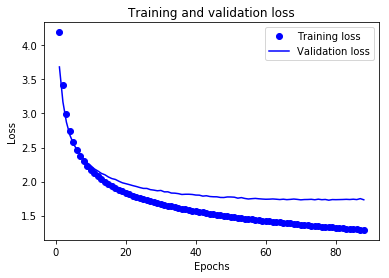

In [213]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

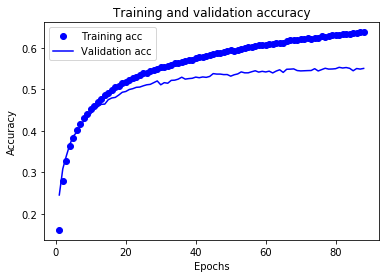

In [214]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [215]:
results = model.evaluate(x_test, one_hot_test_labels)
results

16147/16147 [==============================] - ETA: 2s - loss: 4.2699 - acc: 0.250 - ETA: 1s - loss: 2.1935 - acc: 0.447 - ETA: 1s - loss: 2.0929 - acc: 0.471 - ETA: 1s - loss: 1.9489 - acc: 0.502 - ETA: 1s - loss: 1.7394 - acc: 0.546 - ETA: 0s - loss: 1.4807 - acc: 0.615 - ETA: 0s - loss: 1.3787 - acc: 0.643 - ETA: 0s - loss: 1.3160 - acc: 0.649 - ETA: 0s - loss: 1.3068 - acc: 0.641 - ETA: 0s - loss: 1.3659 - acc: 0.630 - ETA: 0s - loss: 1.3786 - acc: 0.626 - ETA: 0s - loss: 1.4023 - acc: 0.619 - ETA: 0s - loss: 1.5073 - acc: 0.596 - ETA: 0s - loss: 1.5490 - acc: 0.582 - ETA: 0s - loss: 1.5664 - acc: 0.580 - ETA: 0s - loss: 1.6139 - acc: 0.572 - ETA: 0s - loss: 1.6410 - acc: 0.568 - ETA: 0s - loss: 1.6891 - acc: 0.560 - ETA: 0s - loss: 1.7046 - acc: 0.558 - ETA: 0s - loss: 1.7343 - acc: 0.550 - ETA: 0s - loss: 1.7491 - acc: 0.544 - ETA: 0s - loss: 1.7360 - acc: 0.548 - ETA: 0s - loss: 1.7252 - acc: 0.552 - 1s 71us/sample - loss: 1.7313 - acc: 0.5512


[1.7312850362266587, 0.5512479]

In [216]:
y_pred_one_hot = model.predict(x_test)
print(y_pred_one_hot.shape)
y_pred = np.argmax(y_pred_one_hot, axis=1)
print(y_pred.shape)
print(y_pred[:5])

(16147, 188)
(16147,)
[ 46  34  28 101   0]


In [217]:
from sklearn.metrics import classification_report

print(classification_report(y_test_idx, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.23      0.29        78
           1       0.41      0.42      0.42       182
           2       0.11      0.05      0.07        73
           3       0.62      0.53      0.57        19
           4       0.50      0.23      0.31        22
           5       0.47      0.36      0.41        25
           6       0.44      0.27      0.33        15
           7       0.60      0.79      0.68       161
           8       0.69      0.61      0.65        33
           9       0.24      0.21      0.22        24
          10       0.29      0.09      0.14        22
          11       0.48      0.59      0.53        82
          12       0.43      0.13      0.20        23
          13       0.74      0.68      0.71        34
          14       0.42      0.38      0.40        55
          15       0.24      0.25      0.24        16
          16       0.55      0.50      0.52       109
          17       0.65    

Improved model

In [218]:
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD

In [258]:
model2 = models.Sequential()
model2.add(layers.Dense(256, kernel_regularizer=regularizers.l1_l2(0.000, 0.002), input_shape=(dim,)))
model2.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.Dropout(rate = 0.35))
model2.add(layers.Dense(128, kernel_regularizer=regularizers.l1_l2(0.00, 0.002)))
model2.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.Dropout(rate = 0.35))
model2.add(layers.Dense(64, kernel_regularizer=regularizers.l1_l2(0.00, 0.002)))
model2.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.Dense(len(labels_dict), activation='softmax'))
model2.compile(optimizer=Adam(lr=3e-4),
              #optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [259]:
history2 = model2.fit(
            partial_x_train,
            partial_y_train,
            epochs=5000,
            batch_size=32,
            validation_data=(x_val, y_val),
            callbacks=[early_stopping, reduce_lr]
          )

Train on 40120 samples, validate on 8000 samples
Epoch 1/5000


27488/40120 [===================>..........] - ETA: 30:39 - loss: 6.4898 - acc: 0.0000e+ - ETA: 5:18 - loss: 6.4462 - acc: 0.0000e+00 - ETA: 2:59 - loss: 6.4295 - acc: 0.0000e+0 - ETA: 2:07 - loss: 6.4072 - acc: 0.0039    - ETA: 1:40 - loss: 6.3924 - acc: 0.006 - ETA: 1:23 - loss: 6.3917 - acc: 0.004 - ETA: 1:14 - loss: 6.3887 - acc: 0.006 - ETA: 1:07 - loss: 6.3734 - acc: 0.006 - ETA: 1:01 - loss: 6.3568 - acc: 0.007 - ETA: 55s - loss: 6.3493 - acc: 0.012 - ETA: 52s - loss: 6.3356 - acc: 0.01 - ETA: 49s - loss: 6.3182 - acc: 0.01 - ETA: 45s - loss: 6.3051 - acc: 0.01 - ETA: 43s - loss: 6.2869 - acc: 0.02 - ETA: 41s - loss: 6.2805 - acc: 0.02 - ETA: 39s - loss: 6.2655 - acc: 0.02 - ETA: 37s - loss: 6.2466 - acc: 0.02 - ETA: 35s - loss: 6.2303 - acc: 0.02 - ETA: 34s - loss: 6.2139 - acc: 0.03 - ETA: 33s - loss: 6.2021 - acc: 0.03 - ETA: 32s - loss: 6.1883 - acc: 0.03 - ETA: 31s - loss: 6.1697 - acc: 0.03 - ETA: 30s - loss: 6.1546 - acc: 0.04 - ETA: 29s - loss: 6.1391 - acc: 0.04 - ETA: 

40120/40120 [==============================] - ETA: 6s - loss: 5.0616 - acc: 0.204 - ETA: 5s - loss: 5.0579 - acc: 0.204 - ETA: 5s - loss: 5.0548 - acc: 0.204 - ETA: 5s - loss: 5.0508 - acc: 0.205 - ETA: 5s - loss: 5.0491 - acc: 0.205 - ETA: 5s - loss: 5.0467 - acc: 0.205 - ETA: 5s - loss: 5.0424 - acc: 0.206 - ETA: 5s - loss: 5.0392 - acc: 0.206 - ETA: 5s - loss: 5.0367 - acc: 0.206 - ETA: 5s - loss: 5.0317 - acc: 0.207 - ETA: 5s - loss: 5.0289 - acc: 0.207 - ETA: 5s - loss: 5.0260 - acc: 0.207 - ETA: 5s - loss: 5.0220 - acc: 0.208 - ETA: 5s - loss: 5.0203 - acc: 0.208 - ETA: 5s - loss: 5.0165 - acc: 0.208 - ETA: 5s - loss: 5.0129 - acc: 0.208 - ETA: 5s - loss: 5.0088 - acc: 0.209 - ETA: 5s - loss: 5.0049 - acc: 0.209 - ETA: 4s - loss: 5.0027 - acc: 0.209 - ETA: 4s - loss: 5.0002 - acc: 0.210 - ETA: 4s - loss: 4.9975 - acc: 0.210 - ETA: 4s - loss: 4.9943 - acc: 0.210 - ETA: 4s - loss: 4.9913 - acc: 0.211 - ETA: 4s - loss: 4.9877 - acc: 0.211 - ETA: 4s - loss: 4.9851 - acc: 0.211 - ETA

25056/40120 [=================>............] - ETA: 19s - loss: 4.2382 - acc: 0.21 - ETA: 18s - loss: 4.0410 - acc: 0.29 - ETA: 17s - loss: 4.0851 - acc: 0.29 - ETA: 17s - loss: 4.1327 - acc: 0.29 - ETA: 17s - loss: 4.0623 - acc: 0.31 - ETA: 16s - loss: 3.9894 - acc: 0.31 - ETA: 16s - loss: 4.0053 - acc: 0.30 - ETA: 17s - loss: 4.0563 - acc: 0.29 - ETA: 17s - loss: 4.0435 - acc: 0.30 - ETA: 17s - loss: 4.0010 - acc: 0.31 - ETA: 17s - loss: 3.9981 - acc: 0.30 - ETA: 17s - loss: 3.9853 - acc: 0.31 - ETA: 17s - loss: 3.9824 - acc: 0.31 - ETA: 17s - loss: 3.9719 - acc: 0.31 - ETA: 17s - loss: 3.9718 - acc: 0.31 - ETA: 17s - loss: 3.9612 - acc: 0.31 - ETA: 17s - loss: 3.9597 - acc: 0.32 - ETA: 18s - loss: 3.9777 - acc: 0.31 - ETA: 18s - loss: 3.9786 - acc: 0.31 - ETA: 18s - loss: 3.9712 - acc: 0.31 - ETA: 18s - loss: 3.9783 - acc: 0.30 - ETA: 18s - loss: 3.9726 - acc: 0.30 - ETA: 18s - loss: 3.9862 - acc: 0.30 - ETA: 18s - loss: 3.9808 - acc: 0.30 - ETA: 18s - loss: 3.9867 - acc: 0.30 - ETA

40120/40120 [==============================] - ETA: 7s - loss: 3.7342 - acc: 0.328 - ETA: 7s - loss: 3.7343 - acc: 0.328 - ETA: 7s - loss: 3.7324 - acc: 0.329 - ETA: 7s - loss: 3.7326 - acc: 0.328 - ETA: 7s - loss: 3.7297 - acc: 0.329 - ETA: 7s - loss: 3.7285 - acc: 0.329 - ETA: 6s - loss: 3.7276 - acc: 0.329 - ETA: 6s - loss: 3.7264 - acc: 0.329 - ETA: 6s - loss: 3.7248 - acc: 0.329 - ETA: 6s - loss: 3.7224 - acc: 0.329 - ETA: 6s - loss: 3.7232 - acc: 0.329 - ETA: 6s - loss: 3.7229 - acc: 0.329 - ETA: 6s - loss: 3.7214 - acc: 0.329 - ETA: 6s - loss: 3.7202 - acc: 0.329 - ETA: 6s - loss: 3.7184 - acc: 0.330 - ETA: 6s - loss: 3.7164 - acc: 0.330 - ETA: 6s - loss: 3.7142 - acc: 0.330 - ETA: 6s - loss: 3.7137 - acc: 0.330 - ETA: 6s - loss: 3.7123 - acc: 0.330 - ETA: 6s - loss: 3.7113 - acc: 0.331 - ETA: 6s - loss: 3.7111 - acc: 0.331 - ETA: 5s - loss: 3.7102 - acc: 0.330 - ETA: 5s - loss: 3.7095 - acc: 0.330 - ETA: 5s - loss: 3.7082 - acc: 0.330 - ETA: 5s - loss: 3.7079 - acc: 0.330 - ETA

26240/40120 [==================>...........] - ETA: 21s - loss: 2.9467 - acc: 0.46 - ETA: 18s - loss: 3.4015 - acc: 0.31 - ETA: 18s - loss: 3.3283 - acc: 0.33 - ETA: 17s - loss: 3.3172 - acc: 0.34 - ETA: 17s - loss: 3.2920 - acc: 0.36 - ETA: 17s - loss: 3.2955 - acc: 0.35 - ETA: 17s - loss: 3.3130 - acc: 0.35 - ETA: 17s - loss: 3.3061 - acc: 0.36 - ETA: 17s - loss: 3.3143 - acc: 0.36 - ETA: 17s - loss: 3.2940 - acc: 0.37 - ETA: 17s - loss: 3.3055 - acc: 0.36 - ETA: 17s - loss: 3.2746 - acc: 0.37 - ETA: 17s - loss: 3.2739 - acc: 0.37 - ETA: 17s - loss: 3.2822 - acc: 0.37 - ETA: 17s - loss: 3.2707 - acc: 0.37 - ETA: 17s - loss: 3.2656 - acc: 0.37 - ETA: 16s - loss: 3.2786 - acc: 0.37 - ETA: 16s - loss: 3.2596 - acc: 0.37 - ETA: 16s - loss: 3.2585 - acc: 0.37 - ETA: 16s - loss: 3.2699 - acc: 0.37 - ETA: 16s - loss: 3.2776 - acc: 0.37 - ETA: 16s - loss: 3.2801 - acc: 0.36 - ETA: 16s - loss: 3.2657 - acc: 0.37 - ETA: 16s - loss: 3.2799 - acc: 0.37 - ETA: 16s - loss: 3.2803 - acc: 0.36 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 3.1362 - acc: 0.381 - ETA: 6s - loss: 3.1357 - acc: 0.381 - ETA: 6s - loss: 3.1364 - acc: 0.381 - ETA: 6s - loss: 3.1353 - acc: 0.381 - ETA: 6s - loss: 3.1355 - acc: 0.380 - ETA: 6s - loss: 3.1349 - acc: 0.381 - ETA: 6s - loss: 3.1344 - acc: 0.380 - ETA: 6s - loss: 3.1339 - acc: 0.381 - ETA: 6s - loss: 3.1332 - acc: 0.381 - ETA: 5s - loss: 3.1330 - acc: 0.381 - ETA: 5s - loss: 3.1345 - acc: 0.381 - ETA: 5s - loss: 3.1338 - acc: 0.381 - ETA: 5s - loss: 3.1326 - acc: 0.381 - ETA: 5s - loss: 3.1325 - acc: 0.381 - ETA: 5s - loss: 3.1320 - acc: 0.381 - ETA: 5s - loss: 3.1300 - acc: 0.381 - ETA: 5s - loss: 3.1289 - acc: 0.381 - ETA: 5s - loss: 3.1291 - acc: 0.381 - ETA: 5s - loss: 3.1289 - acc: 0.381 - ETA: 5s - loss: 3.1288 - acc: 0.381 - ETA: 5s - loss: 3.1289 - acc: 0.381 - ETA: 5s - loss: 3.1296 - acc: 0.381 - ETA: 5s - loss: 3.1304 - acc: 0.381 - ETA: 5s - loss: 3.1303 - acc: 0.380 - ETA: 5s - loss: 3.1307 - acc: 0.380 - ETA

26816/40120 [===================>..........] - ETA: 19s - loss: 3.0087 - acc: 0.34 - ETA: 17s - loss: 3.0396 - acc: 0.40 - ETA: 18s - loss: 2.8392 - acc: 0.43 - ETA: 17s - loss: 2.8806 - acc: 0.42 - ETA: 18s - loss: 2.8670 - acc: 0.43 - ETA: 18s - loss: 2.8630 - acc: 0.42 - ETA: 18s - loss: 2.8673 - acc: 0.42 - ETA: 18s - loss: 2.8286 - acc: 0.43 - ETA: 18s - loss: 2.8207 - acc: 0.43 - ETA: 17s - loss: 2.8207 - acc: 0.43 - ETA: 17s - loss: 2.8209 - acc: 0.42 - ETA: 17s - loss: 2.8174 - acc: 0.42 - ETA: 17s - loss: 2.7898 - acc: 0.42 - ETA: 17s - loss: 2.8056 - acc: 0.42 - ETA: 17s - loss: 2.8029 - acc: 0.41 - ETA: 17s - loss: 2.8000 - acc: 0.42 - ETA: 17s - loss: 2.8089 - acc: 0.41 - ETA: 17s - loss: 2.8031 - acc: 0.42 - ETA: 16s - loss: 2.8110 - acc: 0.42 - ETA: 16s - loss: 2.8227 - acc: 0.42 - ETA: 16s - loss: 2.8211 - acc: 0.42 - ETA: 16s - loss: 2.8140 - acc: 0.42 - ETA: 16s - loss: 2.8095 - acc: 0.42 - ETA: 16s - loss: 2.8119 - acc: 0.42 - ETA: 16s - loss: 2.8198 - acc: 0.42 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 2.7981 - acc: 0.418 - ETA: 5s - loss: 2.7980 - acc: 0.418 - ETA: 5s - loss: 2.7974 - acc: 0.419 - ETA: 5s - loss: 2.7965 - acc: 0.419 - ETA: 5s - loss: 2.7968 - acc: 0.418 - ETA: 5s - loss: 2.7974 - acc: 0.418 - ETA: 5s - loss: 2.7967 - acc: 0.419 - ETA: 5s - loss: 2.7961 - acc: 0.419 - ETA: 5s - loss: 2.7956 - acc: 0.418 - ETA: 5s - loss: 2.7961 - acc: 0.418 - ETA: 5s - loss: 2.7959 - acc: 0.418 - ETA: 5s - loss: 2.7967 - acc: 0.418 - ETA: 5s - loss: 2.7966 - acc: 0.418 - ETA: 5s - loss: 2.7968 - acc: 0.418 - ETA: 5s - loss: 2.7956 - acc: 0.418 - ETA: 5s - loss: 2.7940 - acc: 0.418 - ETA: 5s - loss: 2.7943 - acc: 0.418 - ETA: 5s - loss: 2.7948 - acc: 0.418 - ETA: 4s - loss: 2.7950 - acc: 0.418 - ETA: 4s - loss: 2.7945 - acc: 0.418 - ETA: 4s - loss: 2.7934 - acc: 0.418 - ETA: 4s - loss: 2.7932 - acc: 0.418 - ETA: 4s - loss: 2.7925 - acc: 0.418 - ETA: 4s - loss: 2.7919 - acc: 0.419 - ETA: 4s - loss: 2.7915 - acc: 0.419 - ETA

27008/40120 [===================>..........] - ETA: 22s - loss: 2.7949 - acc: 0.34 - ETA: 19s - loss: 2.7999 - acc: 0.38 - ETA: 18s - loss: 2.7002 - acc: 0.41 - ETA: 18s - loss: 2.6401 - acc: 0.42 - ETA: 18s - loss: 2.6061 - acc: 0.43 - ETA: 18s - loss: 2.5746 - acc: 0.43 - ETA: 18s - loss: 2.6239 - acc: 0.43 - ETA: 17s - loss: 2.6362 - acc: 0.43 - ETA: 17s - loss: 2.6493 - acc: 0.42 - ETA: 17s - loss: 2.6552 - acc: 0.43 - ETA: 17s - loss: 2.6677 - acc: 0.42 - ETA: 17s - loss: 2.6815 - acc: 0.42 - ETA: 17s - loss: 2.6951 - acc: 0.42 - ETA: 17s - loss: 2.6834 - acc: 0.43 - ETA: 17s - loss: 2.6772 - acc: 0.43 - ETA: 17s - loss: 2.6927 - acc: 0.43 - ETA: 17s - loss: 2.6912 - acc: 0.43 - ETA: 17s - loss: 2.6729 - acc: 0.43 - ETA: 17s - loss: 2.6604 - acc: 0.43 - ETA: 17s - loss: 2.6566 - acc: 0.44 - ETA: 17s - loss: 2.6613 - acc: 0.43 - ETA: 17s - loss: 2.6770 - acc: 0.43 - ETA: 17s - loss: 2.6630 - acc: 0.43 - ETA: 17s - loss: 2.6610 - acc: 0.43 - ETA: 16s - loss: 2.6594 - acc: 0.43 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 2.6087 - acc: 0.434 - ETA: 5s - loss: 2.6084 - acc: 0.434 - ETA: 5s - loss: 2.6092 - acc: 0.434 - ETA: 5s - loss: 2.6089 - acc: 0.434 - ETA: 5s - loss: 2.6090 - acc: 0.434 - ETA: 5s - loss: 2.6089 - acc: 0.434 - ETA: 5s - loss: 2.6091 - acc: 0.434 - ETA: 5s - loss: 2.6091 - acc: 0.433 - ETA: 5s - loss: 2.6079 - acc: 0.433 - ETA: 5s - loss: 2.6074 - acc: 0.433 - ETA: 5s - loss: 2.6086 - acc: 0.433 - ETA: 5s - loss: 2.6091 - acc: 0.433 - ETA: 5s - loss: 2.6101 - acc: 0.433 - ETA: 5s - loss: 2.6105 - acc: 0.433 - ETA: 5s - loss: 2.6100 - acc: 0.432 - ETA: 5s - loss: 2.6103 - acc: 0.432 - ETA: 4s - loss: 2.6097 - acc: 0.432 - ETA: 4s - loss: 2.6096 - acc: 0.433 - ETA: 4s - loss: 2.6095 - acc: 0.432 - ETA: 4s - loss: 2.6098 - acc: 0.432 - ETA: 4s - loss: 2.6096 - acc: 0.432 - ETA: 4s - loss: 2.6103 - acc: 0.432 - ETA: 4s - loss: 2.6102 - acc: 0.432 - ETA: 4s - loss: 2.6109 - acc: 0.432 - ETA: 4s - loss: 2.6112 - acc: 0.432 - ETA

27040/40120 [===================>..........] - ETA: 22s - loss: 2.4510 - acc: 0.37 - ETA: 21s - loss: 2.6659 - acc: 0.37 - ETA: 21s - loss: 2.7195 - acc: 0.39 - ETA: 20s - loss: 2.6046 - acc: 0.42 - ETA: 19s - loss: 2.5145 - acc: 0.45 - ETA: 18s - loss: 2.4951 - acc: 0.44 - ETA: 18s - loss: 2.5115 - acc: 0.44 - ETA: 18s - loss: 2.4956 - acc: 0.44 - ETA: 18s - loss: 2.5393 - acc: 0.43 - ETA: 18s - loss: 2.5330 - acc: 0.43 - ETA: 18s - loss: 2.5200 - acc: 0.44 - ETA: 18s - loss: 2.4892 - acc: 0.45 - ETA: 18s - loss: 2.4880 - acc: 0.45 - ETA: 17s - loss: 2.5043 - acc: 0.45 - ETA: 17s - loss: 2.4909 - acc: 0.45 - ETA: 17s - loss: 2.5001 - acc: 0.45 - ETA: 17s - loss: 2.5087 - acc: 0.45 - ETA: 17s - loss: 2.4967 - acc: 0.45 - ETA: 17s - loss: 2.5060 - acc: 0.44 - ETA: 17s - loss: 2.5064 - acc: 0.44 - ETA: 17s - loss: 2.5040 - acc: 0.44 - ETA: 17s - loss: 2.5153 - acc: 0.44 - ETA: 16s - loss: 2.5124 - acc: 0.44 - ETA: 16s - loss: 2.5037 - acc: 0.44 - ETA: 16s - loss: 2.5055 - acc: 0.44 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 2.4905 - acc: 0.445 - ETA: 5s - loss: 2.4907 - acc: 0.445 - ETA: 5s - loss: 2.4901 - acc: 0.446 - ETA: 5s - loss: 2.4905 - acc: 0.445 - ETA: 5s - loss: 2.4908 - acc: 0.445 - ETA: 5s - loss: 2.4904 - acc: 0.445 - ETA: 5s - loss: 2.4893 - acc: 0.445 - ETA: 5s - loss: 2.4879 - acc: 0.446 - ETA: 5s - loss: 2.4868 - acc: 0.446 - ETA: 5s - loss: 2.4858 - acc: 0.446 - ETA: 5s - loss: 2.4847 - acc: 0.446 - ETA: 5s - loss: 2.4844 - acc: 0.446 - ETA: 5s - loss: 2.4837 - acc: 0.447 - ETA: 5s - loss: 2.4839 - acc: 0.447 - ETA: 5s - loss: 2.4834 - acc: 0.447 - ETA: 5s - loss: 2.4832 - acc: 0.447 - ETA: 4s - loss: 2.4826 - acc: 0.447 - ETA: 4s - loss: 2.4829 - acc: 0.447 - ETA: 4s - loss: 2.4827 - acc: 0.447 - ETA: 4s - loss: 2.4827 - acc: 0.447 - ETA: 4s - loss: 2.4825 - acc: 0.447 - ETA: 4s - loss: 2.4820 - acc: 0.447 - ETA: 4s - loss: 2.4812 - acc: 0.448 - ETA: 4s - loss: 2.4805 - acc: 0.448 - ETA: 4s - loss: 2.4806 - acc: 0.448 - ETA

26944/40120 [===================>..........] - ETA: 22s - loss: 2.3014 - acc: 0.50 - ETA: 23s - loss: 2.3807 - acc: 0.43 - ETA: 20s - loss: 2.3312 - acc: 0.46 - ETA: 19s - loss: 2.2921 - acc: 0.48 - ETA: 18s - loss: 2.3183 - acc: 0.46 - ETA: 18s - loss: 2.3397 - acc: 0.45 - ETA: 18s - loss: 2.2991 - acc: 0.46 - ETA: 18s - loss: 2.3122 - acc: 0.45 - ETA: 18s - loss: 2.3254 - acc: 0.45 - ETA: 18s - loss: 2.3405 - acc: 0.45 - ETA: 18s - loss: 2.3338 - acc: 0.46 - ETA: 18s - loss: 2.3572 - acc: 0.45 - ETA: 18s - loss: 2.3458 - acc: 0.46 - ETA: 17s - loss: 2.3329 - acc: 0.47 - ETA: 17s - loss: 2.3506 - acc: 0.46 - ETA: 17s - loss: 2.3530 - acc: 0.46 - ETA: 17s - loss: 2.3528 - acc: 0.46 - ETA: 17s - loss: 2.3566 - acc: 0.46 - ETA: 17s - loss: 2.3476 - acc: 0.46 - ETA: 17s - loss: 2.3375 - acc: 0.46 - ETA: 17s - loss: 2.3408 - acc: 0.46 - ETA: 17s - loss: 2.3596 - acc: 0.46 - ETA: 17s - loss: 2.3653 - acc: 0.46 - ETA: 17s - loss: 2.3618 - acc: 0.46 - ETA: 16s - loss: 2.3630 - acc: 0.46 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 2.3963 - acc: 0.458 - ETA: 5s - loss: 2.3959 - acc: 0.458 - ETA: 5s - loss: 2.3957 - acc: 0.459 - ETA: 5s - loss: 2.3957 - acc: 0.458 - ETA: 5s - loss: 2.3958 - acc: 0.458 - ETA: 5s - loss: 2.3959 - acc: 0.458 - ETA: 5s - loss: 2.3938 - acc: 0.459 - ETA: 5s - loss: 2.3931 - acc: 0.459 - ETA: 5s - loss: 2.3934 - acc: 0.459 - ETA: 5s - loss: 2.3927 - acc: 0.459 - ETA: 5s - loss: 2.3932 - acc: 0.458 - ETA: 5s - loss: 2.3930 - acc: 0.458 - ETA: 5s - loss: 2.3931 - acc: 0.458 - ETA: 5s - loss: 2.3944 - acc: 0.458 - ETA: 5s - loss: 2.3939 - acc: 0.458 - ETA: 5s - loss: 2.3940 - acc: 0.458 - ETA: 5s - loss: 2.3938 - acc: 0.459 - ETA: 4s - loss: 2.3925 - acc: 0.459 - ETA: 4s - loss: 2.3915 - acc: 0.459 - ETA: 4s - loss: 2.3917 - acc: 0.459 - ETA: 4s - loss: 2.3908 - acc: 0.459 - ETA: 4s - loss: 2.3916 - acc: 0.459 - ETA: 4s - loss: 2.3921 - acc: 0.459 - ETA: 4s - loss: 2.3921 - acc: 0.458 - ETA: 4s - loss: 2.3918 - acc: 0.458 - ETA

26560/40120 [==================>...........] - ETA: 22s - loss: 1.7578 - acc: 0.62 - ETA: 18s - loss: 2.3217 - acc: 0.48 - ETA: 18s - loss: 2.3519 - acc: 0.50 - ETA: 18s - loss: 2.3251 - acc: 0.48 - ETA: 18s - loss: 2.2815 - acc: 0.48 - ETA: 17s - loss: 2.2765 - acc: 0.48 - ETA: 17s - loss: 2.3018 - acc: 0.47 - ETA: 17s - loss: 2.3310 - acc: 0.46 - ETA: 17s - loss: 2.3574 - acc: 0.46 - ETA: 17s - loss: 2.3815 - acc: 0.46 - ETA: 17s - loss: 2.3819 - acc: 0.46 - ETA: 17s - loss: 2.3757 - acc: 0.45 - ETA: 17s - loss: 2.3892 - acc: 0.45 - ETA: 17s - loss: 2.3799 - acc: 0.45 - ETA: 17s - loss: 2.3758 - acc: 0.45 - ETA: 17s - loss: 2.3706 - acc: 0.45 - ETA: 17s - loss: 2.3568 - acc: 0.46 - ETA: 17s - loss: 2.3582 - acc: 0.46 - ETA: 17s - loss: 2.3442 - acc: 0.46 - ETA: 17s - loss: 2.3471 - acc: 0.46 - ETA: 17s - loss: 2.3464 - acc: 0.46 - ETA: 16s - loss: 2.3473 - acc: 0.46 - ETA: 16s - loss: 2.3589 - acc: 0.45 - ETA: 16s - loss: 2.3546 - acc: 0.45 - ETA: 16s - loss: 2.3453 - acc: 0.45 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 2.3314 - acc: 0.466 - ETA: 6s - loss: 2.3309 - acc: 0.465 - ETA: 6s - loss: 2.3308 - acc: 0.466 - ETA: 6s - loss: 2.3305 - acc: 0.466 - ETA: 5s - loss: 2.3293 - acc: 0.466 - ETA: 5s - loss: 2.3297 - acc: 0.467 - ETA: 5s - loss: 2.3292 - acc: 0.467 - ETA: 5s - loss: 2.3290 - acc: 0.466 - ETA: 5s - loss: 2.3289 - acc: 0.466 - ETA: 5s - loss: 2.3300 - acc: 0.466 - ETA: 5s - loss: 2.3316 - acc: 0.466 - ETA: 5s - loss: 2.3331 - acc: 0.465 - ETA: 5s - loss: 2.3325 - acc: 0.466 - ETA: 5s - loss: 2.3322 - acc: 0.466 - ETA: 5s - loss: 2.3319 - acc: 0.466 - ETA: 5s - loss: 2.3302 - acc: 0.466 - ETA: 5s - loss: 2.3302 - acc: 0.466 - ETA: 5s - loss: 2.3291 - acc: 0.467 - ETA: 5s - loss: 2.3300 - acc: 0.467 - ETA: 5s - loss: 2.3309 - acc: 0.466 - ETA: 5s - loss: 2.3304 - acc: 0.466 - ETA: 4s - loss: 2.3310 - acc: 0.466 - ETA: 4s - loss: 2.3308 - acc: 0.466 - ETA: 4s - loss: 2.3296 - acc: 0.466 - ETA: 4s - loss: 2.3298 - acc: 0.466 - ETA

26688/40120 [==================>...........] - ETA: 22s - loss: 2.1126 - acc: 0.50 - ETA: 19s - loss: 2.4469 - acc: 0.42 - ETA: 18s - loss: 2.3780 - acc: 0.45 - ETA: 18s - loss: 2.4273 - acc: 0.43 - ETA: 18s - loss: 2.3298 - acc: 0.47 - ETA: 18s - loss: 2.3557 - acc: 0.47 - ETA: 18s - loss: 2.3405 - acc: 0.47 - ETA: 18s - loss: 2.3152 - acc: 0.47 - ETA: 17s - loss: 2.2582 - acc: 0.47 - ETA: 17s - loss: 2.2768 - acc: 0.47 - ETA: 17s - loss: 2.2708 - acc: 0.47 - ETA: 17s - loss: 2.2672 - acc: 0.47 - ETA: 17s - loss: 2.2736 - acc: 0.47 - ETA: 17s - loss: 2.2641 - acc: 0.47 - ETA: 17s - loss: 2.2609 - acc: 0.47 - ETA: 17s - loss: 2.2583 - acc: 0.47 - ETA: 17s - loss: 2.2318 - acc: 0.48 - ETA: 17s - loss: 2.2496 - acc: 0.48 - ETA: 17s - loss: 2.2500 - acc: 0.48 - ETA: 17s - loss: 2.2472 - acc: 0.48 - ETA: 17s - loss: 2.2442 - acc: 0.48 - ETA: 17s - loss: 2.2525 - acc: 0.48 - ETA: 17s - loss: 2.2473 - acc: 0.48 - ETA: 17s - loss: 2.2323 - acc: 0.48 - ETA: 17s - loss: 2.2332 - acc: 0.48 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 2.2713 - acc: 0.472 - ETA: 6s - loss: 2.2721 - acc: 0.472 - ETA: 6s - loss: 2.2719 - acc: 0.473 - ETA: 6s - loss: 2.2727 - acc: 0.472 - ETA: 5s - loss: 2.2722 - acc: 0.473 - ETA: 5s - loss: 2.2744 - acc: 0.472 - ETA: 5s - loss: 2.2742 - acc: 0.472 - ETA: 5s - loss: 2.2744 - acc: 0.472 - ETA: 5s - loss: 2.2734 - acc: 0.473 - ETA: 5s - loss: 2.2739 - acc: 0.473 - ETA: 5s - loss: 2.2745 - acc: 0.472 - ETA: 5s - loss: 2.2754 - acc: 0.472 - ETA: 5s - loss: 2.2755 - acc: 0.472 - ETA: 5s - loss: 2.2757 - acc: 0.472 - ETA: 5s - loss: 2.2757 - acc: 0.473 - ETA: 5s - loss: 2.2753 - acc: 0.473 - ETA: 5s - loss: 2.2750 - acc: 0.473 - ETA: 5s - loss: 2.2759 - acc: 0.473 - ETA: 5s - loss: 2.2742 - acc: 0.474 - ETA: 5s - loss: 2.2756 - acc: 0.474 - ETA: 4s - loss: 2.2759 - acc: 0.473 - ETA: 4s - loss: 2.2749 - acc: 0.473 - ETA: 4s - loss: 2.2756 - acc: 0.473 - ETA: 4s - loss: 2.2747 - acc: 0.473 - ETA: 4s - loss: 2.2755 - acc: 0.473 - ETA

26112/40120 [==================>...........] - ETA: 22s - loss: 2.2253 - acc: 0.50 - ETA: 18s - loss: 2.3326 - acc: 0.42 - ETA: 18s - loss: 2.2378 - acc: 0.47 - ETA: 17s - loss: 2.2557 - acc: 0.46 - ETA: 17s - loss: 2.1721 - acc: 0.48 - ETA: 17s - loss: 2.1905 - acc: 0.47 - ETA: 17s - loss: 2.1702 - acc: 0.47 - ETA: 17s - loss: 2.1725 - acc: 0.47 - ETA: 17s - loss: 2.1770 - acc: 0.47 - ETA: 17s - loss: 2.1749 - acc: 0.47 - ETA: 17s - loss: 2.1990 - acc: 0.47 - ETA: 17s - loss: 2.1871 - acc: 0.47 - ETA: 17s - loss: 2.1738 - acc: 0.48 - ETA: 17s - loss: 2.1726 - acc: 0.48 - ETA: 17s - loss: 2.1911 - acc: 0.48 - ETA: 17s - loss: 2.1908 - acc: 0.48 - ETA: 17s - loss: 2.1861 - acc: 0.48 - ETA: 17s - loss: 2.2027 - acc: 0.48 - ETA: 17s - loss: 2.1982 - acc: 0.48 - ETA: 17s - loss: 2.1890 - acc: 0.48 - ETA: 17s - loss: 2.1893 - acc: 0.48 - ETA: 17s - loss: 2.1970 - acc: 0.48 - ETA: 17s - loss: 2.1887 - acc: 0.48 - ETA: 17s - loss: 2.2106 - acc: 0.47 - ETA: 17s - loss: 2.2047 - acc: 0.48 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 2.2224 - acc: 0.484 - ETA: 6s - loss: 2.2203 - acc: 0.484 - ETA: 6s - loss: 2.2202 - acc: 0.484 - ETA: 6s - loss: 2.2202 - acc: 0.484 - ETA: 6s - loss: 2.2204 - acc: 0.484 - ETA: 6s - loss: 2.2191 - acc: 0.485 - ETA: 6s - loss: 2.2194 - acc: 0.485 - ETA: 6s - loss: 2.2190 - acc: 0.485 - ETA: 6s - loss: 2.2196 - acc: 0.484 - ETA: 6s - loss: 2.2193 - acc: 0.485 - ETA: 5s - loss: 2.2186 - acc: 0.485 - ETA: 5s - loss: 2.2193 - acc: 0.485 - ETA: 5s - loss: 2.2202 - acc: 0.485 - ETA: 5s - loss: 2.2192 - acc: 0.485 - ETA: 5s - loss: 2.2189 - acc: 0.485 - ETA: 5s - loss: 2.2185 - acc: 0.485 - ETA: 5s - loss: 2.2186 - acc: 0.485 - ETA: 5s - loss: 2.2192 - acc: 0.485 - ETA: 5s - loss: 2.2184 - acc: 0.485 - ETA: 5s - loss: 2.2190 - acc: 0.485 - ETA: 5s - loss: 2.2197 - acc: 0.485 - ETA: 5s - loss: 2.2208 - acc: 0.485 - ETA: 5s - loss: 2.2216 - acc: 0.485 - ETA: 5s - loss: 2.2221 - acc: 0.485 - ETA: 5s - loss: 2.2227 - acc: 0.484 - ETA

26304/40120 [==================>...........] - ETA: 23s - loss: 2.1484 - acc: 0.40 - ETA: 18s - loss: 2.3534 - acc: 0.39 - ETA: 17s - loss: 2.2561 - acc: 0.45 - ETA: 17s - loss: 2.1944 - acc: 0.45 - ETA: 16s - loss: 2.1678 - acc: 0.46 - ETA: 17s - loss: 2.1828 - acc: 0.47 - ETA: 16s - loss: 2.1414 - acc: 0.48 - ETA: 16s - loss: 2.1635 - acc: 0.47 - ETA: 17s - loss: 2.1674 - acc: 0.48 - ETA: 16s - loss: 2.1572 - acc: 0.49 - ETA: 17s - loss: 2.1582 - acc: 0.48 - ETA: 17s - loss: 2.1801 - acc: 0.48 - ETA: 17s - loss: 2.1614 - acc: 0.48 - ETA: 16s - loss: 2.1606 - acc: 0.48 - ETA: 16s - loss: 2.1621 - acc: 0.49 - ETA: 16s - loss: 2.1660 - acc: 0.48 - ETA: 16s - loss: 2.1596 - acc: 0.48 - ETA: 16s - loss: 2.1616 - acc: 0.48 - ETA: 16s - loss: 2.1654 - acc: 0.48 - ETA: 16s - loss: 2.1616 - acc: 0.48 - ETA: 16s - loss: 2.1640 - acc: 0.48 - ETA: 16s - loss: 2.1577 - acc: 0.48 - ETA: 16s - loss: 2.1508 - acc: 0.48 - ETA: 16s - loss: 2.1555 - acc: 0.48 - ETA: 16s - loss: 2.1505 - acc: 0.48 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 2.1740 - acc: 0.487 - ETA: 6s - loss: 2.1740 - acc: 0.487 - ETA: 6s - loss: 2.1728 - acc: 0.488 - ETA: 6s - loss: 2.1742 - acc: 0.487 - ETA: 6s - loss: 2.1734 - acc: 0.487 - ETA: 6s - loss: 2.1743 - acc: 0.487 - ETA: 6s - loss: 2.1749 - acc: 0.487 - ETA: 6s - loss: 2.1769 - acc: 0.487 - ETA: 6s - loss: 2.1773 - acc: 0.487 - ETA: 5s - loss: 2.1776 - acc: 0.487 - ETA: 5s - loss: 2.1782 - acc: 0.487 - ETA: 5s - loss: 2.1788 - acc: 0.487 - ETA: 5s - loss: 2.1780 - acc: 0.487 - ETA: 5s - loss: 2.1784 - acc: 0.487 - ETA: 5s - loss: 2.1786 - acc: 0.487 - ETA: 5s - loss: 2.1789 - acc: 0.486 - ETA: 5s - loss: 2.1785 - acc: 0.486 - ETA: 5s - loss: 2.1781 - acc: 0.486 - ETA: 5s - loss: 2.1794 - acc: 0.486 - ETA: 5s - loss: 2.1794 - acc: 0.486 - ETA: 5s - loss: 2.1788 - acc: 0.487 - ETA: 5s - loss: 2.1787 - acc: 0.487 - ETA: 5s - loss: 2.1775 - acc: 0.487 - ETA: 5s - loss: 2.1772 - acc: 0.487 - ETA: 5s - loss: 2.1779 - acc: 0.487 - ETA

26880/40120 [===================>..........] - ETA: 24s - loss: 1.6119 - acc: 0.62 - ETA: 19s - loss: 2.0631 - acc: 0.51 - ETA: 18s - loss: 2.1181 - acc: 0.51 - ETA: 18s - loss: 2.0922 - acc: 0.52 - ETA: 17s - loss: 2.1133 - acc: 0.51 - ETA: 17s - loss: 2.1439 - acc: 0.50 - ETA: 17s - loss: 2.1796 - acc: 0.50 - ETA: 17s - loss: 2.1984 - acc: 0.50 - ETA: 17s - loss: 2.1952 - acc: 0.50 - ETA: 17s - loss: 2.1968 - acc: 0.50 - ETA: 17s - loss: 2.2043 - acc: 0.49 - ETA: 17s - loss: 2.2177 - acc: 0.49 - ETA: 17s - loss: 2.2139 - acc: 0.49 - ETA: 17s - loss: 2.2237 - acc: 0.48 - ETA: 17s - loss: 2.2236 - acc: 0.48 - ETA: 17s - loss: 2.2070 - acc: 0.48 - ETA: 17s - loss: 2.2122 - acc: 0.48 - ETA: 17s - loss: 2.2160 - acc: 0.48 - ETA: 17s - loss: 2.1986 - acc: 0.48 - ETA: 17s - loss: 2.2002 - acc: 0.48 - ETA: 16s - loss: 2.1901 - acc: 0.48 - ETA: 16s - loss: 2.1863 - acc: 0.49 - ETA: 16s - loss: 2.1853 - acc: 0.49 - ETA: 16s - loss: 2.1762 - acc: 0.49 - ETA: 16s - loss: 2.1724 - acc: 0.49 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 2.1679 - acc: 0.491 - ETA: 5s - loss: 2.1670 - acc: 0.491 - ETA: 5s - loss: 2.1665 - acc: 0.492 - ETA: 5s - loss: 2.1668 - acc: 0.491 - ETA: 5s - loss: 2.1670 - acc: 0.491 - ETA: 5s - loss: 2.1668 - acc: 0.491 - ETA: 5s - loss: 2.1669 - acc: 0.492 - ETA: 5s - loss: 2.1668 - acc: 0.492 - ETA: 5s - loss: 2.1675 - acc: 0.491 - ETA: 5s - loss: 2.1673 - acc: 0.491 - ETA: 5s - loss: 2.1669 - acc: 0.491 - ETA: 5s - loss: 2.1679 - acc: 0.491 - ETA: 5s - loss: 2.1680 - acc: 0.491 - ETA: 5s - loss: 2.1670 - acc: 0.491 - ETA: 5s - loss: 2.1668 - acc: 0.491 - ETA: 5s - loss: 2.1665 - acc: 0.491 - ETA: 5s - loss: 2.1653 - acc: 0.491 - ETA: 5s - loss: 2.1651 - acc: 0.491 - ETA: 4s - loss: 2.1649 - acc: 0.491 - ETA: 4s - loss: 2.1637 - acc: 0.491 - ETA: 4s - loss: 2.1643 - acc: 0.491 - ETA: 4s - loss: 2.1646 - acc: 0.491 - ETA: 4s - loss: 2.1650 - acc: 0.490 - ETA: 4s - loss: 2.1655 - acc: 0.490 - ETA: 4s - loss: 2.1653 - acc: 0.490 - ETA

26464/40120 [==================>...........] - ETA: 21s - loss: 1.7383 - acc: 0.53 - ETA: 17s - loss: 1.9468 - acc: 0.53 - ETA: 17s - loss: 2.1438 - acc: 0.47 - ETA: 17s - loss: 2.1284 - acc: 0.49 - ETA: 18s - loss: 2.1451 - acc: 0.50 - ETA: 19s - loss: 2.1307 - acc: 0.50 - ETA: 19s - loss: 2.1432 - acc: 0.49 - ETA: 19s - loss: 2.1548 - acc: 0.50 - ETA: 19s - loss: 2.1541 - acc: 0.49 - ETA: 18s - loss: 2.1757 - acc: 0.49 - ETA: 18s - loss: 2.1530 - acc: 0.49 - ETA: 18s - loss: 2.1419 - acc: 0.50 - ETA: 18s - loss: 2.1295 - acc: 0.50 - ETA: 18s - loss: 2.1317 - acc: 0.50 - ETA: 18s - loss: 2.1378 - acc: 0.50 - ETA: 18s - loss: 2.1139 - acc: 0.50 - ETA: 18s - loss: 2.1221 - acc: 0.50 - ETA: 18s - loss: 2.1212 - acc: 0.50 - ETA: 18s - loss: 2.1225 - acc: 0.50 - ETA: 18s - loss: 2.1179 - acc: 0.50 - ETA: 17s - loss: 2.1097 - acc: 0.50 - ETA: 17s - loss: 2.1028 - acc: 0.50 - ETA: 17s - loss: 2.1032 - acc: 0.50 - ETA: 17s - loss: 2.0985 - acc: 0.50 - ETA: 17s - loss: 2.0987 - acc: 0.50 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 2.1278 - acc: 0.497 - ETA: 6s - loss: 2.1271 - acc: 0.497 - ETA: 6s - loss: 2.1281 - acc: 0.497 - ETA: 6s - loss: 2.1289 - acc: 0.497 - ETA: 6s - loss: 2.1293 - acc: 0.497 - ETA: 6s - loss: 2.1298 - acc: 0.496 - ETA: 6s - loss: 2.1301 - acc: 0.496 - ETA: 5s - loss: 2.1293 - acc: 0.496 - ETA: 5s - loss: 2.1287 - acc: 0.496 - ETA: 5s - loss: 2.1281 - acc: 0.496 - ETA: 5s - loss: 2.1286 - acc: 0.496 - ETA: 5s - loss: 2.1288 - acc: 0.496 - ETA: 5s - loss: 2.1299 - acc: 0.496 - ETA: 5s - loss: 2.1301 - acc: 0.496 - ETA: 5s - loss: 2.1306 - acc: 0.496 - ETA: 5s - loss: 2.1301 - acc: 0.496 - ETA: 5s - loss: 2.1290 - acc: 0.496 - ETA: 5s - loss: 2.1288 - acc: 0.496 - ETA: 5s - loss: 2.1300 - acc: 0.496 - ETA: 5s - loss: 2.1285 - acc: 0.496 - ETA: 5s - loss: 2.1288 - acc: 0.496 - ETA: 5s - loss: 2.1286 - acc: 0.496 - ETA: 5s - loss: 2.1281 - acc: 0.497 - ETA: 5s - loss: 2.1269 - acc: 0.497 - ETA: 4s - loss: 2.1269 - acc: 0.497 - ETA

27264/40120 [===================>..........] - ETA: 22s - loss: 2.3867 - acc: 0.46 - ETA: 19s - loss: 2.1588 - acc: 0.50 - ETA: 18s - loss: 2.0685 - acc: 0.51 - ETA: 18s - loss: 2.1615 - acc: 0.48 - ETA: 17s - loss: 2.1713 - acc: 0.49 - ETA: 17s - loss: 2.1696 - acc: 0.48 - ETA: 17s - loss: 2.1648 - acc: 0.48 - ETA: 17s - loss: 2.1613 - acc: 0.48 - ETA: 17s - loss: 2.1180 - acc: 0.50 - ETA: 17s - loss: 2.1228 - acc: 0.49 - ETA: 17s - loss: 2.1412 - acc: 0.49 - ETA: 17s - loss: 2.1134 - acc: 0.50 - ETA: 17s - loss: 2.1157 - acc: 0.50 - ETA: 17s - loss: 2.1092 - acc: 0.50 - ETA: 17s - loss: 2.1011 - acc: 0.50 - ETA: 17s - loss: 2.0940 - acc: 0.50 - ETA: 16s - loss: 2.0973 - acc: 0.50 - ETA: 16s - loss: 2.1002 - acc: 0.50 - ETA: 16s - loss: 2.0848 - acc: 0.50 - ETA: 16s - loss: 2.0852 - acc: 0.50 - ETA: 16s - loss: 2.0835 - acc: 0.50 - ETA: 16s - loss: 2.0756 - acc: 0.50 - ETA: 16s - loss: 2.0730 - acc: 0.50 - ETA: 16s - loss: 2.0636 - acc: 0.51 - ETA: 16s - loss: 2.0677 - acc: 0.51 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 2.1245 - acc: 0.496 - ETA: 5s - loss: 2.1266 - acc: 0.495 - ETA: 5s - loss: 2.1267 - acc: 0.495 - ETA: 5s - loss: 2.1269 - acc: 0.495 - ETA: 5s - loss: 2.1278 - acc: 0.495 - ETA: 5s - loss: 2.1278 - acc: 0.495 - ETA: 5s - loss: 2.1268 - acc: 0.496 - ETA: 5s - loss: 2.1273 - acc: 0.495 - ETA: 5s - loss: 2.1276 - acc: 0.496 - ETA: 5s - loss: 2.1275 - acc: 0.495 - ETA: 5s - loss: 2.1281 - acc: 0.495 - ETA: 5s - loss: 2.1281 - acc: 0.495 - ETA: 4s - loss: 2.1278 - acc: 0.495 - ETA: 4s - loss: 2.1284 - acc: 0.495 - ETA: 4s - loss: 2.1287 - acc: 0.495 - ETA: 4s - loss: 2.1282 - acc: 0.496 - ETA: 4s - loss: 2.1283 - acc: 0.496 - ETA: 4s - loss: 2.1285 - acc: 0.496 - ETA: 4s - loss: 2.1282 - acc: 0.496 - ETA: 4s - loss: 2.1280 - acc: 0.495 - ETA: 4s - loss: 2.1277 - acc: 0.496 - ETA: 4s - loss: 2.1285 - acc: 0.496 - ETA: 4s - loss: 2.1295 - acc: 0.495 - ETA: 4s - loss: 2.1289 - acc: 0.495 - ETA: 4s - loss: 2.1288 - acc: 0.495 - ETA

27200/40120 [===================>..........] - ETA: 21s - loss: 2.0311 - acc: 0.56 - ETA: 17s - loss: 2.1615 - acc: 0.48 - ETA: 17s - loss: 2.2926 - acc: 0.46 - ETA: 17s - loss: 2.2472 - acc: 0.46 - ETA: 17s - loss: 2.2009 - acc: 0.47 - ETA: 16s - loss: 2.1578 - acc: 0.48 - ETA: 16s - loss: 2.1338 - acc: 0.48 - ETA: 16s - loss: 2.1256 - acc: 0.48 - ETA: 18s - loss: 2.1187 - acc: 0.48 - ETA: 18s - loss: 2.1069 - acc: 0.48 - ETA: 18s - loss: 2.1022 - acc: 0.48 - ETA: 18s - loss: 2.0799 - acc: 0.49 - ETA: 18s - loss: 2.1050 - acc: 0.49 - ETA: 18s - loss: 2.1185 - acc: 0.48 - ETA: 18s - loss: 2.1126 - acc: 0.48 - ETA: 17s - loss: 2.1050 - acc: 0.49 - ETA: 17s - loss: 2.0972 - acc: 0.49 - ETA: 17s - loss: 2.0883 - acc: 0.49 - ETA: 17s - loss: 2.0872 - acc: 0.49 - ETA: 17s - loss: 2.0850 - acc: 0.49 - ETA: 17s - loss: 2.0933 - acc: 0.49 - ETA: 17s - loss: 2.1103 - acc: 0.49 - ETA: 16s - loss: 2.0991 - acc: 0.50 - ETA: 17s - loss: 2.0930 - acc: 0.50 - ETA: 16s - loss: 2.0933 - acc: 0.50 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 2.0990 - acc: 0.500 - ETA: 5s - loss: 2.0992 - acc: 0.500 - ETA: 5s - loss: 2.0995 - acc: 0.500 - ETA: 5s - loss: 2.0988 - acc: 0.500 - ETA: 5s - loss: 2.0992 - acc: 0.500 - ETA: 5s - loss: 2.0997 - acc: 0.500 - ETA: 5s - loss: 2.0997 - acc: 0.499 - ETA: 5s - loss: 2.0992 - acc: 0.500 - ETA: 5s - loss: 2.0991 - acc: 0.500 - ETA: 5s - loss: 2.0993 - acc: 0.500 - ETA: 5s - loss: 2.0987 - acc: 0.500 - ETA: 5s - loss: 2.0984 - acc: 0.500 - ETA: 5s - loss: 2.0990 - acc: 0.500 - ETA: 4s - loss: 2.1000 - acc: 0.500 - ETA: 4s - loss: 2.1002 - acc: 0.500 - ETA: 4s - loss: 2.1008 - acc: 0.500 - ETA: 4s - loss: 2.1003 - acc: 0.500 - ETA: 4s - loss: 2.1012 - acc: 0.500 - ETA: 4s - loss: 2.1005 - acc: 0.500 - ETA: 4s - loss: 2.1007 - acc: 0.500 - ETA: 4s - loss: 2.1003 - acc: 0.500 - ETA: 4s - loss: 2.1003 - acc: 0.500 - ETA: 4s - loss: 2.1005 - acc: 0.500 - ETA: 4s - loss: 2.1009 - acc: 0.500 - ETA: 4s - loss: 2.1023 - acc: 0.500 - ETA

27200/40120 [===================>..........] - ETA: 21s - loss: 1.8636 - acc: 0.62 - ETA: 18s - loss: 1.9851 - acc: 0.55 - ETA: 17s - loss: 2.0778 - acc: 0.52 - ETA: 17s - loss: 2.1043 - acc: 0.53 - ETA: 17s - loss: 2.1472 - acc: 0.51 - ETA: 17s - loss: 2.1144 - acc: 0.50 - ETA: 17s - loss: 2.0947 - acc: 0.50 - ETA: 17s - loss: 2.0860 - acc: 0.51 - ETA: 17s - loss: 2.0612 - acc: 0.50 - ETA: 17s - loss: 2.0992 - acc: 0.50 - ETA: 17s - loss: 2.1064 - acc: 0.50 - ETA: 17s - loss: 2.1162 - acc: 0.49 - ETA: 17s - loss: 2.1154 - acc: 0.49 - ETA: 17s - loss: 2.1050 - acc: 0.50 - ETA: 17s - loss: 2.1190 - acc: 0.49 - ETA: 17s - loss: 2.1150 - acc: 0.49 - ETA: 16s - loss: 2.1060 - acc: 0.49 - ETA: 16s - loss: 2.0982 - acc: 0.49 - ETA: 16s - loss: 2.0958 - acc: 0.49 - ETA: 16s - loss: 2.0911 - acc: 0.49 - ETA: 16s - loss: 2.0837 - acc: 0.50 - ETA: 16s - loss: 2.0810 - acc: 0.50 - ETA: 16s - loss: 2.0805 - acc: 0.50 - ETA: 16s - loss: 2.0802 - acc: 0.50 - ETA: 16s - loss: 2.0727 - acc: 0.50 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 2.0869 - acc: 0.500 - ETA: 5s - loss: 2.0870 - acc: 0.500 - ETA: 5s - loss: 2.0859 - acc: 0.500 - ETA: 5s - loss: 2.0859 - acc: 0.500 - ETA: 5s - loss: 2.0858 - acc: 0.500 - ETA: 5s - loss: 2.0864 - acc: 0.500 - ETA: 5s - loss: 2.0859 - acc: 0.500 - ETA: 5s - loss: 2.0864 - acc: 0.500 - ETA: 5s - loss: 2.0873 - acc: 0.500 - ETA: 5s - loss: 2.0864 - acc: 0.500 - ETA: 5s - loss: 2.0861 - acc: 0.500 - ETA: 5s - loss: 2.0857 - acc: 0.500 - ETA: 5s - loss: 2.0861 - acc: 0.500 - ETA: 4s - loss: 2.0858 - acc: 0.500 - ETA: 4s - loss: 2.0856 - acc: 0.500 - ETA: 4s - loss: 2.0862 - acc: 0.500 - ETA: 4s - loss: 2.0865 - acc: 0.500 - ETA: 4s - loss: 2.0860 - acc: 0.500 - ETA: 4s - loss: 2.0864 - acc: 0.500 - ETA: 4s - loss: 2.0862 - acc: 0.500 - ETA: 4s - loss: 2.0857 - acc: 0.500 - ETA: 4s - loss: 2.0844 - acc: 0.500 - ETA: 4s - loss: 2.0842 - acc: 0.500 - ETA: 4s - loss: 2.0860 - acc: 0.500 - ETA: 4s - loss: 2.0854 - acc: 0.500 - ETA

26400/40120 [==================>...........] - ETA: 22s - loss: 2.2501 - acc: 0.53 - ETA: 18s - loss: 1.9807 - acc: 0.51 - ETA: 18s - loss: 2.1186 - acc: 0.49 - ETA: 17s - loss: 2.0324 - acc: 0.52 - ETA: 17s - loss: 2.0682 - acc: 0.53 - ETA: 17s - loss: 2.0322 - acc: 0.53 - ETA: 17s - loss: 2.0413 - acc: 0.53 - ETA: 17s - loss: 2.0586 - acc: 0.53 - ETA: 17s - loss: 2.0553 - acc: 0.53 - ETA: 17s - loss: 2.0353 - acc: 0.53 - ETA: 16s - loss: 1.9955 - acc: 0.54 - ETA: 17s - loss: 2.0144 - acc: 0.53 - ETA: 17s - loss: 2.0135 - acc: 0.53 - ETA: 17s - loss: 2.0292 - acc: 0.53 - ETA: 17s - loss: 2.0299 - acc: 0.53 - ETA: 18s - loss: 2.0319 - acc: 0.53 - ETA: 17s - loss: 2.0199 - acc: 0.53 - ETA: 18s - loss: 2.0202 - acc: 0.53 - ETA: 17s - loss: 2.0280 - acc: 0.53 - ETA: 18s - loss: 2.0345 - acc: 0.52 - ETA: 18s - loss: 2.0305 - acc: 0.53 - ETA: 18s - loss: 2.0401 - acc: 0.52 - ETA: 18s - loss: 2.0414 - acc: 0.52 - ETA: 19s - loss: 2.0422 - acc: 0.52 - ETA: 19s - loss: 2.0490 - acc: 0.52 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 2.0690 - acc: 0.509 - ETA: 6s - loss: 2.0694 - acc: 0.509 - ETA: 6s - loss: 2.0689 - acc: 0.510 - ETA: 6s - loss: 2.0684 - acc: 0.510 - ETA: 6s - loss: 2.0681 - acc: 0.510 - ETA: 6s - loss: 2.0672 - acc: 0.510 - ETA: 5s - loss: 2.0661 - acc: 0.511 - ETA: 5s - loss: 2.0661 - acc: 0.511 - ETA: 5s - loss: 2.0666 - acc: 0.511 - ETA: 5s - loss: 2.0666 - acc: 0.511 - ETA: 5s - loss: 2.0676 - acc: 0.511 - ETA: 5s - loss: 2.0675 - acc: 0.510 - ETA: 5s - loss: 2.0670 - acc: 0.511 - ETA: 5s - loss: 2.0669 - acc: 0.510 - ETA: 5s - loss: 2.0670 - acc: 0.510 - ETA: 5s - loss: 2.0676 - acc: 0.510 - ETA: 5s - loss: 2.0679 - acc: 0.510 - ETA: 5s - loss: 2.0687 - acc: 0.510 - ETA: 5s - loss: 2.0696 - acc: 0.510 - ETA: 5s - loss: 2.0689 - acc: 0.511 - ETA: 5s - loss: 2.0684 - acc: 0.510 - ETA: 5s - loss: 2.0680 - acc: 0.511 - ETA: 4s - loss: 2.0688 - acc: 0.510 - ETA: 4s - loss: 2.0678 - acc: 0.511 - ETA: 4s - loss: 2.0670 - acc: 0.511 - ETA

27008/40120 [===================>..........] - ETA: 18s - loss: 2.5101 - acc: 0.34 - ETA: 18s - loss: 2.0961 - acc: 0.48 - ETA: 18s - loss: 1.9512 - acc: 0.51 - ETA: 17s - loss: 1.9749 - acc: 0.52 - ETA: 17s - loss: 1.9655 - acc: 0.53 - ETA: 17s - loss: 1.9387 - acc: 0.53 - ETA: 17s - loss: 1.9605 - acc: 0.52 - ETA: 17s - loss: 1.9789 - acc: 0.52 - ETA: 16s - loss: 1.9616 - acc: 0.52 - ETA: 16s - loss: 1.9440 - acc: 0.52 - ETA: 16s - loss: 1.9587 - acc: 0.52 - ETA: 16s - loss: 1.9551 - acc: 0.51 - ETA: 16s - loss: 1.9430 - acc: 0.51 - ETA: 16s - loss: 1.9423 - acc: 0.51 - ETA: 16s - loss: 1.9580 - acc: 0.51 - ETA: 16s - loss: 1.9662 - acc: 0.51 - ETA: 16s - loss: 1.9763 - acc: 0.51 - ETA: 16s - loss: 1.9836 - acc: 0.51 - ETA: 16s - loss: 1.9860 - acc: 0.50 - ETA: 16s - loss: 1.9835 - acc: 0.51 - ETA: 16s - loss: 1.9851 - acc: 0.51 - ETA: 16s - loss: 1.9887 - acc: 0.51 - ETA: 16s - loss: 1.9887 - acc: 0.51 - ETA: 16s - loss: 1.9772 - acc: 0.51 - ETA: 16s - loss: 1.9837 - acc: 0.51 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 2.0493 - acc: 0.510 - ETA: 5s - loss: 2.0498 - acc: 0.510 - ETA: 5s - loss: 2.0499 - acc: 0.510 - ETA: 5s - loss: 2.0500 - acc: 0.510 - ETA: 5s - loss: 2.0507 - acc: 0.509 - ETA: 5s - loss: 2.0500 - acc: 0.510 - ETA: 5s - loss: 2.0501 - acc: 0.510 - ETA: 5s - loss: 2.0505 - acc: 0.510 - ETA: 5s - loss: 2.0507 - acc: 0.510 - ETA: 5s - loss: 2.0520 - acc: 0.509 - ETA: 5s - loss: 2.0520 - acc: 0.509 - ETA: 5s - loss: 2.0520 - acc: 0.509 - ETA: 5s - loss: 2.0506 - acc: 0.510 - ETA: 5s - loss: 2.0505 - acc: 0.510 - ETA: 5s - loss: 2.0502 - acc: 0.510 - ETA: 4s - loss: 2.0508 - acc: 0.510 - ETA: 4s - loss: 2.0510 - acc: 0.509 - ETA: 4s - loss: 2.0520 - acc: 0.509 - ETA: 4s - loss: 2.0517 - acc: 0.509 - ETA: 4s - loss: 2.0519 - acc: 0.509 - ETA: 4s - loss: 2.0526 - acc: 0.509 - ETA: 4s - loss: 2.0539 - acc: 0.509 - ETA: 4s - loss: 2.0533 - acc: 0.509 - ETA: 4s - loss: 2.0535 - acc: 0.509 - ETA: 4s - loss: 2.0534 - acc: 0.509 - ETA

27232/40120 [===================>..........] - ETA: 21s - loss: 2.2383 - acc: 0.56 - ETA: 18s - loss: 1.8793 - acc: 0.57 - ETA: 19s - loss: 1.8809 - acc: 0.55 - ETA: 19s - loss: 1.9567 - acc: 0.54 - ETA: 19s - loss: 1.9428 - acc: 0.55 - ETA: 19s - loss: 1.9813 - acc: 0.54 - ETA: 18s - loss: 2.0021 - acc: 0.53 - ETA: 18s - loss: 2.0210 - acc: 0.52 - ETA: 18s - loss: 2.0134 - acc: 0.52 - ETA: 18s - loss: 2.0490 - acc: 0.52 - ETA: 18s - loss: 2.0514 - acc: 0.52 - ETA: 18s - loss: 2.0737 - acc: 0.51 - ETA: 17s - loss: 2.0563 - acc: 0.52 - ETA: 17s - loss: 2.0521 - acc: 0.52 - ETA: 17s - loss: 2.0486 - acc: 0.52 - ETA: 17s - loss: 2.0488 - acc: 0.51 - ETA: 17s - loss: 2.0475 - acc: 0.51 - ETA: 17s - loss: 2.0346 - acc: 0.51 - ETA: 17s - loss: 2.0438 - acc: 0.51 - ETA: 17s - loss: 2.0460 - acc: 0.51 - ETA: 17s - loss: 2.0602 - acc: 0.51 - ETA: 17s - loss: 2.0368 - acc: 0.51 - ETA: 17s - loss: 2.0330 - acc: 0.51 - ETA: 17s - loss: 2.0262 - acc: 0.51 - ETA: 16s - loss: 2.0269 - acc: 0.51 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 2.0415 - acc: 0.514 - ETA: 5s - loss: 2.0411 - acc: 0.514 - ETA: 5s - loss: 2.0413 - acc: 0.515 - ETA: 5s - loss: 2.0411 - acc: 0.515 - ETA: 5s - loss: 2.0409 - acc: 0.515 - ETA: 5s - loss: 2.0402 - acc: 0.515 - ETA: 5s - loss: 2.0403 - acc: 0.515 - ETA: 5s - loss: 2.0404 - acc: 0.515 - ETA: 5s - loss: 2.0408 - acc: 0.515 - ETA: 5s - loss: 2.0402 - acc: 0.515 - ETA: 5s - loss: 2.0395 - acc: 0.515 - ETA: 5s - loss: 2.0398 - acc: 0.515 - ETA: 5s - loss: 2.0395 - acc: 0.515 - ETA: 5s - loss: 2.0411 - acc: 0.515 - ETA: 4s - loss: 2.0408 - acc: 0.515 - ETA: 4s - loss: 2.0401 - acc: 0.515 - ETA: 4s - loss: 2.0393 - acc: 0.515 - ETA: 4s - loss: 2.0389 - acc: 0.515 - ETA: 4s - loss: 2.0386 - acc: 0.515 - ETA: 4s - loss: 2.0403 - acc: 0.515 - ETA: 4s - loss: 2.0398 - acc: 0.515 - ETA: 4s - loss: 2.0400 - acc: 0.514 - ETA: 4s - loss: 2.0400 - acc: 0.514 - ETA: 4s - loss: 2.0415 - acc: 0.515 - ETA: 4s - loss: 2.0408 - acc: 0.515 - ETA

27104/40120 [===================>..........] - ETA: 24s - loss: 1.8636 - acc: 0.53 - ETA: 19s - loss: 1.8343 - acc: 0.54 - ETA: 18s - loss: 1.8416 - acc: 0.55 - ETA: 17s - loss: 1.8963 - acc: 0.54 - ETA: 17s - loss: 1.9358 - acc: 0.52 - ETA: 17s - loss: 1.9554 - acc: 0.51 - ETA: 17s - loss: 1.9734 - acc: 0.52 - ETA: 17s - loss: 1.9906 - acc: 0.51 - ETA: 16s - loss: 2.0028 - acc: 0.51 - ETA: 16s - loss: 2.0135 - acc: 0.51 - ETA: 16s - loss: 2.0275 - acc: 0.50 - ETA: 16s - loss: 2.0332 - acc: 0.50 - ETA: 16s - loss: 2.0358 - acc: 0.50 - ETA: 16s - loss: 2.0404 - acc: 0.50 - ETA: 16s - loss: 2.0299 - acc: 0.50 - ETA: 16s - loss: 2.0415 - acc: 0.50 - ETA: 16s - loss: 2.0209 - acc: 0.50 - ETA: 16s - loss: 2.0195 - acc: 0.50 - ETA: 16s - loss: 2.0150 - acc: 0.50 - ETA: 16s - loss: 2.0125 - acc: 0.51 - ETA: 16s - loss: 2.0115 - acc: 0.51 - ETA: 16s - loss: 2.0182 - acc: 0.50 - ETA: 16s - loss: 2.0175 - acc: 0.51 - ETA: 16s - loss: 2.0134 - acc: 0.51 - ETA: 16s - loss: 2.0046 - acc: 0.51 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 2.0261 - acc: 0.518 - ETA: 5s - loss: 2.0266 - acc: 0.518 - ETA: 5s - loss: 2.0256 - acc: 0.518 - ETA: 5s - loss: 2.0257 - acc: 0.518 - ETA: 5s - loss: 2.0259 - acc: 0.518 - ETA: 5s - loss: 2.0255 - acc: 0.518 - ETA: 5s - loss: 2.0274 - acc: 0.517 - ETA: 5s - loss: 2.0292 - acc: 0.517 - ETA: 5s - loss: 2.0294 - acc: 0.517 - ETA: 5s - loss: 2.0296 - acc: 0.517 - ETA: 5s - loss: 2.0290 - acc: 0.517 - ETA: 5s - loss: 2.0302 - acc: 0.517 - ETA: 5s - loss: 2.0296 - acc: 0.517 - ETA: 5s - loss: 2.0295 - acc: 0.517 - ETA: 4s - loss: 2.0298 - acc: 0.517 - ETA: 4s - loss: 2.0308 - acc: 0.517 - ETA: 4s - loss: 2.0311 - acc: 0.517 - ETA: 4s - loss: 2.0317 - acc: 0.517 - ETA: 4s - loss: 2.0322 - acc: 0.517 - ETA: 4s - loss: 2.0326 - acc: 0.517 - ETA: 4s - loss: 2.0308 - acc: 0.518 - ETA: 4s - loss: 2.0304 - acc: 0.518 - ETA: 4s - loss: 2.0307 - acc: 0.517 - ETA: 4s - loss: 2.0316 - acc: 0.517 - ETA: 4s - loss: 2.0309 - acc: 0.517 - ETA

27264/40120 [===================>..........] - ETA: 22s - loss: 2.3076 - acc: 0.53 - ETA: 18s - loss: 2.1097 - acc: 0.46 - ETA: 18s - loss: 2.1594 - acc: 0.46 - ETA: 17s - loss: 2.1504 - acc: 0.47 - ETA: 17s - loss: 2.1429 - acc: 0.48 - ETA: 17s - loss: 2.1131 - acc: 0.48 - ETA: 17s - loss: 2.0929 - acc: 0.49 - ETA: 17s - loss: 2.0984 - acc: 0.49 - ETA: 17s - loss: 2.0862 - acc: 0.49 - ETA: 17s - loss: 2.0688 - acc: 0.50 - ETA: 17s - loss: 2.0693 - acc: 0.50 - ETA: 17s - loss: 2.0339 - acc: 0.51 - ETA: 17s - loss: 2.0219 - acc: 0.50 - ETA: 17s - loss: 2.0151 - acc: 0.51 - ETA: 17s - loss: 2.0229 - acc: 0.50 - ETA: 16s - loss: 2.0334 - acc: 0.50 - ETA: 16s - loss: 2.0506 - acc: 0.50 - ETA: 16s - loss: 2.0521 - acc: 0.50 - ETA: 16s - loss: 2.0506 - acc: 0.50 - ETA: 16s - loss: 2.0578 - acc: 0.50 - ETA: 16s - loss: 2.0587 - acc: 0.50 - ETA: 16s - loss: 2.0554 - acc: 0.50 - ETA: 16s - loss: 2.0600 - acc: 0.50 - ETA: 16s - loss: 2.0505 - acc: 0.50 - ETA: 16s - loss: 2.0507 - acc: 0.50 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 2.0179 - acc: 0.513 - ETA: 5s - loss: 2.0180 - acc: 0.513 - ETA: 5s - loss: 2.0185 - acc: 0.513 - ETA: 5s - loss: 2.0200 - acc: 0.513 - ETA: 5s - loss: 2.0203 - acc: 0.513 - ETA: 5s - loss: 2.0199 - acc: 0.513 - ETA: 5s - loss: 2.0196 - acc: 0.513 - ETA: 5s - loss: 2.0194 - acc: 0.513 - ETA: 5s - loss: 2.0190 - acc: 0.513 - ETA: 5s - loss: 2.0202 - acc: 0.513 - ETA: 5s - loss: 2.0215 - acc: 0.513 - ETA: 5s - loss: 2.0213 - acc: 0.513 - ETA: 4s - loss: 2.0216 - acc: 0.513 - ETA: 4s - loss: 2.0225 - acc: 0.512 - ETA: 4s - loss: 2.0218 - acc: 0.513 - ETA: 4s - loss: 2.0220 - acc: 0.513 - ETA: 4s - loss: 2.0212 - acc: 0.513 - ETA: 4s - loss: 2.0206 - acc: 0.513 - ETA: 4s - loss: 2.0214 - acc: 0.513 - ETA: 4s - loss: 2.0211 - acc: 0.513 - ETA: 4s - loss: 2.0218 - acc: 0.513 - ETA: 4s - loss: 2.0232 - acc: 0.512 - ETA: 4s - loss: 2.0231 - acc: 0.512 - ETA: 4s - loss: 2.0230 - acc: 0.512 - ETA: 4s - loss: 2.0224 - acc: 0.513 - ETA

27040/40120 [===================>..........] - ETA: 23s - loss: 1.5848 - acc: 0.62 - ETA: 18s - loss: 1.8524 - acc: 0.51 - ETA: 17s - loss: 2.0168 - acc: 0.50 - ETA: 17s - loss: 2.0293 - acc: 0.49 - ETA: 17s - loss: 1.9583 - acc: 0.50 - ETA: 17s - loss: 1.9669 - acc: 0.51 - ETA: 17s - loss: 1.9527 - acc: 0.52 - ETA: 17s - loss: 1.9446 - acc: 0.52 - ETA: 17s - loss: 1.9413 - acc: 0.52 - ETA: 17s - loss: 1.9335 - acc: 0.52 - ETA: 16s - loss: 1.9386 - acc: 0.52 - ETA: 16s - loss: 1.9302 - acc: 0.52 - ETA: 16s - loss: 1.9483 - acc: 0.52 - ETA: 16s - loss: 1.9387 - acc: 0.52 - ETA: 16s - loss: 1.9523 - acc: 0.52 - ETA: 16s - loss: 1.9637 - acc: 0.52 - ETA: 16s - loss: 1.9628 - acc: 0.52 - ETA: 16s - loss: 1.9712 - acc: 0.52 - ETA: 16s - loss: 1.9659 - acc: 0.52 - ETA: 16s - loss: 1.9656 - acc: 0.52 - ETA: 16s - loss: 1.9672 - acc: 0.52 - ETA: 16s - loss: 1.9743 - acc: 0.52 - ETA: 16s - loss: 1.9702 - acc: 0.52 - ETA: 16s - loss: 1.9716 - acc: 0.52 - ETA: 16s - loss: 1.9664 - acc: 0.52 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 2.0048 - acc: 0.520 - ETA: 5s - loss: 2.0059 - acc: 0.520 - ETA: 5s - loss: 2.0066 - acc: 0.519 - ETA: 5s - loss: 2.0065 - acc: 0.519 - ETA: 5s - loss: 2.0069 - acc: 0.519 - ETA: 5s - loss: 2.0074 - acc: 0.519 - ETA: 5s - loss: 2.0075 - acc: 0.519 - ETA: 5s - loss: 2.0086 - acc: 0.519 - ETA: 5s - loss: 2.0084 - acc: 0.519 - ETA: 5s - loss: 2.0102 - acc: 0.519 - ETA: 5s - loss: 2.0107 - acc: 0.518 - ETA: 5s - loss: 2.0110 - acc: 0.518 - ETA: 5s - loss: 2.0105 - acc: 0.518 - ETA: 5s - loss: 2.0103 - acc: 0.518 - ETA: 4s - loss: 2.0122 - acc: 0.518 - ETA: 4s - loss: 2.0115 - acc: 0.518 - ETA: 4s - loss: 2.0105 - acc: 0.518 - ETA: 4s - loss: 2.0099 - acc: 0.519 - ETA: 4s - loss: 2.0108 - acc: 0.519 - ETA: 4s - loss: 2.0110 - acc: 0.518 - ETA: 4s - loss: 2.0107 - acc: 0.518 - ETA: 4s - loss: 2.0114 - acc: 0.518 - ETA: 4s - loss: 2.0112 - acc: 0.518 - ETA: 4s - loss: 2.0104 - acc: 0.519 - ETA: 4s - loss: 2.0102 - acc: 0.519 - ETA

26496/40120 [==================>...........] - ETA: 22s - loss: 2.2989 - acc: 0.43 - ETA: 18s - loss: 2.0654 - acc: 0.48 - ETA: 18s - loss: 2.0810 - acc: 0.50 - ETA: 18s - loss: 2.0140 - acc: 0.51 - ETA: 17s - loss: 1.9971 - acc: 0.52 - ETA: 17s - loss: 1.9741 - acc: 0.52 - ETA: 17s - loss: 1.9688 - acc: 0.52 - ETA: 17s - loss: 1.9761 - acc: 0.52 - ETA: 18s - loss: 1.9627 - acc: 0.52 - ETA: 18s - loss: 1.9630 - acc: 0.52 - ETA: 18s - loss: 1.9549 - acc: 0.53 - ETA: 18s - loss: 1.9575 - acc: 0.53 - ETA: 18s - loss: 1.9334 - acc: 0.53 - ETA: 18s - loss: 1.9357 - acc: 0.53 - ETA: 18s - loss: 1.9509 - acc: 0.53 - ETA: 18s - loss: 1.9540 - acc: 0.53 - ETA: 18s - loss: 1.9441 - acc: 0.53 - ETA: 18s - loss: 1.9245 - acc: 0.53 - ETA: 18s - loss: 1.9200 - acc: 0.54 - ETA: 18s - loss: 1.9181 - acc: 0.54 - ETA: 18s - loss: 1.9197 - acc: 0.54 - ETA: 18s - loss: 1.9211 - acc: 0.54 - ETA: 18s - loss: 1.9244 - acc: 0.54 - ETA: 18s - loss: 1.9251 - acc: 0.54 - ETA: 18s - loss: 1.9271 - acc: 0.54 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.9996 - acc: 0.521 - ETA: 6s - loss: 1.9995 - acc: 0.521 - ETA: 6s - loss: 1.9994 - acc: 0.520 - ETA: 6s - loss: 1.9991 - acc: 0.520 - ETA: 6s - loss: 1.9990 - acc: 0.520 - ETA: 5s - loss: 1.9992 - acc: 0.521 - ETA: 5s - loss: 1.9982 - acc: 0.521 - ETA: 5s - loss: 1.9974 - acc: 0.521 - ETA: 5s - loss: 1.9967 - acc: 0.521 - ETA: 5s - loss: 1.9970 - acc: 0.521 - ETA: 5s - loss: 1.9959 - acc: 0.521 - ETA: 5s - loss: 1.9970 - acc: 0.521 - ETA: 5s - loss: 1.9972 - acc: 0.521 - ETA: 5s - loss: 1.9976 - acc: 0.521 - ETA: 5s - loss: 1.9976 - acc: 0.521 - ETA: 5s - loss: 1.9987 - acc: 0.521 - ETA: 5s - loss: 1.9993 - acc: 0.521 - ETA: 5s - loss: 1.9980 - acc: 0.521 - ETA: 5s - loss: 1.9982 - acc: 0.521 - ETA: 5s - loss: 1.9979 - acc: 0.521 - ETA: 5s - loss: 1.9992 - acc: 0.521 - ETA: 5s - loss: 1.9989 - acc: 0.521 - ETA: 4s - loss: 1.9988 - acc: 0.521 - ETA: 4s - loss: 1.9988 - acc: 0.520 - ETA: 4s - loss: 1.9983 - acc: 0.521 - ETA

24704/40120 [=================>............] - ETA: 27s - loss: 2.7261 - acc: 0.37 - ETA: 22s - loss: 2.3288 - acc: 0.42 - ETA: 20s - loss: 2.2139 - acc: 0.44 - ETA: 20s - loss: 2.0938 - acc: 0.47 - ETA: 19s - loss: 2.0653 - acc: 0.49 - ETA: 19s - loss: 2.0928 - acc: 0.49 - ETA: 19s - loss: 2.0633 - acc: 0.50 - ETA: 19s - loss: 2.0744 - acc: 0.50 - ETA: 18s - loss: 2.0446 - acc: 0.50 - ETA: 18s - loss: 2.0361 - acc: 0.51 - ETA: 18s - loss: 2.0165 - acc: 0.51 - ETA: 18s - loss: 2.0110 - acc: 0.50 - ETA: 18s - loss: 1.9972 - acc: 0.51 - ETA: 18s - loss: 1.9835 - acc: 0.51 - ETA: 18s - loss: 1.9931 - acc: 0.51 - ETA: 18s - loss: 1.9817 - acc: 0.51 - ETA: 18s - loss: 1.9631 - acc: 0.52 - ETA: 18s - loss: 1.9712 - acc: 0.51 - ETA: 19s - loss: 1.9689 - acc: 0.52 - ETA: 18s - loss: 1.9544 - acc: 0.52 - ETA: 18s - loss: 1.9576 - acc: 0.52 - ETA: 18s - loss: 1.9662 - acc: 0.52 - ETA: 18s - loss: 1.9799 - acc: 0.52 - ETA: 18s - loss: 1.9815 - acc: 0.52 - ETA: 18s - loss: 1.9740 - acc: 0.52 - ETA

40120/40120 [==============================] - ETA: 7s - loss: 1.9841 - acc: 0.528 - ETA: 7s - loss: 1.9833 - acc: 0.528 - ETA: 7s - loss: 1.9822 - acc: 0.529 - ETA: 7s - loss: 1.9820 - acc: 0.529 - ETA: 7s - loss: 1.9822 - acc: 0.528 - ETA: 7s - loss: 1.9825 - acc: 0.528 - ETA: 7s - loss: 1.9834 - acc: 0.528 - ETA: 7s - loss: 1.9827 - acc: 0.528 - ETA: 7s - loss: 1.9836 - acc: 0.528 - ETA: 7s - loss: 1.9847 - acc: 0.528 - ETA: 7s - loss: 1.9861 - acc: 0.527 - ETA: 7s - loss: 1.9871 - acc: 0.527 - ETA: 6s - loss: 1.9876 - acc: 0.527 - ETA: 6s - loss: 1.9884 - acc: 0.527 - ETA: 6s - loss: 1.9892 - acc: 0.527 - ETA: 6s - loss: 1.9899 - acc: 0.527 - ETA: 6s - loss: 1.9914 - acc: 0.527 - ETA: 6s - loss: 1.9904 - acc: 0.527 - ETA: 6s - loss: 1.9910 - acc: 0.527 - ETA: 6s - loss: 1.9905 - acc: 0.527 - ETA: 6s - loss: 1.9913 - acc: 0.526 - ETA: 6s - loss: 1.9919 - acc: 0.526 - ETA: 6s - loss: 1.9931 - acc: 0.526 - ETA: 6s - loss: 1.9939 - acc: 0.526 - ETA: 6s - loss: 1.9938 - acc: 0.526 - ETA

23936/40120 [================>.............] - ETA: 22s - loss: 1.8737 - acc: 0.50 - ETA: 18s - loss: 2.2922 - acc: 0.45 - ETA: 19s - loss: 2.2608 - acc: 0.47 - ETA: 19s - loss: 2.1071 - acc: 0.50 - ETA: 18s - loss: 2.0139 - acc: 0.51 - ETA: 18s - loss: 1.9876 - acc: 0.52 - ETA: 18s - loss: 2.0048 - acc: 0.51 - ETA: 18s - loss: 1.9970 - acc: 0.51 - ETA: 18s - loss: 1.9912 - acc: 0.52 - ETA: 18s - loss: 1.9891 - acc: 0.52 - ETA: 18s - loss: 1.9858 - acc: 0.52 - ETA: 17s - loss: 1.9978 - acc: 0.51 - ETA: 17s - loss: 1.9981 - acc: 0.51 - ETA: 17s - loss: 1.9919 - acc: 0.52 - ETA: 17s - loss: 2.0019 - acc: 0.51 - ETA: 17s - loss: 1.9987 - acc: 0.52 - ETA: 17s - loss: 1.9970 - acc: 0.52 - ETA: 17s - loss: 1.9979 - acc: 0.51 - ETA: 17s - loss: 1.9930 - acc: 0.51 - ETA: 17s - loss: 1.9833 - acc: 0.51 - ETA: 17s - loss: 1.9801 - acc: 0.51 - ETA: 17s - loss: 1.9779 - acc: 0.52 - ETA: 17s - loss: 1.9843 - acc: 0.52 - ETA: 17s - loss: 1.9829 - acc: 0.51 - ETA: 17s - loss: 1.9859 - acc: 0.51 - ETA

40120/40120 [==============================] - ETA: 8s - loss: 1.9884 - acc: 0.522 - ETA: 8s - loss: 1.9872 - acc: 0.522 - ETA: 8s - loss: 1.9875 - acc: 0.522 - ETA: 8s - loss: 1.9884 - acc: 0.522 - ETA: 8s - loss: 1.9896 - acc: 0.522 - ETA: 7s - loss: 1.9896 - acc: 0.522 - ETA: 7s - loss: 1.9907 - acc: 0.522 - ETA: 7s - loss: 1.9909 - acc: 0.522 - ETA: 7s - loss: 1.9924 - acc: 0.521 - ETA: 7s - loss: 1.9924 - acc: 0.521 - ETA: 7s - loss: 1.9931 - acc: 0.521 - ETA: 7s - loss: 1.9932 - acc: 0.521 - ETA: 7s - loss: 1.9939 - acc: 0.521 - ETA: 7s - loss: 1.9937 - acc: 0.522 - ETA: 7s - loss: 1.9950 - acc: 0.521 - ETA: 7s - loss: 1.9948 - acc: 0.522 - ETA: 7s - loss: 1.9933 - acc: 0.522 - ETA: 7s - loss: 1.9930 - acc: 0.522 - ETA: 7s - loss: 1.9926 - acc: 0.522 - ETA: 6s - loss: 1.9909 - acc: 0.522 - ETA: 6s - loss: 1.9911 - acc: 0.522 - ETA: 6s - loss: 1.9924 - acc: 0.522 - ETA: 6s - loss: 1.9923 - acc: 0.522 - ETA: 6s - loss: 1.9925 - acc: 0.522 - ETA: 6s - loss: 1.9928 - acc: 0.522 - ETA

26592/40120 [==================>...........] - ETA: 23s - loss: 1.8060 - acc: 0.43 - ETA: 18s - loss: 1.8633 - acc: 0.50 - ETA: 17s - loss: 1.8940 - acc: 0.52 - ETA: 18s - loss: 1.9334 - acc: 0.51 - ETA: 18s - loss: 1.9775 - acc: 0.52 - ETA: 18s - loss: 1.9999 - acc: 0.52 - ETA: 17s - loss: 1.9972 - acc: 0.52 - ETA: 17s - loss: 2.0151 - acc: 0.51 - ETA: 17s - loss: 2.0155 - acc: 0.50 - ETA: 17s - loss: 1.9913 - acc: 0.50 - ETA: 17s - loss: 1.9534 - acc: 0.51 - ETA: 17s - loss: 1.9444 - acc: 0.51 - ETA: 17s - loss: 1.9564 - acc: 0.51 - ETA: 17s - loss: 1.9484 - acc: 0.52 - ETA: 17s - loss: 1.9408 - acc: 0.52 - ETA: 17s - loss: 1.9373 - acc: 0.52 - ETA: 16s - loss: 1.9237 - acc: 0.53 - ETA: 16s - loss: 1.9187 - acc: 0.53 - ETA: 16s - loss: 1.9331 - acc: 0.53 - ETA: 16s - loss: 1.9487 - acc: 0.53 - ETA: 16s - loss: 1.9534 - acc: 0.52 - ETA: 16s - loss: 1.9520 - acc: 0.52 - ETA: 16s - loss: 1.9673 - acc: 0.52 - ETA: 16s - loss: 1.9632 - acc: 0.52 - ETA: 16s - loss: 1.9599 - acc: 0.52 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.9913 - acc: 0.524 - ETA: 6s - loss: 1.9892 - acc: 0.525 - ETA: 6s - loss: 1.9891 - acc: 0.525 - ETA: 6s - loss: 1.9895 - acc: 0.525 - ETA: 6s - loss: 1.9913 - acc: 0.525 - ETA: 5s - loss: 1.9926 - acc: 0.525 - ETA: 5s - loss: 1.9926 - acc: 0.525 - ETA: 5s - loss: 1.9933 - acc: 0.524 - ETA: 5s - loss: 1.9926 - acc: 0.525 - ETA: 5s - loss: 1.9931 - acc: 0.525 - ETA: 5s - loss: 1.9941 - acc: 0.524 - ETA: 5s - loss: 1.9948 - acc: 0.524 - ETA: 5s - loss: 1.9946 - acc: 0.524 - ETA: 5s - loss: 1.9945 - acc: 0.524 - ETA: 5s - loss: 1.9947 - acc: 0.524 - ETA: 5s - loss: 1.9933 - acc: 0.524 - ETA: 5s - loss: 1.9935 - acc: 0.524 - ETA: 5s - loss: 1.9932 - acc: 0.524 - ETA: 5s - loss: 1.9938 - acc: 0.524 - ETA: 5s - loss: 1.9932 - acc: 0.524 - ETA: 5s - loss: 1.9935 - acc: 0.524 - ETA: 5s - loss: 1.9933 - acc: 0.524 - ETA: 5s - loss: 1.9946 - acc: 0.524 - ETA: 5s - loss: 1.9944 - acc: 0.524 - ETA: 5s - loss: 1.9951 - acc: 0.524 - ETA

26688/40120 [==================>...........] - ETA: 22s - loss: 1.7202 - acc: 0.59 - ETA: 19s - loss: 1.7882 - acc: 0.56 - ETA: 19s - loss: 1.8081 - acc: 0.57 - ETA: 19s - loss: 1.8496 - acc: 0.54 - ETA: 18s - loss: 1.8490 - acc: 0.54 - ETA: 18s - loss: 1.9043 - acc: 0.54 - ETA: 18s - loss: 1.8724 - acc: 0.54 - ETA: 18s - loss: 1.8914 - acc: 0.55 - ETA: 18s - loss: 1.8861 - acc: 0.54 - ETA: 18s - loss: 1.8985 - acc: 0.54 - ETA: 18s - loss: 1.9084 - acc: 0.53 - ETA: 18s - loss: 1.8966 - acc: 0.53 - ETA: 18s - loss: 1.9117 - acc: 0.53 - ETA: 18s - loss: 1.9130 - acc: 0.53 - ETA: 18s - loss: 1.9273 - acc: 0.52 - ETA: 17s - loss: 1.9367 - acc: 0.53 - ETA: 17s - loss: 1.9346 - acc: 0.53 - ETA: 17s - loss: 1.9318 - acc: 0.53 - ETA: 17s - loss: 1.9261 - acc: 0.53 - ETA: 17s - loss: 1.9266 - acc: 0.53 - ETA: 17s - loss: 1.9446 - acc: 0.53 - ETA: 17s - loss: 1.9322 - acc: 0.53 - ETA: 17s - loss: 1.9350 - acc: 0.53 - ETA: 17s - loss: 1.9393 - acc: 0.53 - ETA: 17s - loss: 1.9459 - acc: 0.53 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.9794 - acc: 0.524 - ETA: 6s - loss: 1.9791 - acc: 0.525 - ETA: 6s - loss: 1.9781 - acc: 0.525 - ETA: 6s - loss: 1.9786 - acc: 0.525 - ETA: 6s - loss: 1.9793 - acc: 0.524 - ETA: 5s - loss: 1.9779 - acc: 0.525 - ETA: 5s - loss: 1.9769 - acc: 0.525 - ETA: 5s - loss: 1.9765 - acc: 0.525 - ETA: 5s - loss: 1.9774 - acc: 0.525 - ETA: 5s - loss: 1.9785 - acc: 0.525 - ETA: 5s - loss: 1.9801 - acc: 0.524 - ETA: 5s - loss: 1.9805 - acc: 0.524 - ETA: 5s - loss: 1.9807 - acc: 0.524 - ETA: 5s - loss: 1.9804 - acc: 0.524 - ETA: 5s - loss: 1.9804 - acc: 0.524 - ETA: 5s - loss: 1.9826 - acc: 0.524 - ETA: 5s - loss: 1.9830 - acc: 0.524 - ETA: 5s - loss: 1.9824 - acc: 0.524 - ETA: 5s - loss: 1.9841 - acc: 0.524 - ETA: 5s - loss: 1.9848 - acc: 0.523 - ETA: 5s - loss: 1.9844 - acc: 0.524 - ETA: 4s - loss: 1.9837 - acc: 0.523 - ETA: 4s - loss: 1.9839 - acc: 0.523 - ETA: 4s - loss: 1.9839 - acc: 0.523 - ETA: 4s - loss: 1.9831 - acc: 0.524 - ETA

26784/40120 [===================>..........] - ETA: 23s - loss: 1.9696 - acc: 0.50 - ETA: 19s - loss: 2.3512 - acc: 0.43 - ETA: 18s - loss: 2.1646 - acc: 0.47 - ETA: 18s - loss: 2.1912 - acc: 0.48 - ETA: 17s - loss: 2.1503 - acc: 0.49 - ETA: 17s - loss: 2.0845 - acc: 0.50 - ETA: 18s - loss: 2.0610 - acc: 0.51 - ETA: 18s - loss: 2.0784 - acc: 0.51 - ETA: 18s - loss: 2.0234 - acc: 0.51 - ETA: 18s - loss: 1.9846 - acc: 0.52 - ETA: 18s - loss: 1.9792 - acc: 0.52 - ETA: 18s - loss: 1.9856 - acc: 0.52 - ETA: 18s - loss: 1.9601 - acc: 0.52 - ETA: 17s - loss: 1.9350 - acc: 0.53 - ETA: 18s - loss: 1.9401 - acc: 0.52 - ETA: 18s - loss: 1.9517 - acc: 0.52 - ETA: 17s - loss: 1.9556 - acc: 0.52 - ETA: 17s - loss: 1.9532 - acc: 0.52 - ETA: 17s - loss: 1.9455 - acc: 0.52 - ETA: 17s - loss: 1.9512 - acc: 0.52 - ETA: 17s - loss: 1.9371 - acc: 0.52 - ETA: 17s - loss: 1.9373 - acc: 0.52 - ETA: 17s - loss: 1.9278 - acc: 0.52 - ETA: 17s - loss: 1.9235 - acc: 0.52 - ETA: 17s - loss: 1.9170 - acc: 0.53 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.9628 - acc: 0.529 - ETA: 6s - loss: 1.9639 - acc: 0.529 - ETA: 6s - loss: 1.9638 - acc: 0.529 - ETA: 5s - loss: 1.9657 - acc: 0.528 - ETA: 5s - loss: 1.9668 - acc: 0.528 - ETA: 5s - loss: 1.9664 - acc: 0.528 - ETA: 5s - loss: 1.9663 - acc: 0.528 - ETA: 5s - loss: 1.9661 - acc: 0.528 - ETA: 5s - loss: 1.9668 - acc: 0.528 - ETA: 5s - loss: 1.9667 - acc: 0.529 - ETA: 5s - loss: 1.9663 - acc: 0.529 - ETA: 5s - loss: 1.9658 - acc: 0.529 - ETA: 5s - loss: 1.9666 - acc: 0.528 - ETA: 5s - loss: 1.9662 - acc: 0.528 - ETA: 5s - loss: 1.9669 - acc: 0.529 - ETA: 5s - loss: 1.9669 - acc: 0.529 - ETA: 5s - loss: 1.9661 - acc: 0.529 - ETA: 5s - loss: 1.9666 - acc: 0.529 - ETA: 5s - loss: 1.9667 - acc: 0.529 - ETA: 5s - loss: 1.9673 - acc: 0.529 - ETA: 4s - loss: 1.9682 - acc: 0.529 - ETA: 4s - loss: 1.9679 - acc: 0.529 - ETA: 4s - loss: 1.9686 - acc: 0.528 - ETA: 4s - loss: 1.9677 - acc: 0.529 - ETA: 4s - loss: 1.9681 - acc: 0.529 - ETA

26496/40120 [==================>...........] - ETA: 22s - loss: 1.8306 - acc: 0.65 - ETA: 18s - loss: 1.7359 - acc: 0.60 - ETA: 18s - loss: 1.7193 - acc: 0.61 - ETA: 18s - loss: 1.7791 - acc: 0.58 - ETA: 18s - loss: 1.8541 - acc: 0.55 - ETA: 18s - loss: 1.8327 - acc: 0.56 - ETA: 18s - loss: 1.8634 - acc: 0.56 - ETA: 18s - loss: 1.8881 - acc: 0.55 - ETA: 18s - loss: 1.8705 - acc: 0.55 - ETA: 18s - loss: 1.8531 - acc: 0.56 - ETA: 18s - loss: 1.8614 - acc: 0.55 - ETA: 18s - loss: 1.8472 - acc: 0.56 - ETA: 18s - loss: 1.8451 - acc: 0.56 - ETA: 18s - loss: 1.8350 - acc: 0.56 - ETA: 18s - loss: 1.8338 - acc: 0.55 - ETA: 18s - loss: 1.8253 - acc: 0.55 - ETA: 17s - loss: 1.8355 - acc: 0.55 - ETA: 17s - loss: 1.8502 - acc: 0.55 - ETA: 17s - loss: 1.8644 - acc: 0.54 - ETA: 17s - loss: 1.8723 - acc: 0.54 - ETA: 17s - loss: 1.8758 - acc: 0.54 - ETA: 17s - loss: 1.8884 - acc: 0.54 - ETA: 17s - loss: 1.8872 - acc: 0.54 - ETA: 17s - loss: 1.8875 - acc: 0.55 - ETA: 17s - loss: 1.9011 - acc: 0.55 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.9723 - acc: 0.527 - ETA: 6s - loss: 1.9723 - acc: 0.527 - ETA: 6s - loss: 1.9712 - acc: 0.527 - ETA: 6s - loss: 1.9723 - acc: 0.527 - ETA: 6s - loss: 1.9723 - acc: 0.527 - ETA: 6s - loss: 1.9733 - acc: 0.527 - ETA: 6s - loss: 1.9736 - acc: 0.527 - ETA: 5s - loss: 1.9742 - acc: 0.526 - ETA: 5s - loss: 1.9750 - acc: 0.526 - ETA: 5s - loss: 1.9750 - acc: 0.526 - ETA: 5s - loss: 1.9739 - acc: 0.527 - ETA: 5s - loss: 1.9739 - acc: 0.527 - ETA: 5s - loss: 1.9734 - acc: 0.527 - ETA: 5s - loss: 1.9736 - acc: 0.527 - ETA: 5s - loss: 1.9745 - acc: 0.527 - ETA: 5s - loss: 1.9761 - acc: 0.527 - ETA: 5s - loss: 1.9765 - acc: 0.526 - ETA: 5s - loss: 1.9775 - acc: 0.526 - ETA: 5s - loss: 1.9782 - acc: 0.526 - ETA: 5s - loss: 1.9777 - acc: 0.526 - ETA: 5s - loss: 1.9781 - acc: 0.526 - ETA: 5s - loss: 1.9791 - acc: 0.526 - ETA: 5s - loss: 1.9805 - acc: 0.525 - ETA: 5s - loss: 1.9808 - acc: 0.526 - ETA: 4s - loss: 1.9815 - acc: 0.526 - ETA

26912/40120 [===================>..........] - ETA: 23s - loss: 1.7291 - acc: 0.53 - ETA: 17s - loss: 1.7778 - acc: 0.55 - ETA: 17s - loss: 1.9010 - acc: 0.53 - ETA: 18s - loss: 1.9138 - acc: 0.54 - ETA: 17s - loss: 1.9911 - acc: 0.50 - ETA: 17s - loss: 1.9726 - acc: 0.50 - ETA: 17s - loss: 2.0065 - acc: 0.50 - ETA: 17s - loss: 2.0113 - acc: 0.50 - ETA: 17s - loss: 1.9885 - acc: 0.51 - ETA: 17s - loss: 2.0038 - acc: 0.51 - ETA: 17s - loss: 1.9931 - acc: 0.51 - ETA: 17s - loss: 1.9618 - acc: 0.52 - ETA: 16s - loss: 1.9526 - acc: 0.52 - ETA: 16s - loss: 1.9733 - acc: 0.52 - ETA: 16s - loss: 1.9600 - acc: 0.52 - ETA: 16s - loss: 1.9570 - acc: 0.52 - ETA: 16s - loss: 1.9689 - acc: 0.51 - ETA: 16s - loss: 1.9744 - acc: 0.51 - ETA: 16s - loss: 1.9770 - acc: 0.51 - ETA: 16s - loss: 1.9707 - acc: 0.52 - ETA: 16s - loss: 1.9666 - acc: 0.52 - ETA: 16s - loss: 1.9752 - acc: 0.52 - ETA: 16s - loss: 1.9795 - acc: 0.52 - ETA: 16s - loss: 1.9767 - acc: 0.52 - ETA: 16s - loss: 1.9629 - acc: 0.52 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.9448 - acc: 0.534 - ETA: 5s - loss: 1.9465 - acc: 0.534 - ETA: 5s - loss: 1.9467 - acc: 0.534 - ETA: 5s - loss: 1.9474 - acc: 0.533 - ETA: 5s - loss: 1.9473 - acc: 0.534 - ETA: 5s - loss: 1.9485 - acc: 0.533 - ETA: 5s - loss: 1.9486 - acc: 0.533 - ETA: 5s - loss: 1.9497 - acc: 0.533 - ETA: 5s - loss: 1.9501 - acc: 0.533 - ETA: 5s - loss: 1.9507 - acc: 0.533 - ETA: 5s - loss: 1.9510 - acc: 0.533 - ETA: 5s - loss: 1.9517 - acc: 0.532 - ETA: 5s - loss: 1.9514 - acc: 0.533 - ETA: 5s - loss: 1.9518 - acc: 0.532 - ETA: 5s - loss: 1.9529 - acc: 0.532 - ETA: 5s - loss: 1.9528 - acc: 0.532 - ETA: 5s - loss: 1.9528 - acc: 0.532 - ETA: 4s - loss: 1.9534 - acc: 0.532 - ETA: 4s - loss: 1.9531 - acc: 0.532 - ETA: 4s - loss: 1.9531 - acc: 0.532 - ETA: 4s - loss: 1.9530 - acc: 0.532 - ETA: 4s - loss: 1.9522 - acc: 0.532 - ETA: 4s - loss: 1.9533 - acc: 0.532 - ETA: 4s - loss: 1.9535 - acc: 0.532 - ETA: 4s - loss: 1.9546 - acc: 0.532 - ETA

26752/40120 [===================>..........] - ETA: 21s - loss: 2.0357 - acc: 0.40 - ETA: 18s - loss: 2.1463 - acc: 0.46 - ETA: 17s - loss: 1.9802 - acc: 0.51 - ETA: 17s - loss: 1.8868 - acc: 0.52 - ETA: 17s - loss: 1.8399 - acc: 0.54 - ETA: 17s - loss: 1.8542 - acc: 0.54 - ETA: 17s - loss: 1.8708 - acc: 0.54 - ETA: 17s - loss: 1.8476 - acc: 0.54 - ETA: 16s - loss: 1.8545 - acc: 0.55 - ETA: 17s - loss: 1.8967 - acc: 0.53 - ETA: 17s - loss: 1.8990 - acc: 0.54 - ETA: 17s - loss: 1.8997 - acc: 0.54 - ETA: 17s - loss: 1.9063 - acc: 0.53 - ETA: 17s - loss: 1.9190 - acc: 0.53 - ETA: 17s - loss: 1.9188 - acc: 0.53 - ETA: 16s - loss: 1.9252 - acc: 0.53 - ETA: 16s - loss: 1.9379 - acc: 0.53 - ETA: 16s - loss: 1.9339 - acc: 0.53 - ETA: 16s - loss: 1.9350 - acc: 0.53 - ETA: 16s - loss: 1.9326 - acc: 0.53 - ETA: 16s - loss: 1.9370 - acc: 0.53 - ETA: 16s - loss: 1.9328 - acc: 0.53 - ETA: 16s - loss: 1.9267 - acc: 0.53 - ETA: 16s - loss: 1.9264 - acc: 0.53 - ETA: 16s - loss: 1.9237 - acc: 0.53 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.9578 - acc: 0.529 - ETA: 6s - loss: 1.9590 - acc: 0.529 - ETA: 5s - loss: 1.9588 - acc: 0.529 - ETA: 5s - loss: 1.9585 - acc: 0.529 - ETA: 5s - loss: 1.9594 - acc: 0.529 - ETA: 5s - loss: 1.9595 - acc: 0.529 - ETA: 5s - loss: 1.9597 - acc: 0.528 - ETA: 5s - loss: 1.9607 - acc: 0.528 - ETA: 5s - loss: 1.9597 - acc: 0.528 - ETA: 5s - loss: 1.9596 - acc: 0.528 - ETA: 5s - loss: 1.9596 - acc: 0.528 - ETA: 5s - loss: 1.9600 - acc: 0.528 - ETA: 5s - loss: 1.9607 - acc: 0.528 - ETA: 5s - loss: 1.9598 - acc: 0.528 - ETA: 5s - loss: 1.9602 - acc: 0.528 - ETA: 5s - loss: 1.9604 - acc: 0.528 - ETA: 5s - loss: 1.9597 - acc: 0.528 - ETA: 5s - loss: 1.9598 - acc: 0.528 - ETA: 5s - loss: 1.9617 - acc: 0.528 - ETA: 4s - loss: 1.9610 - acc: 0.528 - ETA: 4s - loss: 1.9605 - acc: 0.528 - ETA: 4s - loss: 1.9618 - acc: 0.528 - ETA: 4s - loss: 1.9607 - acc: 0.528 - ETA: 4s - loss: 1.9607 - acc: 0.528 - ETA: 4s - loss: 1.9607 - acc: 0.528 - ETA

25472/40120 [==================>...........] - ETA: 21s - loss: 2.6590 - acc: 0.37 - ETA: 17s - loss: 2.0947 - acc: 0.49 - ETA: 16s - loss: 2.0213 - acc: 0.50 - ETA: 16s - loss: 1.9908 - acc: 0.49 - ETA: 16s - loss: 1.9645 - acc: 0.51 - ETA: 16s - loss: 1.9512 - acc: 0.52 - ETA: 16s - loss: 1.9640 - acc: 0.52 - ETA: 16s - loss: 1.9441 - acc: 0.52 - ETA: 16s - loss: 1.9257 - acc: 0.52 - ETA: 16s - loss: 1.9175 - acc: 0.53 - ETA: 16s - loss: 1.9318 - acc: 0.52 - ETA: 16s - loss: 1.9382 - acc: 0.52 - ETA: 16s - loss: 1.9258 - acc: 0.52 - ETA: 16s - loss: 1.9025 - acc: 0.53 - ETA: 16s - loss: 1.9108 - acc: 0.53 - ETA: 16s - loss: 1.9158 - acc: 0.53 - ETA: 16s - loss: 1.9182 - acc: 0.52 - ETA: 16s - loss: 1.9095 - acc: 0.53 - ETA: 16s - loss: 1.9033 - acc: 0.53 - ETA: 16s - loss: 1.8965 - acc: 0.53 - ETA: 16s - loss: 1.8935 - acc: 0.53 - ETA: 16s - loss: 1.9075 - acc: 0.53 - ETA: 16s - loss: 1.9138 - acc: 0.53 - ETA: 16s - loss: 1.8999 - acc: 0.54 - ETA: 16s - loss: 1.8961 - acc: 0.54 - ETA

40120/40120 [==============================] - ETA: 7s - loss: 1.8594 - acc: 0.551 - ETA: 6s - loss: 1.8600 - acc: 0.551 - ETA: 6s - loss: 1.8608 - acc: 0.550 - ETA: 6s - loss: 1.8605 - acc: 0.550 - ETA: 6s - loss: 1.8608 - acc: 0.550 - ETA: 6s - loss: 1.8605 - acc: 0.551 - ETA: 6s - loss: 1.8620 - acc: 0.550 - ETA: 6s - loss: 1.8628 - acc: 0.550 - ETA: 6s - loss: 1.8631 - acc: 0.550 - ETA: 6s - loss: 1.8626 - acc: 0.550 - ETA: 6s - loss: 1.8621 - acc: 0.550 - ETA: 6s - loss: 1.8621 - acc: 0.550 - ETA: 6s - loss: 1.8613 - acc: 0.551 - ETA: 6s - loss: 1.8606 - acc: 0.551 - ETA: 6s - loss: 1.8620 - acc: 0.550 - ETA: 6s - loss: 1.8630 - acc: 0.550 - ETA: 6s - loss: 1.8631 - acc: 0.550 - ETA: 5s - loss: 1.8642 - acc: 0.550 - ETA: 5s - loss: 1.8650 - acc: 0.550 - ETA: 5s - loss: 1.8645 - acc: 0.550 - ETA: 5s - loss: 1.8649 - acc: 0.550 - ETA: 5s - loss: 1.8646 - acc: 0.550 - ETA: 5s - loss: 1.8651 - acc: 0.550 - ETA: 5s - loss: 1.8644 - acc: 0.550 - ETA: 5s - loss: 1.8651 - acc: 0.550 - ETA

24512/40120 [=================>............] - ETA: 23s - loss: 1.5186 - acc: 0.65 - ETA: 18s - loss: 1.8512 - acc: 0.53 - ETA: 18s - loss: 1.9643 - acc: 0.52 - ETA: 17s - loss: 1.8978 - acc: 0.54 - ETA: 17s - loss: 1.8563 - acc: 0.55 - ETA: 17s - loss: 1.8285 - acc: 0.56 - ETA: 16s - loss: 1.8105 - acc: 0.57 - ETA: 16s - loss: 1.8004 - acc: 0.57 - ETA: 16s - loss: 1.8153 - acc: 0.56 - ETA: 16s - loss: 1.8062 - acc: 0.56 - ETA: 16s - loss: 1.8020 - acc: 0.55 - ETA: 16s - loss: 1.8135 - acc: 0.55 - ETA: 16s - loss: 1.7973 - acc: 0.55 - ETA: 16s - loss: 1.8211 - acc: 0.55 - ETA: 16s - loss: 1.8135 - acc: 0.55 - ETA: 16s - loss: 1.8185 - acc: 0.55 - ETA: 16s - loss: 1.8088 - acc: 0.55 - ETA: 16s - loss: 1.8218 - acc: 0.55 - ETA: 16s - loss: 1.8052 - acc: 0.55 - ETA: 16s - loss: 1.7989 - acc: 0.55 - ETA: 16s - loss: 1.7949 - acc: 0.56 - ETA: 16s - loss: 1.7952 - acc: 0.56 - ETA: 16s - loss: 1.7956 - acc: 0.56 - ETA: 16s - loss: 1.7960 - acc: 0.56 - ETA: 16s - loss: 1.7975 - acc: 0.55 - ETA

40120/40120 [==============================] - ETA: 7s - loss: 1.8008 - acc: 0.562 - ETA: 7s - loss: 1.8005 - acc: 0.562 - ETA: 7s - loss: 1.8006 - acc: 0.562 - ETA: 7s - loss: 1.8003 - acc: 0.563 - ETA: 7s - loss: 1.7987 - acc: 0.563 - ETA: 7s - loss: 1.7989 - acc: 0.563 - ETA: 7s - loss: 1.7983 - acc: 0.563 - ETA: 7s - loss: 1.7985 - acc: 0.563 - ETA: 7s - loss: 1.7982 - acc: 0.563 - ETA: 7s - loss: 1.7977 - acc: 0.563 - ETA: 7s - loss: 1.7967 - acc: 0.564 - ETA: 7s - loss: 1.7964 - acc: 0.563 - ETA: 7s - loss: 1.7976 - acc: 0.563 - ETA: 6s - loss: 1.7982 - acc: 0.563 - ETA: 6s - loss: 1.7974 - acc: 0.563 - ETA: 6s - loss: 1.7981 - acc: 0.563 - ETA: 6s - loss: 1.7980 - acc: 0.563 - ETA: 6s - loss: 1.7984 - acc: 0.563 - ETA: 6s - loss: 1.7982 - acc: 0.563 - ETA: 6s - loss: 1.7986 - acc: 0.563 - ETA: 6s - loss: 1.7986 - acc: 0.563 - ETA: 6s - loss: 1.7998 - acc: 0.563 - ETA: 6s - loss: 1.8002 - acc: 0.563 - ETA: 6s - loss: 1.8003 - acc: 0.563 - ETA: 6s - loss: 1.7999 - acc: 0.563 - ETA

26304/40120 [==================>...........] - ETA: 21s - loss: 1.5920 - acc: 0.59 - ETA: 18s - loss: 1.7018 - acc: 0.62 - ETA: 17s - loss: 1.6507 - acc: 0.62 - ETA: 17s - loss: 1.6288 - acc: 0.62 - ETA: 17s - loss: 1.6629 - acc: 0.61 - ETA: 17s - loss: 1.7225 - acc: 0.59 - ETA: 17s - loss: 1.7203 - acc: 0.59 - ETA: 17s - loss: 1.7317 - acc: 0.58 - ETA: 16s - loss: 1.7382 - acc: 0.59 - ETA: 16s - loss: 1.7527 - acc: 0.58 - ETA: 16s - loss: 1.7764 - acc: 0.57 - ETA: 16s - loss: 1.7870 - acc: 0.57 - ETA: 16s - loss: 1.7865 - acc: 0.57 - ETA: 17s - loss: 1.7902 - acc: 0.57 - ETA: 17s - loss: 1.7830 - acc: 0.57 - ETA: 17s - loss: 1.7910 - acc: 0.56 - ETA: 17s - loss: 1.8049 - acc: 0.56 - ETA: 17s - loss: 1.8041 - acc: 0.56 - ETA: 17s - loss: 1.8216 - acc: 0.56 - ETA: 17s - loss: 1.8203 - acc: 0.56 - ETA: 17s - loss: 1.8144 - acc: 0.56 - ETA: 16s - loss: 1.8139 - acc: 0.56 - ETA: 16s - loss: 1.8035 - acc: 0.56 - ETA: 16s - loss: 1.8053 - acc: 0.56 - ETA: 16s - loss: 1.8075 - acc: 0.56 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.7879 - acc: 0.563 - ETA: 6s - loss: 1.7892 - acc: 0.563 - ETA: 6s - loss: 1.7881 - acc: 0.564 - ETA: 6s - loss: 1.7881 - acc: 0.563 - ETA: 6s - loss: 1.7886 - acc: 0.563 - ETA: 6s - loss: 1.7884 - acc: 0.563 - ETA: 6s - loss: 1.7895 - acc: 0.563 - ETA: 5s - loss: 1.7887 - acc: 0.563 - ETA: 5s - loss: 1.7880 - acc: 0.563 - ETA: 5s - loss: 1.7886 - acc: 0.563 - ETA: 5s - loss: 1.7887 - acc: 0.563 - ETA: 5s - loss: 1.7874 - acc: 0.563 - ETA: 5s - loss: 1.7878 - acc: 0.563 - ETA: 5s - loss: 1.7872 - acc: 0.562 - ETA: 5s - loss: 1.7868 - acc: 0.563 - ETA: 5s - loss: 1.7880 - acc: 0.563 - ETA: 5s - loss: 1.7883 - acc: 0.562 - ETA: 5s - loss: 1.7877 - acc: 0.563 - ETA: 5s - loss: 1.7886 - acc: 0.563 - ETA: 5s - loss: 1.7883 - acc: 0.563 - ETA: 5s - loss: 1.7873 - acc: 0.563 - ETA: 5s - loss: 1.7864 - acc: 0.563 - ETA: 5s - loss: 1.7859 - acc: 0.564 - ETA: 5s - loss: 1.7865 - acc: 0.563 - ETA: 4s - loss: 1.7868 - acc: 0.563 - ETA

27296/40120 [===================>..........] - ETA: 19s - loss: 1.2656 - acc: 0.65 - ETA: 18s - loss: 1.6022 - acc: 0.60 - ETA: 17s - loss: 1.6505 - acc: 0.59 - ETA: 17s - loss: 1.7179 - acc: 0.59 - ETA: 17s - loss: 1.7310 - acc: 0.59 - ETA: 17s - loss: 1.7438 - acc: 0.57 - ETA: 16s - loss: 1.7405 - acc: 0.57 - ETA: 16s - loss: 1.7823 - acc: 0.56 - ETA: 16s - loss: 1.7914 - acc: 0.55 - ETA: 16s - loss: 1.7690 - acc: 0.56 - ETA: 16s - loss: 1.7918 - acc: 0.56 - ETA: 16s - loss: 1.7935 - acc: 0.56 - ETA: 16s - loss: 1.7807 - acc: 0.57 - ETA: 16s - loss: 1.7637 - acc: 0.57 - ETA: 16s - loss: 1.7694 - acc: 0.57 - ETA: 16s - loss: 1.7620 - acc: 0.57 - ETA: 16s - loss: 1.7612 - acc: 0.57 - ETA: 16s - loss: 1.7524 - acc: 0.57 - ETA: 16s - loss: 1.7566 - acc: 0.57 - ETA: 16s - loss: 1.7653 - acc: 0.57 - ETA: 16s - loss: 1.7705 - acc: 0.57 - ETA: 16s - loss: 1.7673 - acc: 0.57 - ETA: 16s - loss: 1.7586 - acc: 0.57 - ETA: 16s - loss: 1.7520 - acc: 0.57 - ETA: 16s - loss: 1.7460 - acc: 0.57 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.7692 - acc: 0.567 - ETA: 5s - loss: 1.7700 - acc: 0.567 - ETA: 5s - loss: 1.7700 - acc: 0.567 - ETA: 5s - loss: 1.7699 - acc: 0.567 - ETA: 5s - loss: 1.7707 - acc: 0.566 - ETA: 5s - loss: 1.7704 - acc: 0.566 - ETA: 5s - loss: 1.7703 - acc: 0.566 - ETA: 5s - loss: 1.7707 - acc: 0.566 - ETA: 5s - loss: 1.7707 - acc: 0.566 - ETA: 5s - loss: 1.7710 - acc: 0.566 - ETA: 5s - loss: 1.7703 - acc: 0.566 - ETA: 5s - loss: 1.7701 - acc: 0.566 - ETA: 4s - loss: 1.7711 - acc: 0.566 - ETA: 4s - loss: 1.7710 - acc: 0.566 - ETA: 4s - loss: 1.7714 - acc: 0.566 - ETA: 4s - loss: 1.7704 - acc: 0.566 - ETA: 4s - loss: 1.7701 - acc: 0.566 - ETA: 4s - loss: 1.7695 - acc: 0.566 - ETA: 4s - loss: 1.7692 - acc: 0.567 - ETA: 4s - loss: 1.7696 - acc: 0.566 - ETA: 4s - loss: 1.7696 - acc: 0.566 - ETA: 4s - loss: 1.7692 - acc: 0.566 - ETA: 4s - loss: 1.7699 - acc: 0.567 - ETA: 4s - loss: 1.7713 - acc: 0.566 - ETA: 4s - loss: 1.7722 - acc: 0.566 - ETA

26656/40120 [==================>...........] - ETA: 19s - loss: 1.6099 - acc: 0.56 - ETA: 17s - loss: 1.6236 - acc: 0.60 - ETA: 17s - loss: 1.6314 - acc: 0.60 - ETA: 17s - loss: 1.6329 - acc: 0.61 - ETA: 17s - loss: 1.6574 - acc: 0.60 - ETA: 17s - loss: 1.6474 - acc: 0.60 - ETA: 16s - loss: 1.6656 - acc: 0.60 - ETA: 16s - loss: 1.6864 - acc: 0.59 - ETA: 16s - loss: 1.7271 - acc: 0.58 - ETA: 16s - loss: 1.7316 - acc: 0.58 - ETA: 16s - loss: 1.7104 - acc: 0.58 - ETA: 16s - loss: 1.7147 - acc: 0.58 - ETA: 16s - loss: 1.7197 - acc: 0.57 - ETA: 17s - loss: 1.7166 - acc: 0.57 - ETA: 16s - loss: 1.7101 - acc: 0.58 - ETA: 16s - loss: 1.6951 - acc: 0.58 - ETA: 16s - loss: 1.6939 - acc: 0.58 - ETA: 16s - loss: 1.7076 - acc: 0.58 - ETA: 16s - loss: 1.7040 - acc: 0.58 - ETA: 16s - loss: 1.7146 - acc: 0.57 - ETA: 16s - loss: 1.7248 - acc: 0.57 - ETA: 16s - loss: 1.7348 - acc: 0.57 - ETA: 16s - loss: 1.7431 - acc: 0.57 - ETA: 16s - loss: 1.7394 - acc: 0.57 - ETA: 16s - loss: 1.7343 - acc: 0.57 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.7514 - acc: 0.574 - ETA: 6s - loss: 1.7516 - acc: 0.574 - ETA: 6s - loss: 1.7514 - acc: 0.575 - ETA: 5s - loss: 1.7515 - acc: 0.574 - ETA: 5s - loss: 1.7510 - acc: 0.574 - ETA: 5s - loss: 1.7509 - acc: 0.575 - ETA: 5s - loss: 1.7515 - acc: 0.575 - ETA: 5s - loss: 1.7503 - acc: 0.575 - ETA: 5s - loss: 1.7498 - acc: 0.575 - ETA: 5s - loss: 1.7493 - acc: 0.575 - ETA: 5s - loss: 1.7497 - acc: 0.575 - ETA: 5s - loss: 1.7504 - acc: 0.575 - ETA: 5s - loss: 1.7501 - acc: 0.575 - ETA: 5s - loss: 1.7493 - acc: 0.575 - ETA: 5s - loss: 1.7481 - acc: 0.575 - ETA: 5s - loss: 1.7476 - acc: 0.575 - ETA: 5s - loss: 1.7484 - acc: 0.575 - ETA: 5s - loss: 1.7480 - acc: 0.576 - ETA: 5s - loss: 1.7484 - acc: 0.575 - ETA: 5s - loss: 1.7484 - acc: 0.575 - ETA: 4s - loss: 1.7477 - acc: 0.575 - ETA: 4s - loss: 1.7475 - acc: 0.575 - ETA: 4s - loss: 1.7468 - acc: 0.576 - ETA: 4s - loss: 1.7476 - acc: 0.575 - ETA: 4s - loss: 1.7475 - acc: 0.575 - ETA

26464/40120 [==================>...........] - ETA: 23s - loss: 2.0837 - acc: 0.43 - ETA: 19s - loss: 1.8128 - acc: 0.53 - ETA: 19s - loss: 1.6887 - acc: 0.57 - ETA: 19s - loss: 1.7096 - acc: 0.56 - ETA: 18s - loss: 1.7027 - acc: 0.57 - ETA: 18s - loss: 1.7058 - acc: 0.56 - ETA: 18s - loss: 1.7286 - acc: 0.56 - ETA: 18s - loss: 1.7450 - acc: 0.56 - ETA: 18s - loss: 1.7298 - acc: 0.56 - ETA: 18s - loss: 1.7237 - acc: 0.57 - ETA: 18s - loss: 1.7294 - acc: 0.56 - ETA: 18s - loss: 1.7303 - acc: 0.56 - ETA: 18s - loss: 1.7620 - acc: 0.56 - ETA: 18s - loss: 1.7525 - acc: 0.56 - ETA: 17s - loss: 1.7498 - acc: 0.56 - ETA: 17s - loss: 1.7494 - acc: 0.56 - ETA: 18s - loss: 1.7450 - acc: 0.56 - ETA: 18s - loss: 1.7526 - acc: 0.56 - ETA: 18s - loss: 1.7440 - acc: 0.56 - ETA: 18s - loss: 1.7412 - acc: 0.56 - ETA: 18s - loss: 1.7460 - acc: 0.56 - ETA: 18s - loss: 1.7461 - acc: 0.56 - ETA: 18s - loss: 1.7433 - acc: 0.56 - ETA: 18s - loss: 1.7432 - acc: 0.56 - ETA: 18s - loss: 1.7417 - acc: 0.56 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.7400 - acc: 0.575 - ETA: 6s - loss: 1.7415 - acc: 0.575 - ETA: 6s - loss: 1.7398 - acc: 0.575 - ETA: 6s - loss: 1.7399 - acc: 0.575 - ETA: 6s - loss: 1.7395 - acc: 0.576 - ETA: 6s - loss: 1.7393 - acc: 0.576 - ETA: 5s - loss: 1.7400 - acc: 0.576 - ETA: 5s - loss: 1.7395 - acc: 0.576 - ETA: 5s - loss: 1.7399 - acc: 0.575 - ETA: 5s - loss: 1.7397 - acc: 0.576 - ETA: 5s - loss: 1.7390 - acc: 0.576 - ETA: 5s - loss: 1.7391 - acc: 0.576 - ETA: 5s - loss: 1.7395 - acc: 0.575 - ETA: 5s - loss: 1.7393 - acc: 0.575 - ETA: 5s - loss: 1.7392 - acc: 0.576 - ETA: 5s - loss: 1.7389 - acc: 0.576 - ETA: 5s - loss: 1.7390 - acc: 0.575 - ETA: 5s - loss: 1.7377 - acc: 0.576 - ETA: 5s - loss: 1.7380 - acc: 0.576 - ETA: 5s - loss: 1.7370 - acc: 0.576 - ETA: 5s - loss: 1.7384 - acc: 0.576 - ETA: 5s - loss: 1.7385 - acc: 0.576 - ETA: 4s - loss: 1.7373 - acc: 0.576 - ETA: 4s - loss: 1.7376 - acc: 0.576 - ETA: 4s - loss: 1.7387 - acc: 0.576 - ETA

26752/40120 [===================>..........] - ETA: 22s - loss: 1.7187 - acc: 0.53 - ETA: 19s - loss: 1.5710 - acc: 0.58 - ETA: 18s - loss: 1.5641 - acc: 0.59 - ETA: 17s - loss: 1.6502 - acc: 0.58 - ETA: 17s - loss: 1.6605 - acc: 0.58 - ETA: 17s - loss: 1.6650 - acc: 0.58 - ETA: 17s - loss: 1.6635 - acc: 0.58 - ETA: 17s - loss: 1.7132 - acc: 0.57 - ETA: 17s - loss: 1.6790 - acc: 0.58 - ETA: 16s - loss: 1.6593 - acc: 0.59 - ETA: 16s - loss: 1.6639 - acc: 0.58 - ETA: 16s - loss: 1.6639 - acc: 0.58 - ETA: 16s - loss: 1.6776 - acc: 0.58 - ETA: 16s - loss: 1.6808 - acc: 0.58 - ETA: 16s - loss: 1.6919 - acc: 0.58 - ETA: 16s - loss: 1.6985 - acc: 0.57 - ETA: 16s - loss: 1.7106 - acc: 0.57 - ETA: 16s - loss: 1.7143 - acc: 0.57 - ETA: 16s - loss: 1.7273 - acc: 0.57 - ETA: 16s - loss: 1.7344 - acc: 0.57 - ETA: 16s - loss: 1.7325 - acc: 0.57 - ETA: 16s - loss: 1.7389 - acc: 0.57 - ETA: 16s - loss: 1.7397 - acc: 0.57 - ETA: 16s - loss: 1.7385 - acc: 0.57 - ETA: 16s - loss: 1.7358 - acc: 0.57 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.7216 - acc: 0.579 - ETA: 5s - loss: 1.7210 - acc: 0.579 - ETA: 5s - loss: 1.7204 - acc: 0.579 - ETA: 5s - loss: 1.7213 - acc: 0.579 - ETA: 5s - loss: 1.7212 - acc: 0.579 - ETA: 5s - loss: 1.7220 - acc: 0.578 - ETA: 5s - loss: 1.7222 - acc: 0.578 - ETA: 5s - loss: 1.7217 - acc: 0.578 - ETA: 5s - loss: 1.7223 - acc: 0.578 - ETA: 5s - loss: 1.7229 - acc: 0.578 - ETA: 5s - loss: 1.7225 - acc: 0.579 - ETA: 5s - loss: 1.7217 - acc: 0.579 - ETA: 5s - loss: 1.7220 - acc: 0.579 - ETA: 5s - loss: 1.7217 - acc: 0.579 - ETA: 5s - loss: 1.7217 - acc: 0.579 - ETA: 5s - loss: 1.7215 - acc: 0.580 - ETA: 5s - loss: 1.7223 - acc: 0.579 - ETA: 5s - loss: 1.7227 - acc: 0.579 - ETA: 4s - loss: 1.7225 - acc: 0.579 - ETA: 4s - loss: 1.7222 - acc: 0.579 - ETA: 4s - loss: 1.7227 - acc: 0.579 - ETA: 4s - loss: 1.7229 - acc: 0.579 - ETA: 4s - loss: 1.7229 - acc: 0.579 - ETA: 4s - loss: 1.7232 - acc: 0.579 - ETA: 4s - loss: 1.7243 - acc: 0.578 - ETA

26784/40120 [===================>..........] - ETA: 22s - loss: 1.6792 - acc: 0.62 - ETA: 18s - loss: 1.5875 - acc: 0.59 - ETA: 18s - loss: 1.5791 - acc: 0.59 - ETA: 18s - loss: 1.5971 - acc: 0.58 - ETA: 18s - loss: 1.6451 - acc: 0.57 - ETA: 18s - loss: 1.7178 - acc: 0.55 - ETA: 17s - loss: 1.7157 - acc: 0.54 - ETA: 17s - loss: 1.7112 - acc: 0.55 - ETA: 17s - loss: 1.7389 - acc: 0.55 - ETA: 17s - loss: 1.7383 - acc: 0.55 - ETA: 17s - loss: 1.7382 - acc: 0.55 - ETA: 17s - loss: 1.7347 - acc: 0.55 - ETA: 17s - loss: 1.7397 - acc: 0.55 - ETA: 17s - loss: 1.7330 - acc: 0.55 - ETA: 17s - loss: 1.7213 - acc: 0.55 - ETA: 17s - loss: 1.7098 - acc: 0.56 - ETA: 17s - loss: 1.7173 - acc: 0.56 - ETA: 17s - loss: 1.7253 - acc: 0.56 - ETA: 17s - loss: 1.7240 - acc: 0.56 - ETA: 17s - loss: 1.7104 - acc: 0.56 - ETA: 17s - loss: 1.7112 - acc: 0.56 - ETA: 17s - loss: 1.7159 - acc: 0.56 - ETA: 17s - loss: 1.7098 - acc: 0.57 - ETA: 17s - loss: 1.7020 - acc: 0.57 - ETA: 17s - loss: 1.6972 - acc: 0.57 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.7158 - acc: 0.579 - ETA: 6s - loss: 1.7155 - acc: 0.579 - ETA: 6s - loss: 1.7155 - acc: 0.579 - ETA: 5s - loss: 1.7154 - acc: 0.579 - ETA: 5s - loss: 1.7151 - acc: 0.579 - ETA: 5s - loss: 1.7155 - acc: 0.578 - ETA: 5s - loss: 1.7154 - acc: 0.578 - ETA: 5s - loss: 1.7151 - acc: 0.578 - ETA: 5s - loss: 1.7145 - acc: 0.579 - ETA: 5s - loss: 1.7146 - acc: 0.578 - ETA: 5s - loss: 1.7146 - acc: 0.578 - ETA: 5s - loss: 1.7149 - acc: 0.578 - ETA: 5s - loss: 1.7142 - acc: 0.578 - ETA: 5s - loss: 1.7139 - acc: 0.578 - ETA: 5s - loss: 1.7130 - acc: 0.579 - ETA: 5s - loss: 1.7130 - acc: 0.578 - ETA: 5s - loss: 1.7126 - acc: 0.579 - ETA: 5s - loss: 1.7125 - acc: 0.579 - ETA: 5s - loss: 1.7124 - acc: 0.579 - ETA: 5s - loss: 1.7129 - acc: 0.579 - ETA: 5s - loss: 1.7123 - acc: 0.579 - ETA: 4s - loss: 1.7120 - acc: 0.579 - ETA: 4s - loss: 1.7116 - acc: 0.579 - ETA: 4s - loss: 1.7108 - acc: 0.579 - ETA: 4s - loss: 1.7108 - acc: 0.579 - ETA

26432/40120 [==================>...........] - ETA: 22s - loss: 2.0043 - acc: 0.56 - ETA: 19s - loss: 1.7673 - acc: 0.51 - ETA: 18s - loss: 1.7725 - acc: 0.57 - ETA: 18s - loss: 1.7229 - acc: 0.57 - ETA: 18s - loss: 1.7214 - acc: 0.57 - ETA: 17s - loss: 1.7077 - acc: 0.58 - ETA: 17s - loss: 1.7194 - acc: 0.57 - ETA: 17s - loss: 1.7357 - acc: 0.57 - ETA: 17s - loss: 1.7263 - acc: 0.58 - ETA: 18s - loss: 1.7060 - acc: 0.58 - ETA: 17s - loss: 1.7161 - acc: 0.58 - ETA: 17s - loss: 1.7174 - acc: 0.58 - ETA: 17s - loss: 1.7001 - acc: 0.58 - ETA: 17s - loss: 1.6971 - acc: 0.57 - ETA: 17s - loss: 1.7278 - acc: 0.57 - ETA: 17s - loss: 1.7208 - acc: 0.57 - ETA: 17s - loss: 1.7125 - acc: 0.57 - ETA: 17s - loss: 1.7152 - acc: 0.57 - ETA: 17s - loss: 1.7131 - acc: 0.57 - ETA: 16s - loss: 1.7109 - acc: 0.57 - ETA: 16s - loss: 1.7179 - acc: 0.57 - ETA: 16s - loss: 1.7138 - acc: 0.57 - ETA: 16s - loss: 1.7146 - acc: 0.57 - ETA: 16s - loss: 1.7209 - acc: 0.57 - ETA: 16s - loss: 1.7312 - acc: 0.56 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.7031 - acc: 0.579 - ETA: 6s - loss: 1.7026 - acc: 0.579 - ETA: 6s - loss: 1.7029 - acc: 0.579 - ETA: 6s - loss: 1.7036 - acc: 0.579 - ETA: 6s - loss: 1.7041 - acc: 0.578 - ETA: 6s - loss: 1.7041 - acc: 0.578 - ETA: 6s - loss: 1.7034 - acc: 0.578 - ETA: 6s - loss: 1.7030 - acc: 0.578 - ETA: 5s - loss: 1.7039 - acc: 0.578 - ETA: 5s - loss: 1.7050 - acc: 0.578 - ETA: 5s - loss: 1.7039 - acc: 0.578 - ETA: 5s - loss: 1.7033 - acc: 0.578 - ETA: 5s - loss: 1.7028 - acc: 0.578 - ETA: 5s - loss: 1.7032 - acc: 0.578 - ETA: 5s - loss: 1.7033 - acc: 0.578 - ETA: 5s - loss: 1.7029 - acc: 0.578 - ETA: 5s - loss: 1.7025 - acc: 0.578 - ETA: 5s - loss: 1.7021 - acc: 0.578 - ETA: 5s - loss: 1.7011 - acc: 0.578 - ETA: 5s - loss: 1.7021 - acc: 0.578 - ETA: 5s - loss: 1.7011 - acc: 0.578 - ETA: 5s - loss: 1.7023 - acc: 0.578 - ETA: 5s - loss: 1.7023 - acc: 0.578 - ETA: 5s - loss: 1.7031 - acc: 0.578 - ETA: 4s - loss: 1.7033 - acc: 0.578 - ETA

25792/40120 [==================>...........] - ETA: 24s - loss: 1.9847 - acc: 0.43 - ETA: 19s - loss: 1.7002 - acc: 0.56 - ETA: 18s - loss: 1.6005 - acc: 0.61 - ETA: 18s - loss: 1.5637 - acc: 0.61 - ETA: 19s - loss: 1.6093 - acc: 0.60 - ETA: 19s - loss: 1.6241 - acc: 0.59 - ETA: 19s - loss: 1.6286 - acc: 0.57 - ETA: 19s - loss: 1.6078 - acc: 0.58 - ETA: 18s - loss: 1.5966 - acc: 0.59 - ETA: 18s - loss: 1.5939 - acc: 0.59 - ETA: 18s - loss: 1.6252 - acc: 0.58 - ETA: 18s - loss: 1.6503 - acc: 0.58 - ETA: 18s - loss: 1.6599 - acc: 0.58 - ETA: 18s - loss: 1.6658 - acc: 0.58 - ETA: 18s - loss: 1.6595 - acc: 0.58 - ETA: 18s - loss: 1.6519 - acc: 0.58 - ETA: 17s - loss: 1.6748 - acc: 0.58 - ETA: 17s - loss: 1.6637 - acc: 0.58 - ETA: 17s - loss: 1.6674 - acc: 0.58 - ETA: 17s - loss: 1.6690 - acc: 0.58 - ETA: 17s - loss: 1.6730 - acc: 0.58 - ETA: 17s - loss: 1.6730 - acc: 0.58 - ETA: 17s - loss: 1.6828 - acc: 0.58 - ETA: 17s - loss: 1.6866 - acc: 0.58 - ETA: 17s - loss: 1.6811 - acc: 0.58 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.7008 - acc: 0.576 - ETA: 6s - loss: 1.7010 - acc: 0.576 - ETA: 6s - loss: 1.7010 - acc: 0.576 - ETA: 6s - loss: 1.7003 - acc: 0.576 - ETA: 6s - loss: 1.6992 - acc: 0.577 - ETA: 6s - loss: 1.6988 - acc: 0.577 - ETA: 6s - loss: 1.6992 - acc: 0.576 - ETA: 6s - loss: 1.7000 - acc: 0.576 - ETA: 6s - loss: 1.6999 - acc: 0.576 - ETA: 6s - loss: 1.6995 - acc: 0.576 - ETA: 6s - loss: 1.7009 - acc: 0.576 - ETA: 6s - loss: 1.7011 - acc: 0.576 - ETA: 6s - loss: 1.7008 - acc: 0.576 - ETA: 6s - loss: 1.7004 - acc: 0.576 - ETA: 6s - loss: 1.7001 - acc: 0.576 - ETA: 5s - loss: 1.7004 - acc: 0.576 - ETA: 5s - loss: 1.6995 - acc: 0.576 - ETA: 5s - loss: 1.6989 - acc: 0.576 - ETA: 5s - loss: 1.6984 - acc: 0.576 - ETA: 5s - loss: 1.6979 - acc: 0.577 - ETA: 5s - loss: 1.6996 - acc: 0.577 - ETA: 5s - loss: 1.6985 - acc: 0.577 - ETA: 5s - loss: 1.6984 - acc: 0.577 - ETA: 5s - loss: 1.6978 - acc: 0.577 - ETA: 5s - loss: 1.6989 - acc: 0.577 - ETA

27200/40120 [===================>..........] - ETA: 21s - loss: 1.4988 - acc: 0.65 - ETA: 18s - loss: 1.7858 - acc: 0.53 - ETA: 17s - loss: 1.7776 - acc: 0.54 - ETA: 17s - loss: 1.7427 - acc: 0.55 - ETA: 16s - loss: 1.6769 - acc: 0.57 - ETA: 16s - loss: 1.6672 - acc: 0.59 - ETA: 16s - loss: 1.6284 - acc: 0.61 - ETA: 17s - loss: 1.6328 - acc: 0.60 - ETA: 17s - loss: 1.6283 - acc: 0.60 - ETA: 16s - loss: 1.6213 - acc: 0.60 - ETA: 16s - loss: 1.6332 - acc: 0.60 - ETA: 16s - loss: 1.6281 - acc: 0.60 - ETA: 16s - loss: 1.6128 - acc: 0.60 - ETA: 16s - loss: 1.6270 - acc: 0.60 - ETA: 16s - loss: 1.6184 - acc: 0.60 - ETA: 16s - loss: 1.6310 - acc: 0.60 - ETA: 16s - loss: 1.6261 - acc: 0.60 - ETA: 16s - loss: 1.6260 - acc: 0.60 - ETA: 16s - loss: 1.6222 - acc: 0.60 - ETA: 16s - loss: 1.6149 - acc: 0.60 - ETA: 16s - loss: 1.6210 - acc: 0.60 - ETA: 16s - loss: 1.6217 - acc: 0.60 - ETA: 16s - loss: 1.6258 - acc: 0.59 - ETA: 16s - loss: 1.6191 - acc: 0.60 - ETA: 16s - loss: 1.6071 - acc: 0.60 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.6747 - acc: 0.585 - ETA: 5s - loss: 1.6747 - acc: 0.584 - ETA: 5s - loss: 1.6752 - acc: 0.584 - ETA: 5s - loss: 1.6759 - acc: 0.584 - ETA: 5s - loss: 1.6764 - acc: 0.584 - ETA: 5s - loss: 1.6762 - acc: 0.584 - ETA: 5s - loss: 1.6764 - acc: 0.584 - ETA: 5s - loss: 1.6763 - acc: 0.584 - ETA: 5s - loss: 1.6759 - acc: 0.584 - ETA: 5s - loss: 1.6761 - acc: 0.584 - ETA: 5s - loss: 1.6771 - acc: 0.584 - ETA: 5s - loss: 1.6766 - acc: 0.584 - ETA: 5s - loss: 1.6763 - acc: 0.584 - ETA: 5s - loss: 1.6762 - acc: 0.584 - ETA: 4s - loss: 1.6773 - acc: 0.584 - ETA: 4s - loss: 1.6776 - acc: 0.584 - ETA: 4s - loss: 1.6779 - acc: 0.584 - ETA: 4s - loss: 1.6790 - acc: 0.583 - ETA: 4s - loss: 1.6784 - acc: 0.584 - ETA: 4s - loss: 1.6781 - acc: 0.583 - ETA: 4s - loss: 1.6776 - acc: 0.583 - ETA: 4s - loss: 1.6783 - acc: 0.583 - ETA: 4s - loss: 1.6789 - acc: 0.583 - ETA: 4s - loss: 1.6795 - acc: 0.583 - ETA: 4s - loss: 1.6798 - acc: 0.583 - ETA

27232/40120 [===================>..........] - ETA: 23s - loss: 1.7528 - acc: 0.53 - ETA: 18s - loss: 1.7436 - acc: 0.55 - ETA: 17s - loss: 1.7439 - acc: 0.55 - ETA: 17s - loss: 1.7236 - acc: 0.56 - ETA: 17s - loss: 1.7010 - acc: 0.57 - ETA: 17s - loss: 1.6993 - acc: 0.57 - ETA: 17s - loss: 1.6754 - acc: 0.57 - ETA: 17s - loss: 1.6704 - acc: 0.57 - ETA: 17s - loss: 1.6785 - acc: 0.57 - ETA: 17s - loss: 1.6656 - acc: 0.58 - ETA: 17s - loss: 1.6624 - acc: 0.58 - ETA: 17s - loss: 1.6329 - acc: 0.59 - ETA: 17s - loss: 1.6553 - acc: 0.58 - ETA: 17s - loss: 1.6441 - acc: 0.59 - ETA: 16s - loss: 1.6364 - acc: 0.59 - ETA: 16s - loss: 1.6293 - acc: 0.59 - ETA: 16s - loss: 1.6356 - acc: 0.59 - ETA: 16s - loss: 1.6418 - acc: 0.59 - ETA: 16s - loss: 1.6633 - acc: 0.58 - ETA: 16s - loss: 1.6614 - acc: 0.58 - ETA: 16s - loss: 1.6628 - acc: 0.58 - ETA: 16s - loss: 1.6659 - acc: 0.58 - ETA: 16s - loss: 1.6691 - acc: 0.58 - ETA: 16s - loss: 1.6736 - acc: 0.58 - ETA: 16s - loss: 1.6712 - acc: 0.58 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.6819 - acc: 0.581 - ETA: 5s - loss: 1.6818 - acc: 0.581 - ETA: 5s - loss: 1.6821 - acc: 0.581 - ETA: 5s - loss: 1.6822 - acc: 0.581 - ETA: 5s - loss: 1.6816 - acc: 0.581 - ETA: 5s - loss: 1.6816 - acc: 0.581 - ETA: 5s - loss: 1.6819 - acc: 0.581 - ETA: 5s - loss: 1.6829 - acc: 0.581 - ETA: 5s - loss: 1.6830 - acc: 0.581 - ETA: 5s - loss: 1.6827 - acc: 0.581 - ETA: 5s - loss: 1.6826 - acc: 0.581 - ETA: 5s - loss: 1.6829 - acc: 0.581 - ETA: 5s - loss: 1.6826 - acc: 0.581 - ETA: 4s - loss: 1.6830 - acc: 0.581 - ETA: 4s - loss: 1.6814 - acc: 0.581 - ETA: 4s - loss: 1.6814 - acc: 0.581 - ETA: 4s - loss: 1.6811 - acc: 0.581 - ETA: 4s - loss: 1.6809 - acc: 0.582 - ETA: 4s - loss: 1.6805 - acc: 0.582 - ETA: 4s - loss: 1.6813 - acc: 0.582 - ETA: 4s - loss: 1.6813 - acc: 0.582 - ETA: 4s - loss: 1.6811 - acc: 0.582 - ETA: 4s - loss: 1.6819 - acc: 0.582 - ETA: 4s - loss: 1.6811 - acc: 0.582 - ETA: 4s - loss: 1.6807 - acc: 0.582 - ETA

27136/40120 [===================>..........] - ETA: 24s - loss: 1.0584 - acc: 0.71 - ETA: 19s - loss: 1.5975 - acc: 0.58 - ETA: 18s - loss: 1.4864 - acc: 0.61 - ETA: 17s - loss: 1.5246 - acc: 0.60 - ETA: 17s - loss: 1.5734 - acc: 0.58 - ETA: 17s - loss: 1.5465 - acc: 0.59 - ETA: 17s - loss: 1.5936 - acc: 0.59 - ETA: 17s - loss: 1.6396 - acc: 0.58 - ETA: 17s - loss: 1.6613 - acc: 0.57 - ETA: 17s - loss: 1.6854 - acc: 0.57 - ETA: 17s - loss: 1.7204 - acc: 0.56 - ETA: 17s - loss: 1.7108 - acc: 0.57 - ETA: 17s - loss: 1.7048 - acc: 0.57 - ETA: 17s - loss: 1.7250 - acc: 0.57 - ETA: 16s - loss: 1.7327 - acc: 0.57 - ETA: 16s - loss: 1.7143 - acc: 0.57 - ETA: 16s - loss: 1.7028 - acc: 0.58 - ETA: 16s - loss: 1.7037 - acc: 0.58 - ETA: 16s - loss: 1.6917 - acc: 0.58 - ETA: 16s - loss: 1.6793 - acc: 0.58 - ETA: 16s - loss: 1.6789 - acc: 0.58 - ETA: 16s - loss: 1.6833 - acc: 0.58 - ETA: 16s - loss: 1.6842 - acc: 0.58 - ETA: 16s - loss: 1.6873 - acc: 0.58 - ETA: 16s - loss: 1.6787 - acc: 0.59 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.6734 - acc: 0.585 - ETA: 5s - loss: 1.6742 - acc: 0.585 - ETA: 5s - loss: 1.6748 - acc: 0.585 - ETA: 5s - loss: 1.6753 - acc: 0.584 - ETA: 5s - loss: 1.6761 - acc: 0.584 - ETA: 5s - loss: 1.6773 - acc: 0.584 - ETA: 5s - loss: 1.6779 - acc: 0.584 - ETA: 5s - loss: 1.6790 - acc: 0.584 - ETA: 5s - loss: 1.6785 - acc: 0.584 - ETA: 5s - loss: 1.6792 - acc: 0.584 - ETA: 5s - loss: 1.6788 - acc: 0.584 - ETA: 5s - loss: 1.6792 - acc: 0.584 - ETA: 5s - loss: 1.6793 - acc: 0.584 - ETA: 5s - loss: 1.6799 - acc: 0.583 - ETA: 4s - loss: 1.6799 - acc: 0.583 - ETA: 4s - loss: 1.6802 - acc: 0.583 - ETA: 4s - loss: 1.6789 - acc: 0.584 - ETA: 4s - loss: 1.6786 - acc: 0.584 - ETA: 4s - loss: 1.6787 - acc: 0.584 - ETA: 4s - loss: 1.6787 - acc: 0.584 - ETA: 4s - loss: 1.6791 - acc: 0.584 - ETA: 4s - loss: 1.6792 - acc: 0.584 - ETA: 4s - loss: 1.6792 - acc: 0.584 - ETA: 4s - loss: 1.6802 - acc: 0.584 - ETA: 4s - loss: 1.6811 - acc: 0.584 - ETA

27168/40120 [===================>..........] - ETA: 22s - loss: 1.6870 - acc: 0.59 - ETA: 18s - loss: 1.6389 - acc: 0.56 - ETA: 18s - loss: 1.6877 - acc: 0.55 - ETA: 17s - loss: 1.7021 - acc: 0.57 - ETA: 17s - loss: 1.7416 - acc: 0.56 - ETA: 17s - loss: 1.7357 - acc: 0.57 - ETA: 17s - loss: 1.6769 - acc: 0.58 - ETA: 17s - loss: 1.6471 - acc: 0.59 - ETA: 17s - loss: 1.6262 - acc: 0.59 - ETA: 17s - loss: 1.6525 - acc: 0.59 - ETA: 16s - loss: 1.6562 - acc: 0.58 - ETA: 16s - loss: 1.6496 - acc: 0.58 - ETA: 16s - loss: 1.6649 - acc: 0.58 - ETA: 16s - loss: 1.6628 - acc: 0.58 - ETA: 16s - loss: 1.6622 - acc: 0.58 - ETA: 16s - loss: 1.6568 - acc: 0.58 - ETA: 16s - loss: 1.6589 - acc: 0.58 - ETA: 16s - loss: 1.6680 - acc: 0.58 - ETA: 16s - loss: 1.6727 - acc: 0.58 - ETA: 16s - loss: 1.6827 - acc: 0.58 - ETA: 16s - loss: 1.6808 - acc: 0.58 - ETA: 16s - loss: 1.6744 - acc: 0.58 - ETA: 16s - loss: 1.6724 - acc: 0.58 - ETA: 16s - loss: 1.6626 - acc: 0.58 - ETA: 16s - loss: 1.6689 - acc: 0.58 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.6766 - acc: 0.582 - ETA: 5s - loss: 1.6771 - acc: 0.582 - ETA: 5s - loss: 1.6779 - acc: 0.582 - ETA: 5s - loss: 1.6773 - acc: 0.582 - ETA: 5s - loss: 1.6767 - acc: 0.582 - ETA: 5s - loss: 1.6771 - acc: 0.582 - ETA: 5s - loss: 1.6779 - acc: 0.582 - ETA: 5s - loss: 1.6782 - acc: 0.582 - ETA: 5s - loss: 1.6784 - acc: 0.582 - ETA: 5s - loss: 1.6782 - acc: 0.582 - ETA: 5s - loss: 1.6784 - acc: 0.582 - ETA: 5s - loss: 1.6785 - acc: 0.582 - ETA: 5s - loss: 1.6789 - acc: 0.582 - ETA: 5s - loss: 1.6790 - acc: 0.581 - ETA: 4s - loss: 1.6794 - acc: 0.581 - ETA: 4s - loss: 1.6798 - acc: 0.581 - ETA: 4s - loss: 1.6794 - acc: 0.581 - ETA: 4s - loss: 1.6795 - acc: 0.581 - ETA: 4s - loss: 1.6789 - acc: 0.582 - ETA: 4s - loss: 1.6792 - acc: 0.582 - ETA: 4s - loss: 1.6793 - acc: 0.582 - ETA: 4s - loss: 1.6792 - acc: 0.582 - ETA: 4s - loss: 1.6794 - acc: 0.582 - ETA: 4s - loss: 1.6789 - acc: 0.582 - ETA: 4s - loss: 1.6787 - acc: 0.582 - ETA

27360/40120 [===================>..........] - ETA: 23s - loss: 1.4969 - acc: 0.65 - ETA: 18s - loss: 1.5931 - acc: 0.57 - ETA: 17s - loss: 1.6644 - acc: 0.57 - ETA: 17s - loss: 1.7031 - acc: 0.56 - ETA: 17s - loss: 1.7006 - acc: 0.56 - ETA: 17s - loss: 1.7093 - acc: 0.57 - ETA: 16s - loss: 1.6979 - acc: 0.57 - ETA: 16s - loss: 1.6995 - acc: 0.58 - ETA: 17s - loss: 1.6700 - acc: 0.59 - ETA: 17s - loss: 1.6636 - acc: 0.59 - ETA: 17s - loss: 1.6690 - acc: 0.59 - ETA: 16s - loss: 1.6634 - acc: 0.59 - ETA: 16s - loss: 1.6789 - acc: 0.59 - ETA: 16s - loss: 1.6771 - acc: 0.59 - ETA: 16s - loss: 1.6728 - acc: 0.59 - ETA: 16s - loss: 1.6903 - acc: 0.58 - ETA: 16s - loss: 1.6779 - acc: 0.59 - ETA: 16s - loss: 1.6756 - acc: 0.59 - ETA: 16s - loss: 1.6756 - acc: 0.59 - ETA: 16s - loss: 1.6797 - acc: 0.59 - ETA: 16s - loss: 1.6833 - acc: 0.59 - ETA: 16s - loss: 1.6835 - acc: 0.59 - ETA: 16s - loss: 1.6804 - acc: 0.59 - ETA: 16s - loss: 1.6831 - acc: 0.59 - ETA: 16s - loss: 1.6710 - acc: 0.59 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.6532 - acc: 0.588 - ETA: 5s - loss: 1.6535 - acc: 0.588 - ETA: 5s - loss: 1.6541 - acc: 0.588 - ETA: 5s - loss: 1.6555 - acc: 0.588 - ETA: 5s - loss: 1.6555 - acc: 0.588 - ETA: 5s - loss: 1.6563 - acc: 0.588 - ETA: 5s - loss: 1.6557 - acc: 0.588 - ETA: 5s - loss: 1.6558 - acc: 0.588 - ETA: 5s - loss: 1.6560 - acc: 0.588 - ETA: 5s - loss: 1.6560 - acc: 0.588 - ETA: 5s - loss: 1.6547 - acc: 0.589 - ETA: 5s - loss: 1.6543 - acc: 0.589 - ETA: 4s - loss: 1.6527 - acc: 0.589 - ETA: 4s - loss: 1.6536 - acc: 0.589 - ETA: 4s - loss: 1.6538 - acc: 0.589 - ETA: 4s - loss: 1.6549 - acc: 0.588 - ETA: 4s - loss: 1.6544 - acc: 0.588 - ETA: 4s - loss: 1.6558 - acc: 0.588 - ETA: 4s - loss: 1.6568 - acc: 0.588 - ETA: 4s - loss: 1.6578 - acc: 0.588 - ETA: 4s - loss: 1.6582 - acc: 0.588 - ETA: 4s - loss: 1.6572 - acc: 0.588 - ETA: 4s - loss: 1.6583 - acc: 0.588 - ETA: 4s - loss: 1.6583 - acc: 0.588 - ETA: 4s - loss: 1.6591 - acc: 0.588 - ETA

26656/40120 [==================>...........] - ETA: 22s - loss: 1.9654 - acc: 0.53 - ETA: 21s - loss: 1.7341 - acc: 0.54 - ETA: 19s - loss: 1.6932 - acc: 0.58 - ETA: 19s - loss: 1.6982 - acc: 0.56 - ETA: 19s - loss: 1.6961 - acc: 0.57 - ETA: 18s - loss: 1.7240 - acc: 0.57 - ETA: 18s - loss: 1.7155 - acc: 0.57 - ETA: 18s - loss: 1.6869 - acc: 0.58 - ETA: 18s - loss: 1.6801 - acc: 0.58 - ETA: 18s - loss: 1.6910 - acc: 0.58 - ETA: 18s - loss: 1.6827 - acc: 0.58 - ETA: 18s - loss: 1.6570 - acc: 0.58 - ETA: 18s - loss: 1.6544 - acc: 0.58 - ETA: 18s - loss: 1.6443 - acc: 0.58 - ETA: 17s - loss: 1.6460 - acc: 0.58 - ETA: 17s - loss: 1.6360 - acc: 0.58 - ETA: 17s - loss: 1.6301 - acc: 0.59 - ETA: 17s - loss: 1.6153 - acc: 0.59 - ETA: 17s - loss: 1.6232 - acc: 0.59 - ETA: 17s - loss: 1.6193 - acc: 0.59 - ETA: 17s - loss: 1.6136 - acc: 0.59 - ETA: 17s - loss: 1.6208 - acc: 0.59 - ETA: 17s - loss: 1.6227 - acc: 0.59 - ETA: 17s - loss: 1.6252 - acc: 0.59 - ETA: 17s - loss: 1.6167 - acc: 0.59 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.6644 - acc: 0.583 - ETA: 6s - loss: 1.6639 - acc: 0.584 - ETA: 5s - loss: 1.6633 - acc: 0.584 - ETA: 5s - loss: 1.6635 - acc: 0.584 - ETA: 5s - loss: 1.6635 - acc: 0.584 - ETA: 5s - loss: 1.6635 - acc: 0.584 - ETA: 5s - loss: 1.6638 - acc: 0.584 - ETA: 5s - loss: 1.6624 - acc: 0.584 - ETA: 5s - loss: 1.6626 - acc: 0.584 - ETA: 5s - loss: 1.6626 - acc: 0.584 - ETA: 5s - loss: 1.6626 - acc: 0.584 - ETA: 5s - loss: 1.6626 - acc: 0.584 - ETA: 5s - loss: 1.6634 - acc: 0.584 - ETA: 5s - loss: 1.6629 - acc: 0.584 - ETA: 5s - loss: 1.6630 - acc: 0.584 - ETA: 5s - loss: 1.6622 - acc: 0.584 - ETA: 5s - loss: 1.6626 - acc: 0.584 - ETA: 5s - loss: 1.6622 - acc: 0.584 - ETA: 5s - loss: 1.6618 - acc: 0.584 - ETA: 4s - loss: 1.6610 - acc: 0.584 - ETA: 4s - loss: 1.6605 - acc: 0.585 - ETA: 4s - loss: 1.6611 - acc: 0.584 - ETA: 4s - loss: 1.6612 - acc: 0.585 - ETA: 4s - loss: 1.6606 - acc: 0.585 - ETA: 4s - loss: 1.6606 - acc: 0.585 - ETA

26880/40120 [===================>..........] - ETA: 21s - loss: 1.3833 - acc: 0.59 - ETA: 17s - loss: 1.7020 - acc: 0.56 - ETA: 17s - loss: 1.7518 - acc: 0.55 - ETA: 17s - loss: 1.6395 - acc: 0.59 - ETA: 17s - loss: 1.6426 - acc: 0.58 - ETA: 17s - loss: 1.6095 - acc: 0.59 - ETA: 17s - loss: 1.6072 - acc: 0.59 - ETA: 17s - loss: 1.5948 - acc: 0.59 - ETA: 17s - loss: 1.5786 - acc: 0.59 - ETA: 17s - loss: 1.5896 - acc: 0.59 - ETA: 17s - loss: 1.6008 - acc: 0.59 - ETA: 17s - loss: 1.5876 - acc: 0.59 - ETA: 17s - loss: 1.5926 - acc: 0.59 - ETA: 17s - loss: 1.5859 - acc: 0.59 - ETA: 17s - loss: 1.5815 - acc: 0.59 - ETA: 17s - loss: 1.5829 - acc: 0.60 - ETA: 17s - loss: 1.5801 - acc: 0.60 - ETA: 17s - loss: 1.5796 - acc: 0.60 - ETA: 17s - loss: 1.5947 - acc: 0.60 - ETA: 17s - loss: 1.5998 - acc: 0.60 - ETA: 17s - loss: 1.5977 - acc: 0.60 - ETA: 17s - loss: 1.6045 - acc: 0.59 - ETA: 17s - loss: 1.6069 - acc: 0.59 - ETA: 17s - loss: 1.5947 - acc: 0.60 - ETA: 17s - loss: 1.5914 - acc: 0.60 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.6486 - acc: 0.585 - ETA: 5s - loss: 1.6490 - acc: 0.585 - ETA: 5s - loss: 1.6479 - acc: 0.585 - ETA: 5s - loss: 1.6481 - acc: 0.585 - ETA: 5s - loss: 1.6482 - acc: 0.585 - ETA: 5s - loss: 1.6483 - acc: 0.586 - ETA: 5s - loss: 1.6473 - acc: 0.586 - ETA: 5s - loss: 1.6467 - acc: 0.586 - ETA: 5s - loss: 1.6461 - acc: 0.586 - ETA: 5s - loss: 1.6457 - acc: 0.586 - ETA: 5s - loss: 1.6454 - acc: 0.587 - ETA: 5s - loss: 1.6451 - acc: 0.587 - ETA: 5s - loss: 1.6458 - acc: 0.587 - ETA: 5s - loss: 1.6460 - acc: 0.587 - ETA: 5s - loss: 1.6465 - acc: 0.586 - ETA: 5s - loss: 1.6459 - acc: 0.587 - ETA: 5s - loss: 1.6462 - acc: 0.587 - ETA: 5s - loss: 1.6461 - acc: 0.586 - ETA: 5s - loss: 1.6472 - acc: 0.586 - ETA: 5s - loss: 1.6475 - acc: 0.586 - ETA: 5s - loss: 1.6478 - acc: 0.586 - ETA: 4s - loss: 1.6484 - acc: 0.586 - ETA: 4s - loss: 1.6490 - acc: 0.585 - ETA: 4s - loss: 1.6495 - acc: 0.585 - ETA: 4s - loss: 1.6501 - acc: 0.585 - ETA

27136/40120 [===================>..........] - ETA: 19s - loss: 1.6797 - acc: 0.53 - ETA: 17s - loss: 1.7127 - acc: 0.56 - ETA: 17s - loss: 1.5451 - acc: 0.60 - ETA: 16s - loss: 1.5325 - acc: 0.61 - ETA: 16s - loss: 1.5692 - acc: 0.59 - ETA: 16s - loss: 1.5829 - acc: 0.60 - ETA: 17s - loss: 1.5913 - acc: 0.59 - ETA: 17s - loss: 1.5912 - acc: 0.59 - ETA: 17s - loss: 1.5965 - acc: 0.60 - ETA: 17s - loss: 1.5857 - acc: 0.61 - ETA: 17s - loss: 1.5908 - acc: 0.60 - ETA: 16s - loss: 1.5750 - acc: 0.61 - ETA: 16s - loss: 1.5667 - acc: 0.61 - ETA: 16s - loss: 1.5924 - acc: 0.60 - ETA: 16s - loss: 1.6043 - acc: 0.60 - ETA: 16s - loss: 1.6095 - acc: 0.60 - ETA: 16s - loss: 1.6057 - acc: 0.60 - ETA: 16s - loss: 1.6140 - acc: 0.60 - ETA: 16s - loss: 1.6093 - acc: 0.60 - ETA: 16s - loss: 1.6068 - acc: 0.60 - ETA: 16s - loss: 1.6010 - acc: 0.60 - ETA: 16s - loss: 1.5937 - acc: 0.60 - ETA: 16s - loss: 1.5938 - acc: 0.60 - ETA: 16s - loss: 1.5944 - acc: 0.60 - ETA: 16s - loss: 1.6024 - acc: 0.60 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.6382 - acc: 0.588 - ETA: 5s - loss: 1.6374 - acc: 0.588 - ETA: 5s - loss: 1.6372 - acc: 0.588 - ETA: 5s - loss: 1.6371 - acc: 0.588 - ETA: 5s - loss: 1.6379 - acc: 0.588 - ETA: 5s - loss: 1.6384 - acc: 0.588 - ETA: 5s - loss: 1.6379 - acc: 0.588 - ETA: 5s - loss: 1.6380 - acc: 0.588 - ETA: 5s - loss: 1.6382 - acc: 0.588 - ETA: 5s - loss: 1.6383 - acc: 0.588 - ETA: 5s - loss: 1.6384 - acc: 0.588 - ETA: 5s - loss: 1.6381 - acc: 0.588 - ETA: 5s - loss: 1.6382 - acc: 0.588 - ETA: 5s - loss: 1.6376 - acc: 0.588 - ETA: 4s - loss: 1.6376 - acc: 0.588 - ETA: 4s - loss: 1.6384 - acc: 0.588 - ETA: 4s - loss: 1.6389 - acc: 0.588 - ETA: 4s - loss: 1.6389 - acc: 0.588 - ETA: 4s - loss: 1.6386 - acc: 0.588 - ETA: 4s - loss: 1.6383 - acc: 0.588 - ETA: 4s - loss: 1.6376 - acc: 0.588 - ETA: 4s - loss: 1.6378 - acc: 0.588 - ETA: 4s - loss: 1.6383 - acc: 0.588 - ETA: 4s - loss: 1.6392 - acc: 0.588 - ETA: 4s - loss: 1.6394 - acc: 0.588 - ETA

27104/40120 [===================>..........] - ETA: 19s - loss: 1.7472 - acc: 0.56 - ETA: 17s - loss: 1.5300 - acc: 0.59 - ETA: 17s - loss: 1.5909 - acc: 0.60 - ETA: 17s - loss: 1.6293 - acc: 0.59 - ETA: 17s - loss: 1.6640 - acc: 0.58 - ETA: 17s - loss: 1.6222 - acc: 0.59 - ETA: 16s - loss: 1.6015 - acc: 0.61 - ETA: 16s - loss: 1.6078 - acc: 0.60 - ETA: 16s - loss: 1.6077 - acc: 0.60 - ETA: 16s - loss: 1.5984 - acc: 0.60 - ETA: 16s - loss: 1.6193 - acc: 0.60 - ETA: 16s - loss: 1.6168 - acc: 0.60 - ETA: 16s - loss: 1.6219 - acc: 0.59 - ETA: 16s - loss: 1.6094 - acc: 0.59 - ETA: 16s - loss: 1.6132 - acc: 0.60 - ETA: 16s - loss: 1.6144 - acc: 0.59 - ETA: 16s - loss: 1.6087 - acc: 0.60 - ETA: 16s - loss: 1.6145 - acc: 0.59 - ETA: 16s - loss: 1.6015 - acc: 0.60 - ETA: 16s - loss: 1.5936 - acc: 0.60 - ETA: 16s - loss: 1.5931 - acc: 0.60 - ETA: 16s - loss: 1.5924 - acc: 0.60 - ETA: 16s - loss: 1.6037 - acc: 0.60 - ETA: 16s - loss: 1.6018 - acc: 0.60 - ETA: 16s - loss: 1.5904 - acc: 0.60 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.6354 - acc: 0.588 - ETA: 5s - loss: 1.6353 - acc: 0.588 - ETA: 5s - loss: 1.6349 - acc: 0.588 - ETA: 5s - loss: 1.6345 - acc: 0.588 - ETA: 5s - loss: 1.6341 - acc: 0.588 - ETA: 5s - loss: 1.6344 - acc: 0.588 - ETA: 5s - loss: 1.6342 - acc: 0.589 - ETA: 5s - loss: 1.6340 - acc: 0.588 - ETA: 5s - loss: 1.6350 - acc: 0.588 - ETA: 5s - loss: 1.6360 - acc: 0.588 - ETA: 5s - loss: 1.6360 - acc: 0.588 - ETA: 5s - loss: 1.6363 - acc: 0.588 - ETA: 5s - loss: 1.6370 - acc: 0.587 - ETA: 5s - loss: 1.6369 - acc: 0.587 - ETA: 4s - loss: 1.6364 - acc: 0.587 - ETA: 4s - loss: 1.6363 - acc: 0.587 - ETA: 4s - loss: 1.6357 - acc: 0.587 - ETA: 4s - loss: 1.6360 - acc: 0.587 - ETA: 4s - loss: 1.6369 - acc: 0.587 - ETA: 4s - loss: 1.6379 - acc: 0.587 - ETA: 4s - loss: 1.6386 - acc: 0.587 - ETA: 4s - loss: 1.6384 - acc: 0.587 - ETA: 4s - loss: 1.6388 - acc: 0.587 - ETA: 4s - loss: 1.6391 - acc: 0.587 - ETA: 4s - loss: 1.6390 - acc: 0.587 - ETA

27360/40120 [===================>..........] - ETA: 21s - loss: 1.5340 - acc: 0.53 - ETA: 17s - loss: 1.7391 - acc: 0.55 - ETA: 17s - loss: 1.7480 - acc: 0.57 - ETA: 17s - loss: 1.7345 - acc: 0.57 - ETA: 17s - loss: 1.7607 - acc: 0.56 - ETA: 17s - loss: 1.7817 - acc: 0.55 - ETA: 17s - loss: 1.7891 - acc: 0.55 - ETA: 17s - loss: 1.7592 - acc: 0.56 - ETA: 17s - loss: 1.7499 - acc: 0.56 - ETA: 17s - loss: 1.7393 - acc: 0.56 - ETA: 17s - loss: 1.7310 - acc: 0.56 - ETA: 17s - loss: 1.7457 - acc: 0.56 - ETA: 17s - loss: 1.7301 - acc: 0.56 - ETA: 17s - loss: 1.7159 - acc: 0.57 - ETA: 17s - loss: 1.7129 - acc: 0.57 - ETA: 16s - loss: 1.7064 - acc: 0.57 - ETA: 16s - loss: 1.7020 - acc: 0.57 - ETA: 16s - loss: 1.6984 - acc: 0.57 - ETA: 16s - loss: 1.6948 - acc: 0.57 - ETA: 16s - loss: 1.6772 - acc: 0.58 - ETA: 16s - loss: 1.6774 - acc: 0.58 - ETA: 16s - loss: 1.6884 - acc: 0.58 - ETA: 16s - loss: 1.6810 - acc: 0.58 - ETA: 16s - loss: 1.6823 - acc: 0.58 - ETA: 16s - loss: 1.6856 - acc: 0.58 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.6387 - acc: 0.585 - ETA: 5s - loss: 1.6376 - acc: 0.585 - ETA: 5s - loss: 1.6362 - acc: 0.586 - ETA: 5s - loss: 1.6357 - acc: 0.586 - ETA: 5s - loss: 1.6351 - acc: 0.586 - ETA: 5s - loss: 1.6353 - acc: 0.586 - ETA: 5s - loss: 1.6348 - acc: 0.586 - ETA: 5s - loss: 1.6352 - acc: 0.586 - ETA: 5s - loss: 1.6348 - acc: 0.586 - ETA: 5s - loss: 1.6365 - acc: 0.586 - ETA: 5s - loss: 1.6364 - acc: 0.586 - ETA: 5s - loss: 1.6370 - acc: 0.586 - ETA: 4s - loss: 1.6365 - acc: 0.586 - ETA: 4s - loss: 1.6361 - acc: 0.586 - ETA: 4s - loss: 1.6362 - acc: 0.586 - ETA: 4s - loss: 1.6361 - acc: 0.586 - ETA: 4s - loss: 1.6360 - acc: 0.586 - ETA: 4s - loss: 1.6355 - acc: 0.586 - ETA: 4s - loss: 1.6352 - acc: 0.587 - ETA: 4s - loss: 1.6349 - acc: 0.587 - ETA: 4s - loss: 1.6360 - acc: 0.586 - ETA: 4s - loss: 1.6357 - acc: 0.586 - ETA: 4s - loss: 1.6355 - acc: 0.586 - ETA: 4s - loss: 1.6350 - acc: 0.586 - ETA: 4s - loss: 1.6353 - acc: 0.586 - ETA

27136/40120 [===================>..........] - ETA: 23s - loss: 1.9168 - acc: 0.43 - ETA: 19s - loss: 1.5548 - acc: 0.60 - ETA: 18s - loss: 1.5201 - acc: 0.60 - ETA: 18s - loss: 1.4811 - acc: 0.62 - ETA: 17s - loss: 1.5077 - acc: 0.61 - ETA: 17s - loss: 1.5258 - acc: 0.60 - ETA: 17s - loss: 1.5601 - acc: 0.60 - ETA: 17s - loss: 1.5529 - acc: 0.60 - ETA: 17s - loss: 1.5465 - acc: 0.60 - ETA: 17s - loss: 1.5503 - acc: 0.60 - ETA: 17s - loss: 1.5471 - acc: 0.60 - ETA: 17s - loss: 1.5532 - acc: 0.60 - ETA: 17s - loss: 1.5571 - acc: 0.60 - ETA: 16s - loss: 1.5900 - acc: 0.59 - ETA: 16s - loss: 1.6012 - acc: 0.59 - ETA: 16s - loss: 1.6155 - acc: 0.59 - ETA: 16s - loss: 1.6145 - acc: 0.59 - ETA: 16s - loss: 1.6235 - acc: 0.58 - ETA: 16s - loss: 1.6266 - acc: 0.58 - ETA: 16s - loss: 1.6199 - acc: 0.59 - ETA: 16s - loss: 1.6269 - acc: 0.59 - ETA: 16s - loss: 1.6174 - acc: 0.59 - ETA: 16s - loss: 1.6207 - acc: 0.59 - ETA: 16s - loss: 1.6202 - acc: 0.58 - ETA: 16s - loss: 1.6309 - acc: 0.58 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.6220 - acc: 0.591 - ETA: 5s - loss: 1.6228 - acc: 0.590 - ETA: 5s - loss: 1.6224 - acc: 0.591 - ETA: 5s - loss: 1.6234 - acc: 0.590 - ETA: 5s - loss: 1.6240 - acc: 0.590 - ETA: 5s - loss: 1.6237 - acc: 0.590 - ETA: 5s - loss: 1.6231 - acc: 0.591 - ETA: 5s - loss: 1.6223 - acc: 0.591 - ETA: 5s - loss: 1.6221 - acc: 0.591 - ETA: 5s - loss: 1.6232 - acc: 0.591 - ETA: 5s - loss: 1.6230 - acc: 0.591 - ETA: 5s - loss: 1.6234 - acc: 0.591 - ETA: 5s - loss: 1.6232 - acc: 0.591 - ETA: 5s - loss: 1.6223 - acc: 0.591 - ETA: 4s - loss: 1.6217 - acc: 0.591 - ETA: 4s - loss: 1.6213 - acc: 0.591 - ETA: 4s - loss: 1.6213 - acc: 0.591 - ETA: 4s - loss: 1.6216 - acc: 0.591 - ETA: 4s - loss: 1.6218 - acc: 0.591 - ETA: 4s - loss: 1.6210 - acc: 0.591 - ETA: 4s - loss: 1.6209 - acc: 0.592 - ETA: 4s - loss: 1.6208 - acc: 0.591 - ETA: 4s - loss: 1.6208 - acc: 0.591 - ETA: 4s - loss: 1.6205 - acc: 0.592 - ETA: 4s - loss: 1.6206 - acc: 0.591 - ETA

27168/40120 [===================>..........] - ETA: 27s - loss: 1.6654 - acc: 0.53 - ETA: 20s - loss: 1.8163 - acc: 0.52 - ETA: 19s - loss: 1.7377 - acc: 0.55 - ETA: 18s - loss: 1.7035 - acc: 0.56 - ETA: 17s - loss: 1.6736 - acc: 0.56 - ETA: 17s - loss: 1.6485 - acc: 0.57 - ETA: 17s - loss: 1.6430 - acc: 0.57 - ETA: 17s - loss: 1.6087 - acc: 0.58 - ETA: 17s - loss: 1.5836 - acc: 0.59 - ETA: 17s - loss: 1.5735 - acc: 0.59 - ETA: 17s - loss: 1.5678 - acc: 0.59 - ETA: 17s - loss: 1.5690 - acc: 0.60 - ETA: 17s - loss: 1.5715 - acc: 0.59 - ETA: 17s - loss: 1.5653 - acc: 0.60 - ETA: 17s - loss: 1.5782 - acc: 0.59 - ETA: 17s - loss: 1.5819 - acc: 0.59 - ETA: 17s - loss: 1.5820 - acc: 0.59 - ETA: 17s - loss: 1.5893 - acc: 0.59 - ETA: 17s - loss: 1.5994 - acc: 0.59 - ETA: 17s - loss: 1.6069 - acc: 0.59 - ETA: 16s - loss: 1.6042 - acc: 0.59 - ETA: 16s - loss: 1.6141 - acc: 0.58 - ETA: 16s - loss: 1.6168 - acc: 0.58 - ETA: 16s - loss: 1.6126 - acc: 0.58 - ETA: 16s - loss: 1.6095 - acc: 0.58 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.6360 - acc: 0.589 - ETA: 5s - loss: 1.6358 - acc: 0.589 - ETA: 5s - loss: 1.6355 - acc: 0.589 - ETA: 5s - loss: 1.6352 - acc: 0.589 - ETA: 5s - loss: 1.6353 - acc: 0.589 - ETA: 5s - loss: 1.6347 - acc: 0.589 - ETA: 5s - loss: 1.6343 - acc: 0.589 - ETA: 5s - loss: 1.6351 - acc: 0.589 - ETA: 5s - loss: 1.6355 - acc: 0.589 - ETA: 5s - loss: 1.6354 - acc: 0.589 - ETA: 5s - loss: 1.6351 - acc: 0.589 - ETA: 5s - loss: 1.6363 - acc: 0.589 - ETA: 5s - loss: 1.6356 - acc: 0.589 - ETA: 5s - loss: 1.6348 - acc: 0.589 - ETA: 4s - loss: 1.6345 - acc: 0.589 - ETA: 4s - loss: 1.6348 - acc: 0.589 - ETA: 4s - loss: 1.6340 - acc: 0.590 - ETA: 4s - loss: 1.6337 - acc: 0.590 - ETA: 4s - loss: 1.6333 - acc: 0.590 - ETA: 4s - loss: 1.6337 - acc: 0.590 - ETA: 4s - loss: 1.6339 - acc: 0.589 - ETA: 4s - loss: 1.6340 - acc: 0.589 - ETA: 4s - loss: 1.6349 - acc: 0.589 - ETA: 4s - loss: 1.6348 - acc: 0.589 - ETA: 4s - loss: 1.6337 - acc: 0.589 - ETA

27040/40120 [===================>..........] - ETA: 22s - loss: 2.0265 - acc: 0.43 - ETA: 18s - loss: 1.7977 - acc: 0.49 - ETA: 17s - loss: 1.6853 - acc: 0.54 - ETA: 17s - loss: 1.6408 - acc: 0.56 - ETA: 17s - loss: 1.6219 - acc: 0.58 - ETA: 17s - loss: 1.5922 - acc: 0.58 - ETA: 17s - loss: 1.5900 - acc: 0.59 - ETA: 17s - loss: 1.6026 - acc: 0.58 - ETA: 17s - loss: 1.5836 - acc: 0.59 - ETA: 17s - loss: 1.6008 - acc: 0.58 - ETA: 16s - loss: 1.6083 - acc: 0.58 - ETA: 16s - loss: 1.6164 - acc: 0.58 - ETA: 16s - loss: 1.6291 - acc: 0.58 - ETA: 16s - loss: 1.6197 - acc: 0.58 - ETA: 16s - loss: 1.6197 - acc: 0.58 - ETA: 16s - loss: 1.6213 - acc: 0.58 - ETA: 16s - loss: 1.6349 - acc: 0.58 - ETA: 16s - loss: 1.6380 - acc: 0.59 - ETA: 16s - loss: 1.6339 - acc: 0.59 - ETA: 16s - loss: 1.6203 - acc: 0.59 - ETA: 16s - loss: 1.6208 - acc: 0.59 - ETA: 16s - loss: 1.6235 - acc: 0.59 - ETA: 16s - loss: 1.6277 - acc: 0.58 - ETA: 16s - loss: 1.6301 - acc: 0.58 - ETA: 16s - loss: 1.6307 - acc: 0.58 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.6163 - acc: 0.591 - ETA: 5s - loss: 1.6160 - acc: 0.591 - ETA: 5s - loss: 1.6163 - acc: 0.590 - ETA: 5s - loss: 1.6164 - acc: 0.591 - ETA: 5s - loss: 1.6168 - acc: 0.590 - ETA: 5s - loss: 1.6165 - acc: 0.590 - ETA: 5s - loss: 1.6179 - acc: 0.590 - ETA: 5s - loss: 1.6176 - acc: 0.590 - ETA: 5s - loss: 1.6183 - acc: 0.590 - ETA: 5s - loss: 1.6176 - acc: 0.590 - ETA: 5s - loss: 1.6170 - acc: 0.590 - ETA: 5s - loss: 1.6170 - acc: 0.590 - ETA: 5s - loss: 1.6172 - acc: 0.590 - ETA: 5s - loss: 1.6166 - acc: 0.591 - ETA: 4s - loss: 1.6164 - acc: 0.591 - ETA: 4s - loss: 1.6169 - acc: 0.590 - ETA: 4s - loss: 1.6174 - acc: 0.590 - ETA: 4s - loss: 1.6177 - acc: 0.590 - ETA: 4s - loss: 1.6169 - acc: 0.590 - ETA: 4s - loss: 1.6180 - acc: 0.590 - ETA: 4s - loss: 1.6186 - acc: 0.590 - ETA: 4s - loss: 1.6180 - acc: 0.590 - ETA: 4s - loss: 1.6168 - acc: 0.590 - ETA: 4s - loss: 1.6172 - acc: 0.590 - ETA: 4s - loss: 1.6160 - acc: 0.590 - ETA

27392/40120 [===================>..........] - ETA: 23s - loss: 0.9802 - acc: 0.81 - ETA: 18s - loss: 1.3308 - acc: 0.68 - ETA: 17s - loss: 1.4715 - acc: 0.62 - ETA: 17s - loss: 1.4865 - acc: 0.62 - ETA: 17s - loss: 1.4668 - acc: 0.63 - ETA: 17s - loss: 1.4836 - acc: 0.63 - ETA: 17s - loss: 1.4664 - acc: 0.64 - ETA: 17s - loss: 1.5090 - acc: 0.63 - ETA: 17s - loss: 1.5408 - acc: 0.62 - ETA: 17s - loss: 1.5478 - acc: 0.62 - ETA: 17s - loss: 1.5668 - acc: 0.62 - ETA: 17s - loss: 1.5765 - acc: 0.61 - ETA: 17s - loss: 1.5730 - acc: 0.61 - ETA: 17s - loss: 1.5783 - acc: 0.61 - ETA: 17s - loss: 1.5789 - acc: 0.61 - ETA: 17s - loss: 1.5861 - acc: 0.61 - ETA: 17s - loss: 1.5877 - acc: 0.61 - ETA: 17s - loss: 1.5932 - acc: 0.60 - ETA: 16s - loss: 1.5786 - acc: 0.61 - ETA: 16s - loss: 1.5772 - acc: 0.61 - ETA: 16s - loss: 1.5817 - acc: 0.61 - ETA: 16s - loss: 1.5778 - acc: 0.61 - ETA: 16s - loss: 1.5749 - acc: 0.61 - ETA: 16s - loss: 1.5743 - acc: 0.61 - ETA: 16s - loss: 1.5638 - acc: 0.61 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.6256 - acc: 0.591 - ETA: 5s - loss: 1.6256 - acc: 0.591 - ETA: 5s - loss: 1.6256 - acc: 0.590 - ETA: 5s - loss: 1.6259 - acc: 0.590 - ETA: 5s - loss: 1.6264 - acc: 0.590 - ETA: 5s - loss: 1.6255 - acc: 0.590 - ETA: 5s - loss: 1.6254 - acc: 0.590 - ETA: 5s - loss: 1.6249 - acc: 0.590 - ETA: 5s - loss: 1.6251 - acc: 0.590 - ETA: 5s - loss: 1.6262 - acc: 0.590 - ETA: 5s - loss: 1.6258 - acc: 0.590 - ETA: 5s - loss: 1.6246 - acc: 0.590 - ETA: 4s - loss: 1.6246 - acc: 0.590 - ETA: 4s - loss: 1.6244 - acc: 0.590 - ETA: 4s - loss: 1.6244 - acc: 0.590 - ETA: 4s - loss: 1.6246 - acc: 0.590 - ETA: 4s - loss: 1.6248 - acc: 0.590 - ETA: 4s - loss: 1.6254 - acc: 0.590 - ETA: 4s - loss: 1.6253 - acc: 0.590 - ETA: 4s - loss: 1.6240 - acc: 0.590 - ETA: 4s - loss: 1.6242 - acc: 0.590 - ETA: 4s - loss: 1.6233 - acc: 0.590 - ETA: 4s - loss: 1.6236 - acc: 0.590 - ETA: 4s - loss: 1.6227 - acc: 0.590 - ETA: 4s - loss: 1.6229 - acc: 0.590 - ETA

27168/40120 [===================>..........] - ETA: 23s - loss: 1.9000 - acc: 0.53 - ETA: 21s - loss: 1.5579 - acc: 0.61 - ETA: 19s - loss: 1.6256 - acc: 0.62 - ETA: 19s - loss: 1.5674 - acc: 0.59 - ETA: 18s - loss: 1.5546 - acc: 0.60 - ETA: 18s - loss: 1.5320 - acc: 0.61 - ETA: 18s - loss: 1.5354 - acc: 0.60 - ETA: 18s - loss: 1.5546 - acc: 0.60 - ETA: 17s - loss: 1.5691 - acc: 0.60 - ETA: 17s - loss: 1.5923 - acc: 0.59 - ETA: 17s - loss: 1.6061 - acc: 0.58 - ETA: 17s - loss: 1.6206 - acc: 0.58 - ETA: 17s - loss: 1.6220 - acc: 0.58 - ETA: 17s - loss: 1.6306 - acc: 0.58 - ETA: 17s - loss: 1.6353 - acc: 0.58 - ETA: 17s - loss: 1.6279 - acc: 0.57 - ETA: 17s - loss: 1.6302 - acc: 0.57 - ETA: 17s - loss: 1.6345 - acc: 0.57 - ETA: 17s - loss: 1.6358 - acc: 0.58 - ETA: 17s - loss: 1.6367 - acc: 0.57 - ETA: 17s - loss: 1.6400 - acc: 0.57 - ETA: 17s - loss: 1.6375 - acc: 0.58 - ETA: 17s - loss: 1.6371 - acc: 0.58 - ETA: 16s - loss: 1.6429 - acc: 0.58 - ETA: 16s - loss: 1.6427 - acc: 0.57 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.6114 - acc: 0.592 - ETA: 5s - loss: 1.6121 - acc: 0.592 - ETA: 5s - loss: 1.6130 - acc: 0.592 - ETA: 5s - loss: 1.6136 - acc: 0.591 - ETA: 5s - loss: 1.6128 - acc: 0.592 - ETA: 5s - loss: 1.6119 - acc: 0.592 - ETA: 5s - loss: 1.6121 - acc: 0.592 - ETA: 5s - loss: 1.6125 - acc: 0.592 - ETA: 5s - loss: 1.6124 - acc: 0.592 - ETA: 5s - loss: 1.6134 - acc: 0.592 - ETA: 5s - loss: 1.6145 - acc: 0.592 - ETA: 5s - loss: 1.6156 - acc: 0.592 - ETA: 5s - loss: 1.6152 - acc: 0.592 - ETA: 5s - loss: 1.6151 - acc: 0.591 - ETA: 4s - loss: 1.6149 - acc: 0.592 - ETA: 4s - loss: 1.6148 - acc: 0.591 - ETA: 4s - loss: 1.6150 - acc: 0.591 - ETA: 4s - loss: 1.6149 - acc: 0.592 - ETA: 4s - loss: 1.6150 - acc: 0.592 - ETA: 4s - loss: 1.6149 - acc: 0.592 - ETA: 4s - loss: 1.6152 - acc: 0.592 - ETA: 4s - loss: 1.6159 - acc: 0.592 - ETA: 4s - loss: 1.6162 - acc: 0.592 - ETA: 4s - loss: 1.6159 - acc: 0.592 - ETA: 4s - loss: 1.6156 - acc: 0.592 - ETA

26720/40120 [==================>...........] - ETA: 24s - loss: 1.3964 - acc: 0.62 - ETA: 22s - loss: 1.4721 - acc: 0.64 - ETA: 23s - loss: 1.5932 - acc: 0.60 - ETA: 22s - loss: 1.6329 - acc: 0.59 - ETA: 22s - loss: 1.6103 - acc: 0.59 - ETA: 21s - loss: 1.5785 - acc: 0.58 - ETA: 20s - loss: 1.5898 - acc: 0.58 - ETA: 20s - loss: 1.5536 - acc: 0.59 - ETA: 19s - loss: 1.5649 - acc: 0.58 - ETA: 20s - loss: 1.5666 - acc: 0.58 - ETA: 19s - loss: 1.5730 - acc: 0.58 - ETA: 19s - loss: 1.5938 - acc: 0.58 - ETA: 19s - loss: 1.5958 - acc: 0.58 - ETA: 19s - loss: 1.5860 - acc: 0.59 - ETA: 19s - loss: 1.5887 - acc: 0.59 - ETA: 19s - loss: 1.6053 - acc: 0.59 - ETA: 19s - loss: 1.6056 - acc: 0.59 - ETA: 18s - loss: 1.6012 - acc: 0.59 - ETA: 18s - loss: 1.5929 - acc: 0.59 - ETA: 18s - loss: 1.5924 - acc: 0.59 - ETA: 18s - loss: 1.5994 - acc: 0.59 - ETA: 18s - loss: 1.6002 - acc: 0.59 - ETA: 18s - loss: 1.5958 - acc: 0.59 - ETA: 18s - loss: 1.5813 - acc: 0.59 - ETA: 18s - loss: 1.5852 - acc: 0.60 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.6017 - acc: 0.595 - ETA: 6s - loss: 1.6023 - acc: 0.595 - ETA: 6s - loss: 1.6025 - acc: 0.595 - ETA: 5s - loss: 1.6021 - acc: 0.595 - ETA: 5s - loss: 1.6030 - acc: 0.595 - ETA: 5s - loss: 1.6024 - acc: 0.595 - ETA: 5s - loss: 1.6032 - acc: 0.595 - ETA: 5s - loss: 1.6024 - acc: 0.595 - ETA: 5s - loss: 1.6016 - acc: 0.595 - ETA: 5s - loss: 1.6017 - acc: 0.595 - ETA: 5s - loss: 1.6018 - acc: 0.595 - ETA: 5s - loss: 1.6021 - acc: 0.595 - ETA: 5s - loss: 1.6020 - acc: 0.595 - ETA: 5s - loss: 1.6019 - acc: 0.595 - ETA: 5s - loss: 1.6014 - acc: 0.595 - ETA: 5s - loss: 1.6014 - acc: 0.595 - ETA: 5s - loss: 1.6016 - acc: 0.595 - ETA: 5s - loss: 1.6013 - acc: 0.595 - ETA: 5s - loss: 1.6002 - acc: 0.595 - ETA: 5s - loss: 1.6010 - acc: 0.595 - ETA: 4s - loss: 1.6005 - acc: 0.595 - ETA: 4s - loss: 1.5998 - acc: 0.595 - ETA: 4s - loss: 1.6005 - acc: 0.595 - ETA: 4s - loss: 1.6001 - acc: 0.595 - ETA: 4s - loss: 1.6001 - acc: 0.595 - ETA

27200/40120 [===================>..........] - ETA: 22s - loss: 1.8190 - acc: 0.46 - ETA: 18s - loss: 1.4293 - acc: 0.60 - ETA: 18s - loss: 1.5360 - acc: 0.60 - ETA: 18s - loss: 1.5691 - acc: 0.59 - ETA: 17s - loss: 1.5742 - acc: 0.61 - ETA: 17s - loss: 1.5673 - acc: 0.60 - ETA: 17s - loss: 1.5342 - acc: 0.61 - ETA: 17s - loss: 1.5276 - acc: 0.61 - ETA: 17s - loss: 1.5524 - acc: 0.61 - ETA: 17s - loss: 1.5774 - acc: 0.60 - ETA: 17s - loss: 1.5815 - acc: 0.60 - ETA: 17s - loss: 1.5955 - acc: 0.60 - ETA: 17s - loss: 1.5790 - acc: 0.60 - ETA: 17s - loss: 1.5706 - acc: 0.60 - ETA: 17s - loss: 1.5607 - acc: 0.60 - ETA: 17s - loss: 1.5715 - acc: 0.60 - ETA: 17s - loss: 1.5765 - acc: 0.60 - ETA: 17s - loss: 1.5787 - acc: 0.59 - ETA: 16s - loss: 1.5824 - acc: 0.60 - ETA: 16s - loss: 1.5865 - acc: 0.59 - ETA: 16s - loss: 1.5996 - acc: 0.59 - ETA: 16s - loss: 1.5898 - acc: 0.59 - ETA: 16s - loss: 1.5871 - acc: 0.59 - ETA: 16s - loss: 1.5848 - acc: 0.59 - ETA: 16s - loss: 1.5961 - acc: 0.59 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.6057 - acc: 0.591 - ETA: 5s - loss: 1.6062 - acc: 0.591 - ETA: 5s - loss: 1.6056 - acc: 0.591 - ETA: 5s - loss: 1.6040 - acc: 0.591 - ETA: 5s - loss: 1.6039 - acc: 0.591 - ETA: 5s - loss: 1.6037 - acc: 0.592 - ETA: 5s - loss: 1.6029 - acc: 0.592 - ETA: 5s - loss: 1.6034 - acc: 0.592 - ETA: 5s - loss: 1.6033 - acc: 0.592 - ETA: 5s - loss: 1.6031 - acc: 0.591 - ETA: 5s - loss: 1.6024 - acc: 0.592 - ETA: 5s - loss: 1.6020 - acc: 0.592 - ETA: 5s - loss: 1.6029 - acc: 0.591 - ETA: 5s - loss: 1.6027 - acc: 0.591 - ETA: 4s - loss: 1.6025 - acc: 0.591 - ETA: 4s - loss: 1.6032 - acc: 0.591 - ETA: 4s - loss: 1.6028 - acc: 0.591 - ETA: 4s - loss: 1.6031 - acc: 0.591 - ETA: 4s - loss: 1.6035 - acc: 0.591 - ETA: 4s - loss: 1.6050 - acc: 0.590 - ETA: 4s - loss: 1.6047 - acc: 0.590 - ETA: 4s - loss: 1.6047 - acc: 0.590 - ETA: 4s - loss: 1.6051 - acc: 0.590 - ETA: 4s - loss: 1.6053 - acc: 0.590 - ETA: 4s - loss: 1.6060 - acc: 0.590 - ETA

27360/40120 [===================>..........] - ETA: 22s - loss: 1.8840 - acc: 0.50 - ETA: 18s - loss: 1.6307 - acc: 0.58 - ETA: 18s - loss: 1.6030 - acc: 0.60 - ETA: 17s - loss: 1.6347 - acc: 0.61 - ETA: 17s - loss: 1.6460 - acc: 0.60 - ETA: 17s - loss: 1.6138 - acc: 0.61 - ETA: 17s - loss: 1.5659 - acc: 0.62 - ETA: 17s - loss: 1.5970 - acc: 0.61 - ETA: 17s - loss: 1.5950 - acc: 0.61 - ETA: 17s - loss: 1.5936 - acc: 0.61 - ETA: 17s - loss: 1.5669 - acc: 0.61 - ETA: 17s - loss: 1.5412 - acc: 0.62 - ETA: 16s - loss: 1.5262 - acc: 0.62 - ETA: 16s - loss: 1.5419 - acc: 0.61 - ETA: 16s - loss: 1.5223 - acc: 0.62 - ETA: 16s - loss: 1.5392 - acc: 0.62 - ETA: 16s - loss: 1.5595 - acc: 0.61 - ETA: 16s - loss: 1.5518 - acc: 0.61 - ETA: 16s - loss: 1.5588 - acc: 0.61 - ETA: 16s - loss: 1.5650 - acc: 0.61 - ETA: 16s - loss: 1.5502 - acc: 0.62 - ETA: 16s - loss: 1.5609 - acc: 0.61 - ETA: 16s - loss: 1.5694 - acc: 0.61 - ETA: 16s - loss: 1.5673 - acc: 0.61 - ETA: 16s - loss: 1.5714 - acc: 0.61 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.5871 - acc: 0.599 - ETA: 5s - loss: 1.5873 - acc: 0.599 - ETA: 5s - loss: 1.5873 - acc: 0.599 - ETA: 5s - loss: 1.5875 - acc: 0.599 - ETA: 5s - loss: 1.5875 - acc: 0.599 - ETA: 5s - loss: 1.5877 - acc: 0.599 - ETA: 5s - loss: 1.5871 - acc: 0.599 - ETA: 5s - loss: 1.5867 - acc: 0.599 - ETA: 5s - loss: 1.5873 - acc: 0.599 - ETA: 5s - loss: 1.5877 - acc: 0.599 - ETA: 5s - loss: 1.5881 - acc: 0.599 - ETA: 5s - loss: 1.5887 - acc: 0.599 - ETA: 4s - loss: 1.5883 - acc: 0.599 - ETA: 4s - loss: 1.5880 - acc: 0.599 - ETA: 4s - loss: 1.5887 - acc: 0.599 - ETA: 4s - loss: 1.5891 - acc: 0.599 - ETA: 4s - loss: 1.5888 - acc: 0.599 - ETA: 4s - loss: 1.5894 - acc: 0.599 - ETA: 4s - loss: 1.5892 - acc: 0.599 - ETA: 4s - loss: 1.5886 - acc: 0.599 - ETA: 4s - loss: 1.5884 - acc: 0.599 - ETA: 4s - loss: 1.5883 - acc: 0.599 - ETA: 4s - loss: 1.5882 - acc: 0.599 - ETA: 4s - loss: 1.5874 - acc: 0.599 - ETA: 4s - loss: 1.5873 - acc: 0.599 - ETA

27264/40120 [===================>..........] - ETA: 23s - loss: 1.7809 - acc: 0.56 - ETA: 19s - loss: 1.7174 - acc: 0.57 - ETA: 18s - loss: 1.6026 - acc: 0.59 - ETA: 18s - loss: 1.5908 - acc: 0.59 - ETA: 18s - loss: 1.6096 - acc: 0.59 - ETA: 17s - loss: 1.6247 - acc: 0.57 - ETA: 17s - loss: 1.6298 - acc: 0.57 - ETA: 17s - loss: 1.6231 - acc: 0.57 - ETA: 17s - loss: 1.6066 - acc: 0.57 - ETA: 17s - loss: 1.6206 - acc: 0.58 - ETA: 17s - loss: 1.6239 - acc: 0.58 - ETA: 17s - loss: 1.6187 - acc: 0.58 - ETA: 17s - loss: 1.6068 - acc: 0.59 - ETA: 17s - loss: 1.6095 - acc: 0.59 - ETA: 17s - loss: 1.6219 - acc: 0.58 - ETA: 17s - loss: 1.6151 - acc: 0.58 - ETA: 17s - loss: 1.6102 - acc: 0.59 - ETA: 16s - loss: 1.6070 - acc: 0.59 - ETA: 16s - loss: 1.5962 - acc: 0.59 - ETA: 16s - loss: 1.5896 - acc: 0.59 - ETA: 16s - loss: 1.5757 - acc: 0.60 - ETA: 16s - loss: 1.5672 - acc: 0.60 - ETA: 16s - loss: 1.5749 - acc: 0.60 - ETA: 16s - loss: 1.5830 - acc: 0.60 - ETA: 16s - loss: 1.5781 - acc: 0.60 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.5844 - acc: 0.595 - ETA: 5s - loss: 1.5839 - acc: 0.595 - ETA: 5s - loss: 1.5845 - acc: 0.595 - ETA: 5s - loss: 1.5850 - acc: 0.595 - ETA: 5s - loss: 1.5861 - acc: 0.595 - ETA: 5s - loss: 1.5867 - acc: 0.595 - ETA: 5s - loss: 1.5867 - acc: 0.595 - ETA: 5s - loss: 1.5871 - acc: 0.594 - ETA: 5s - loss: 1.5875 - acc: 0.594 - ETA: 5s - loss: 1.5876 - acc: 0.594 - ETA: 5s - loss: 1.5869 - acc: 0.594 - ETA: 5s - loss: 1.5860 - acc: 0.595 - ETA: 5s - loss: 1.5871 - acc: 0.595 - ETA: 4s - loss: 1.5870 - acc: 0.595 - ETA: 4s - loss: 1.5869 - acc: 0.595 - ETA: 4s - loss: 1.5880 - acc: 0.595 - ETA: 4s - loss: 1.5879 - acc: 0.594 - ETA: 4s - loss: 1.5879 - acc: 0.594 - ETA: 4s - loss: 1.5874 - acc: 0.595 - ETA: 4s - loss: 1.5869 - acc: 0.595 - ETA: 4s - loss: 1.5870 - acc: 0.595 - ETA: 4s - loss: 1.5864 - acc: 0.595 - ETA: 4s - loss: 1.5862 - acc: 0.595 - ETA: 4s - loss: 1.5854 - acc: 0.595 - ETA: 4s - loss: 1.5849 - acc: 0.595 - ETA

27168/40120 [===================>..........] - ETA: 22s - loss: 1.5157 - acc: 0.71 - ETA: 17s - loss: 1.7914 - acc: 0.56 - ETA: 17s - loss: 1.7333 - acc: 0.59 - ETA: 17s - loss: 1.6994 - acc: 0.59 - ETA: 16s - loss: 1.6424 - acc: 0.59 - ETA: 16s - loss: 1.6000 - acc: 0.60 - ETA: 16s - loss: 1.6390 - acc: 0.59 - ETA: 17s - loss: 1.6457 - acc: 0.59 - ETA: 17s - loss: 1.6496 - acc: 0.58 - ETA: 17s - loss: 1.6232 - acc: 0.59 - ETA: 17s - loss: 1.6179 - acc: 0.59 - ETA: 17s - loss: 1.5991 - acc: 0.60 - ETA: 17s - loss: 1.5861 - acc: 0.60 - ETA: 17s - loss: 1.5811 - acc: 0.61 - ETA: 17s - loss: 1.5644 - acc: 0.61 - ETA: 17s - loss: 1.5637 - acc: 0.61 - ETA: 17s - loss: 1.5617 - acc: 0.60 - ETA: 17s - loss: 1.5652 - acc: 0.60 - ETA: 17s - loss: 1.5708 - acc: 0.60 - ETA: 16s - loss: 1.5706 - acc: 0.60 - ETA: 16s - loss: 1.5706 - acc: 0.60 - ETA: 16s - loss: 1.5691 - acc: 0.60 - ETA: 16s - loss: 1.5590 - acc: 0.60 - ETA: 16s - loss: 1.5559 - acc: 0.60 - ETA: 16s - loss: 1.5509 - acc: 0.60 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.5838 - acc: 0.595 - ETA: 5s - loss: 1.5839 - acc: 0.595 - ETA: 5s - loss: 1.5842 - acc: 0.595 - ETA: 5s - loss: 1.5837 - acc: 0.595 - ETA: 5s - loss: 1.5839 - acc: 0.595 - ETA: 5s - loss: 1.5843 - acc: 0.595 - ETA: 5s - loss: 1.5841 - acc: 0.595 - ETA: 5s - loss: 1.5844 - acc: 0.595 - ETA: 5s - loss: 1.5847 - acc: 0.595 - ETA: 5s - loss: 1.5844 - acc: 0.595 - ETA: 5s - loss: 1.5851 - acc: 0.595 - ETA: 5s - loss: 1.5854 - acc: 0.595 - ETA: 5s - loss: 1.5870 - acc: 0.594 - ETA: 5s - loss: 1.5873 - acc: 0.594 - ETA: 4s - loss: 1.5883 - acc: 0.594 - ETA: 4s - loss: 1.5876 - acc: 0.594 - ETA: 4s - loss: 1.5875 - acc: 0.594 - ETA: 4s - loss: 1.5882 - acc: 0.594 - ETA: 4s - loss: 1.5882 - acc: 0.594 - ETA: 4s - loss: 1.5883 - acc: 0.594 - ETA: 4s - loss: 1.5888 - acc: 0.594 - ETA: 4s - loss: 1.5893 - acc: 0.594 - ETA: 4s - loss: 1.5891 - acc: 0.594 - ETA: 4s - loss: 1.5887 - acc: 0.594 - ETA: 4s - loss: 1.5888 - acc: 0.594 - ETA

26112/40120 [==================>...........] - ETA: 21s - loss: 1.6122 - acc: 0.50 - ETA: 17s - loss: 1.6443 - acc: 0.60 - ETA: 17s - loss: 1.6292 - acc: 0.59 - ETA: 16s - loss: 1.5871 - acc: 0.61 - ETA: 16s - loss: 1.5892 - acc: 0.61 - ETA: 16s - loss: 1.5680 - acc: 0.61 - ETA: 16s - loss: 1.5883 - acc: 0.60 - ETA: 16s - loss: 1.6088 - acc: 0.60 - ETA: 16s - loss: 1.5880 - acc: 0.60 - ETA: 16s - loss: 1.5951 - acc: 0.60 - ETA: 16s - loss: 1.5868 - acc: 0.61 - ETA: 16s - loss: 1.5710 - acc: 0.60 - ETA: 16s - loss: 1.5730 - acc: 0.60 - ETA: 16s - loss: 1.5626 - acc: 0.61 - ETA: 16s - loss: 1.5765 - acc: 0.60 - ETA: 16s - loss: 1.5772 - acc: 0.60 - ETA: 16s - loss: 1.5821 - acc: 0.59 - ETA: 16s - loss: 1.5812 - acc: 0.59 - ETA: 16s - loss: 1.5732 - acc: 0.60 - ETA: 16s - loss: 1.5637 - acc: 0.60 - ETA: 16s - loss: 1.5666 - acc: 0.60 - ETA: 16s - loss: 1.5756 - acc: 0.59 - ETA: 16s - loss: 1.5781 - acc: 0.59 - ETA: 16s - loss: 1.5793 - acc: 0.59 - ETA: 16s - loss: 1.5670 - acc: 0.60 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.5711 - acc: 0.596 - ETA: 6s - loss: 1.5702 - acc: 0.596 - ETA: 6s - loss: 1.5702 - acc: 0.596 - ETA: 6s - loss: 1.5700 - acc: 0.596 - ETA: 6s - loss: 1.5705 - acc: 0.596 - ETA: 6s - loss: 1.5703 - acc: 0.596 - ETA: 6s - loss: 1.5712 - acc: 0.596 - ETA: 6s - loss: 1.5709 - acc: 0.596 - ETA: 6s - loss: 1.5709 - acc: 0.596 - ETA: 6s - loss: 1.5699 - acc: 0.596 - ETA: 5s - loss: 1.5706 - acc: 0.596 - ETA: 5s - loss: 1.5708 - acc: 0.596 - ETA: 5s - loss: 1.5703 - acc: 0.596 - ETA: 5s - loss: 1.5714 - acc: 0.596 - ETA: 5s - loss: 1.5716 - acc: 0.596 - ETA: 5s - loss: 1.5719 - acc: 0.596 - ETA: 5s - loss: 1.5728 - acc: 0.596 - ETA: 5s - loss: 1.5727 - acc: 0.596 - ETA: 5s - loss: 1.5722 - acc: 0.596 - ETA: 5s - loss: 1.5727 - acc: 0.596 - ETA: 5s - loss: 1.5731 - acc: 0.596 - ETA: 5s - loss: 1.5727 - acc: 0.596 - ETA: 5s - loss: 1.5733 - acc: 0.596 - ETA: 5s - loss: 1.5728 - acc: 0.596 - ETA: 5s - loss: 1.5722 - acc: 0.596 - ETA

27264/40120 [===================>..........] - ETA: 21s - loss: 1.5272 - acc: 0.62 - ETA: 18s - loss: 1.6827 - acc: 0.58 - ETA: 17s - loss: 1.5962 - acc: 0.60 - ETA: 17s - loss: 1.5665 - acc: 0.60 - ETA: 17s - loss: 1.5761 - acc: 0.60 - ETA: 17s - loss: 1.5870 - acc: 0.60 - ETA: 17s - loss: 1.6020 - acc: 0.60 - ETA: 17s - loss: 1.5940 - acc: 0.60 - ETA: 16s - loss: 1.6064 - acc: 0.60 - ETA: 16s - loss: 1.6026 - acc: 0.60 - ETA: 16s - loss: 1.5958 - acc: 0.60 - ETA: 16s - loss: 1.5947 - acc: 0.60 - ETA: 16s - loss: 1.5898 - acc: 0.60 - ETA: 16s - loss: 1.5982 - acc: 0.60 - ETA: 16s - loss: 1.5835 - acc: 0.60 - ETA: 16s - loss: 1.5942 - acc: 0.59 - ETA: 16s - loss: 1.5881 - acc: 0.59 - ETA: 16s - loss: 1.5733 - acc: 0.60 - ETA: 16s - loss: 1.5585 - acc: 0.60 - ETA: 16s - loss: 1.5517 - acc: 0.60 - ETA: 16s - loss: 1.5485 - acc: 0.60 - ETA: 16s - loss: 1.5431 - acc: 0.60 - ETA: 16s - loss: 1.5475 - acc: 0.60 - ETA: 16s - loss: 1.5467 - acc: 0.60 - ETA: 16s - loss: 1.5472 - acc: 0.60 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.5628 - acc: 0.601 - ETA: 5s - loss: 1.5636 - acc: 0.601 - ETA: 5s - loss: 1.5643 - acc: 0.601 - ETA: 5s - loss: 1.5649 - acc: 0.601 - ETA: 5s - loss: 1.5652 - acc: 0.600 - ETA: 5s - loss: 1.5653 - acc: 0.600 - ETA: 5s - loss: 1.5653 - acc: 0.600 - ETA: 5s - loss: 1.5660 - acc: 0.600 - ETA: 5s - loss: 1.5665 - acc: 0.600 - ETA: 5s - loss: 1.5669 - acc: 0.600 - ETA: 5s - loss: 1.5665 - acc: 0.600 - ETA: 5s - loss: 1.5675 - acc: 0.600 - ETA: 5s - loss: 1.5671 - acc: 0.600 - ETA: 5s - loss: 1.5675 - acc: 0.600 - ETA: 4s - loss: 1.5680 - acc: 0.600 - ETA: 4s - loss: 1.5672 - acc: 0.599 - ETA: 4s - loss: 1.5672 - acc: 0.599 - ETA: 4s - loss: 1.5675 - acc: 0.599 - ETA: 4s - loss: 1.5667 - acc: 0.600 - ETA: 4s - loss: 1.5655 - acc: 0.600 - ETA: 4s - loss: 1.5666 - acc: 0.600 - ETA: 4s - loss: 1.5681 - acc: 0.600 - ETA: 4s - loss: 1.5678 - acc: 0.600 - ETA: 4s - loss: 1.5674 - acc: 0.600 - ETA: 4s - loss: 1.5672 - acc: 0.600 - ETA

26208/40120 [==================>...........] - ETA: 32s - loss: 1.2865 - acc: 0.65 - ETA: 21s - loss: 1.5900 - acc: 0.59 - ETA: 20s - loss: 1.5514 - acc: 0.61 - ETA: 19s - loss: 1.5028 - acc: 0.62 - ETA: 19s - loss: 1.4949 - acc: 0.62 - ETA: 19s - loss: 1.5234 - acc: 0.61 - ETA: 19s - loss: 1.5147 - acc: 0.61 - ETA: 19s - loss: 1.5164 - acc: 0.62 - ETA: 19s - loss: 1.5480 - acc: 0.61 - ETA: 19s - loss: 1.5634 - acc: 0.61 - ETA: 18s - loss: 1.5701 - acc: 0.60 - ETA: 18s - loss: 1.5588 - acc: 0.61 - ETA: 18s - loss: 1.5578 - acc: 0.60 - ETA: 18s - loss: 1.5624 - acc: 0.60 - ETA: 18s - loss: 1.5520 - acc: 0.60 - ETA: 18s - loss: 1.5477 - acc: 0.60 - ETA: 18s - loss: 1.5400 - acc: 0.61 - ETA: 18s - loss: 1.5455 - acc: 0.61 - ETA: 18s - loss: 1.5588 - acc: 0.61 - ETA: 18s - loss: 1.5496 - acc: 0.61 - ETA: 18s - loss: 1.5513 - acc: 0.60 - ETA: 18s - loss: 1.5480 - acc: 0.60 - ETA: 18s - loss: 1.5448 - acc: 0.60 - ETA: 18s - loss: 1.5455 - acc: 0.60 - ETA: 18s - loss: 1.5495 - acc: 0.60 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.5718 - acc: 0.598 - ETA: 6s - loss: 1.5710 - acc: 0.598 - ETA: 6s - loss: 1.5718 - acc: 0.598 - ETA: 6s - loss: 1.5710 - acc: 0.598 - ETA: 6s - loss: 1.5714 - acc: 0.598 - ETA: 6s - loss: 1.5716 - acc: 0.598 - ETA: 6s - loss: 1.5713 - acc: 0.598 - ETA: 6s - loss: 1.5718 - acc: 0.598 - ETA: 6s - loss: 1.5716 - acc: 0.597 - ETA: 5s - loss: 1.5721 - acc: 0.597 - ETA: 5s - loss: 1.5713 - acc: 0.597 - ETA: 5s - loss: 1.5710 - acc: 0.597 - ETA: 5s - loss: 1.5716 - acc: 0.597 - ETA: 5s - loss: 1.5717 - acc: 0.597 - ETA: 5s - loss: 1.5720 - acc: 0.597 - ETA: 5s - loss: 1.5713 - acc: 0.597 - ETA: 5s - loss: 1.5724 - acc: 0.597 - ETA: 5s - loss: 1.5717 - acc: 0.597 - ETA: 5s - loss: 1.5715 - acc: 0.597 - ETA: 5s - loss: 1.5711 - acc: 0.597 - ETA: 5s - loss: 1.5709 - acc: 0.597 - ETA: 5s - loss: 1.5709 - acc: 0.597 - ETA: 5s - loss: 1.5715 - acc: 0.597 - ETA: 5s - loss: 1.5718 - acc: 0.597 - ETA: 5s - loss: 1.5720 - acc: 0.597 - ETA

26688/40120 [==================>...........] - ETA: 23s - loss: 1.1988 - acc: 0.71 - ETA: 19s - loss: 1.3173 - acc: 0.66 - ETA: 18s - loss: 1.4065 - acc: 0.63 - ETA: 17s - loss: 1.5079 - acc: 0.62 - ETA: 17s - loss: 1.5674 - acc: 0.59 - ETA: 17s - loss: 1.5878 - acc: 0.58 - ETA: 17s - loss: 1.6138 - acc: 0.57 - ETA: 17s - loss: 1.6096 - acc: 0.58 - ETA: 17s - loss: 1.5833 - acc: 0.59 - ETA: 17s - loss: 1.5873 - acc: 0.59 - ETA: 17s - loss: 1.6047 - acc: 0.58 - ETA: 17s - loss: 1.6019 - acc: 0.58 - ETA: 16s - loss: 1.5914 - acc: 0.59 - ETA: 16s - loss: 1.5795 - acc: 0.59 - ETA: 16s - loss: 1.5673 - acc: 0.59 - ETA: 16s - loss: 1.5558 - acc: 0.59 - ETA: 16s - loss: 1.5624 - acc: 0.59 - ETA: 16s - loss: 1.5696 - acc: 0.59 - ETA: 16s - loss: 1.5677 - acc: 0.59 - ETA: 16s - loss: 1.5700 - acc: 0.59 - ETA: 16s - loss: 1.5703 - acc: 0.58 - ETA: 16s - loss: 1.5900 - acc: 0.58 - ETA: 16s - loss: 1.5846 - acc: 0.58 - ETA: 16s - loss: 1.5838 - acc: 0.58 - ETA: 16s - loss: 1.5806 - acc: 0.58 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.5793 - acc: 0.598 - ETA: 6s - loss: 1.5794 - acc: 0.598 - ETA: 6s - loss: 1.5800 - acc: 0.597 - ETA: 5s - loss: 1.5804 - acc: 0.598 - ETA: 5s - loss: 1.5801 - acc: 0.598 - ETA: 5s - loss: 1.5799 - acc: 0.597 - ETA: 5s - loss: 1.5795 - acc: 0.598 - ETA: 5s - loss: 1.5797 - acc: 0.598 - ETA: 5s - loss: 1.5797 - acc: 0.598 - ETA: 5s - loss: 1.5799 - acc: 0.597 - ETA: 5s - loss: 1.5809 - acc: 0.597 - ETA: 5s - loss: 1.5812 - acc: 0.597 - ETA: 5s - loss: 1.5810 - acc: 0.597 - ETA: 5s - loss: 1.5818 - acc: 0.597 - ETA: 5s - loss: 1.5824 - acc: 0.597 - ETA: 5s - loss: 1.5820 - acc: 0.597 - ETA: 5s - loss: 1.5805 - acc: 0.597 - ETA: 5s - loss: 1.5808 - acc: 0.597 - ETA: 5s - loss: 1.5801 - acc: 0.597 - ETA: 4s - loss: 1.5794 - acc: 0.598 - ETA: 4s - loss: 1.5796 - acc: 0.597 - ETA: 4s - loss: 1.5791 - acc: 0.598 - ETA: 4s - loss: 1.5798 - acc: 0.597 - ETA: 4s - loss: 1.5799 - acc: 0.597 - ETA: 4s - loss: 1.5809 - acc: 0.597 - ETA

27136/40120 [===================>..........] - ETA: 23s - loss: 1.7525 - acc: 0.56 - ETA: 18s - loss: 1.6500 - acc: 0.51 - ETA: 17s - loss: 1.6123 - acc: 0.55 - ETA: 17s - loss: 1.5299 - acc: 0.59 - ETA: 17s - loss: 1.5364 - acc: 0.59 - ETA: 17s - loss: 1.5147 - acc: 0.60 - ETA: 17s - loss: 1.5400 - acc: 0.59 - ETA: 17s - loss: 1.5418 - acc: 0.59 - ETA: 17s - loss: 1.5398 - acc: 0.59 - ETA: 17s - loss: 1.5646 - acc: 0.58 - ETA: 17s - loss: 1.5660 - acc: 0.58 - ETA: 17s - loss: 1.5405 - acc: 0.59 - ETA: 17s - loss: 1.5516 - acc: 0.60 - ETA: 17s - loss: 1.5393 - acc: 0.60 - ETA: 17s - loss: 1.5392 - acc: 0.60 - ETA: 17s - loss: 1.5454 - acc: 0.60 - ETA: 17s - loss: 1.5500 - acc: 0.60 - ETA: 17s - loss: 1.5487 - acc: 0.60 - ETA: 16s - loss: 1.5423 - acc: 0.60 - ETA: 16s - loss: 1.5383 - acc: 0.60 - ETA: 16s - loss: 1.5471 - acc: 0.60 - ETA: 16s - loss: 1.5443 - acc: 0.60 - ETA: 16s - loss: 1.5434 - acc: 0.60 - ETA: 16s - loss: 1.5462 - acc: 0.60 - ETA: 16s - loss: 1.5571 - acc: 0.60 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.5687 - acc: 0.595 - ETA: 5s - loss: 1.5684 - acc: 0.595 - ETA: 5s - loss: 1.5690 - acc: 0.595 - ETA: 5s - loss: 1.5684 - acc: 0.595 - ETA: 5s - loss: 1.5686 - acc: 0.595 - ETA: 5s - loss: 1.5676 - acc: 0.596 - ETA: 5s - loss: 1.5673 - acc: 0.596 - ETA: 5s - loss: 1.5684 - acc: 0.595 - ETA: 5s - loss: 1.5689 - acc: 0.595 - ETA: 5s - loss: 1.5686 - acc: 0.595 - ETA: 5s - loss: 1.5681 - acc: 0.595 - ETA: 5s - loss: 1.5678 - acc: 0.595 - ETA: 5s - loss: 1.5681 - acc: 0.595 - ETA: 5s - loss: 1.5674 - acc: 0.596 - ETA: 4s - loss: 1.5678 - acc: 0.596 - ETA: 4s - loss: 1.5691 - acc: 0.596 - ETA: 4s - loss: 1.5693 - acc: 0.595 - ETA: 4s - loss: 1.5710 - acc: 0.595 - ETA: 4s - loss: 1.5715 - acc: 0.595 - ETA: 4s - loss: 1.5714 - acc: 0.595 - ETA: 4s - loss: 1.5716 - acc: 0.595 - ETA: 4s - loss: 1.5700 - acc: 0.596 - ETA: 4s - loss: 1.5695 - acc: 0.596 - ETA: 4s - loss: 1.5691 - acc: 0.596 - ETA: 4s - loss: 1.5699 - acc: 0.595 - ETA

27072/40120 [===================>..........] - ETA: 22s - loss: 1.7435 - acc: 0.53 - ETA: 19s - loss: 1.7134 - acc: 0.65 - ETA: 19s - loss: 1.6815 - acc: 0.63 - ETA: 18s - loss: 1.6428 - acc: 0.61 - ETA: 18s - loss: 1.5963 - acc: 0.61 - ETA: 18s - loss: 1.5897 - acc: 0.61 - ETA: 18s - loss: 1.5510 - acc: 0.62 - ETA: 17s - loss: 1.5709 - acc: 0.61 - ETA: 17s - loss: 1.5560 - acc: 0.61 - ETA: 17s - loss: 1.5295 - acc: 0.62 - ETA: 17s - loss: 1.5451 - acc: 0.61 - ETA: 17s - loss: 1.5619 - acc: 0.60 - ETA: 17s - loss: 1.5568 - acc: 0.60 - ETA: 17s - loss: 1.5418 - acc: 0.61 - ETA: 17s - loss: 1.5408 - acc: 0.60 - ETA: 17s - loss: 1.5472 - acc: 0.60 - ETA: 17s - loss: 1.5525 - acc: 0.60 - ETA: 17s - loss: 1.5511 - acc: 0.60 - ETA: 17s - loss: 1.5490 - acc: 0.60 - ETA: 17s - loss: 1.5474 - acc: 0.60 - ETA: 17s - loss: 1.5599 - acc: 0.60 - ETA: 17s - loss: 1.5644 - acc: 0.60 - ETA: 17s - loss: 1.5676 - acc: 0.60 - ETA: 17s - loss: 1.5668 - acc: 0.60 - ETA: 17s - loss: 1.5746 - acc: 0.60 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.5744 - acc: 0.595 - ETA: 5s - loss: 1.5748 - acc: 0.595 - ETA: 5s - loss: 1.5753 - acc: 0.595 - ETA: 5s - loss: 1.5740 - acc: 0.595 - ETA: 5s - loss: 1.5741 - acc: 0.595 - ETA: 5s - loss: 1.5738 - acc: 0.595 - ETA: 5s - loss: 1.5741 - acc: 0.595 - ETA: 5s - loss: 1.5738 - acc: 0.595 - ETA: 5s - loss: 1.5736 - acc: 0.595 - ETA: 5s - loss: 1.5737 - acc: 0.595 - ETA: 5s - loss: 1.5731 - acc: 0.595 - ETA: 5s - loss: 1.5725 - acc: 0.596 - ETA: 5s - loss: 1.5734 - acc: 0.595 - ETA: 5s - loss: 1.5741 - acc: 0.596 - ETA: 5s - loss: 1.5730 - acc: 0.596 - ETA: 4s - loss: 1.5724 - acc: 0.596 - ETA: 4s - loss: 1.5718 - acc: 0.596 - ETA: 4s - loss: 1.5724 - acc: 0.596 - ETA: 4s - loss: 1.5725 - acc: 0.596 - ETA: 4s - loss: 1.5727 - acc: 0.595 - ETA: 4s - loss: 1.5735 - acc: 0.595 - ETA: 4s - loss: 1.5732 - acc: 0.595 - ETA: 4s - loss: 1.5726 - acc: 0.595 - ETA: 4s - loss: 1.5730 - acc: 0.595 - ETA: 4s - loss: 1.5737 - acc: 0.595 - ETA

27104/40120 [===================>..........] - ETA: 23s - loss: 1.5640 - acc: 0.65 - ETA: 19s - loss: 1.5402 - acc: 0.58 - ETA: 18s - loss: 1.6090 - acc: 0.56 - ETA: 17s - loss: 1.6210 - acc: 0.58 - ETA: 17s - loss: 1.6289 - acc: 0.57 - ETA: 17s - loss: 1.6162 - acc: 0.58 - ETA: 17s - loss: 1.6595 - acc: 0.57 - ETA: 17s - loss: 1.6437 - acc: 0.57 - ETA: 17s - loss: 1.6502 - acc: 0.57 - ETA: 17s - loss: 1.6449 - acc: 0.57 - ETA: 17s - loss: 1.6420 - acc: 0.57 - ETA: 17s - loss: 1.6337 - acc: 0.58 - ETA: 17s - loss: 1.6290 - acc: 0.58 - ETA: 17s - loss: 1.6122 - acc: 0.58 - ETA: 17s - loss: 1.6091 - acc: 0.58 - ETA: 17s - loss: 1.6098 - acc: 0.58 - ETA: 16s - loss: 1.5883 - acc: 0.58 - ETA: 16s - loss: 1.5942 - acc: 0.58 - ETA: 16s - loss: 1.5928 - acc: 0.58 - ETA: 16s - loss: 1.5819 - acc: 0.59 - ETA: 16s - loss: 1.5763 - acc: 0.59 - ETA: 16s - loss: 1.5660 - acc: 0.59 - ETA: 16s - loss: 1.5666 - acc: 0.59 - ETA: 16s - loss: 1.5618 - acc: 0.59 - ETA: 16s - loss: 1.5584 - acc: 0.59 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.5613 - acc: 0.595 - ETA: 5s - loss: 1.5613 - acc: 0.595 - ETA: 5s - loss: 1.5619 - acc: 0.595 - ETA: 5s - loss: 1.5628 - acc: 0.594 - ETA: 5s - loss: 1.5629 - acc: 0.594 - ETA: 5s - loss: 1.5627 - acc: 0.594 - ETA: 5s - loss: 1.5639 - acc: 0.594 - ETA: 5s - loss: 1.5631 - acc: 0.594 - ETA: 5s - loss: 1.5631 - acc: 0.594 - ETA: 5s - loss: 1.5633 - acc: 0.594 - ETA: 5s - loss: 1.5637 - acc: 0.595 - ETA: 5s - loss: 1.5639 - acc: 0.594 - ETA: 5s - loss: 1.5653 - acc: 0.594 - ETA: 5s - loss: 1.5662 - acc: 0.594 - ETA: 4s - loss: 1.5664 - acc: 0.594 - ETA: 4s - loss: 1.5655 - acc: 0.594 - ETA: 4s - loss: 1.5661 - acc: 0.594 - ETA: 4s - loss: 1.5659 - acc: 0.594 - ETA: 4s - loss: 1.5669 - acc: 0.594 - ETA: 4s - loss: 1.5667 - acc: 0.594 - ETA: 4s - loss: 1.5665 - acc: 0.594 - ETA: 4s - loss: 1.5677 - acc: 0.594 - ETA: 4s - loss: 1.5678 - acc: 0.594 - ETA: 4s - loss: 1.5674 - acc: 0.594 - ETA: 4s - loss: 1.5674 - acc: 0.594 - ETA

27264/40120 [===================>..........] - ETA: 22s - loss: 1.2350 - acc: 0.62 - ETA: 20s - loss: 1.6378 - acc: 0.54 - ETA: 19s - loss: 1.5231 - acc: 0.58 - ETA: 18s - loss: 1.5641 - acc: 0.56 - ETA: 18s - loss: 1.5913 - acc: 0.56 - ETA: 18s - loss: 1.5934 - acc: 0.56 - ETA: 18s - loss: 1.5545 - acc: 0.58 - ETA: 18s - loss: 1.5490 - acc: 0.58 - ETA: 17s - loss: 1.5683 - acc: 0.57 - ETA: 17s - loss: 1.5784 - acc: 0.57 - ETA: 17s - loss: 1.5701 - acc: 0.57 - ETA: 17s - loss: 1.5751 - acc: 0.57 - ETA: 17s - loss: 1.5687 - acc: 0.57 - ETA: 17s - loss: 1.5604 - acc: 0.58 - ETA: 17s - loss: 1.5491 - acc: 0.58 - ETA: 17s - loss: 1.5327 - acc: 0.59 - ETA: 16s - loss: 1.5275 - acc: 0.59 - ETA: 16s - loss: 1.5155 - acc: 0.59 - ETA: 16s - loss: 1.5134 - acc: 0.60 - ETA: 16s - loss: 1.5129 - acc: 0.60 - ETA: 16s - loss: 1.5080 - acc: 0.60 - ETA: 16s - loss: 1.5066 - acc: 0.60 - ETA: 16s - loss: 1.5138 - acc: 0.60 - ETA: 16s - loss: 1.5161 - acc: 0.60 - ETA: 16s - loss: 1.5163 - acc: 0.60 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.5578 - acc: 0.598 - ETA: 5s - loss: 1.5585 - acc: 0.598 - ETA: 5s - loss: 1.5592 - acc: 0.598 - ETA: 5s - loss: 1.5583 - acc: 0.598 - ETA: 5s - loss: 1.5599 - acc: 0.597 - ETA: 5s - loss: 1.5595 - acc: 0.598 - ETA: 5s - loss: 1.5593 - acc: 0.598 - ETA: 5s - loss: 1.5595 - acc: 0.598 - ETA: 5s - loss: 1.5593 - acc: 0.598 - ETA: 5s - loss: 1.5598 - acc: 0.598 - ETA: 5s - loss: 1.5590 - acc: 0.598 - ETA: 5s - loss: 1.5595 - acc: 0.598 - ETA: 5s - loss: 1.5583 - acc: 0.598 - ETA: 4s - loss: 1.5588 - acc: 0.598 - ETA: 4s - loss: 1.5590 - acc: 0.598 - ETA: 4s - loss: 1.5585 - acc: 0.598 - ETA: 4s - loss: 1.5575 - acc: 0.598 - ETA: 4s - loss: 1.5587 - acc: 0.598 - ETA: 4s - loss: 1.5594 - acc: 0.598 - ETA: 4s - loss: 1.5595 - acc: 0.597 - ETA: 4s - loss: 1.5591 - acc: 0.598 - ETA: 4s - loss: 1.5589 - acc: 0.598 - ETA: 4s - loss: 1.5598 - acc: 0.598 - ETA: 4s - loss: 1.5605 - acc: 0.598 - ETA: 4s - loss: 1.5596 - acc: 0.598 - ETA

27168/40120 [===================>..........] - ETA: 23s - loss: 1.6256 - acc: 0.53 - ETA: 20s - loss: 1.6467 - acc: 0.57 - ETA: 19s - loss: 1.4701 - acc: 0.62 - ETA: 18s - loss: 1.4267 - acc: 0.62 - ETA: 18s - loss: 1.4388 - acc: 0.62 - ETA: 18s - loss: 1.4766 - acc: 0.61 - ETA: 18s - loss: 1.4963 - acc: 0.62 - ETA: 17s - loss: 1.5142 - acc: 0.61 - ETA: 17s - loss: 1.4915 - acc: 0.61 - ETA: 17s - loss: 1.4805 - acc: 0.61 - ETA: 17s - loss: 1.5066 - acc: 0.61 - ETA: 17s - loss: 1.4998 - acc: 0.61 - ETA: 17s - loss: 1.4886 - acc: 0.62 - ETA: 17s - loss: 1.4837 - acc: 0.62 - ETA: 17s - loss: 1.4931 - acc: 0.61 - ETA: 17s - loss: 1.5036 - acc: 0.61 - ETA: 17s - loss: 1.5180 - acc: 0.61 - ETA: 17s - loss: 1.5208 - acc: 0.61 - ETA: 17s - loss: 1.5337 - acc: 0.61 - ETA: 17s - loss: 1.5594 - acc: 0.60 - ETA: 16s - loss: 1.5686 - acc: 0.60 - ETA: 16s - loss: 1.5762 - acc: 0.60 - ETA: 16s - loss: 1.5644 - acc: 0.60 - ETA: 16s - loss: 1.5597 - acc: 0.60 - ETA: 16s - loss: 1.5668 - acc: 0.60 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.5588 - acc: 0.598 - ETA: 5s - loss: 1.5600 - acc: 0.597 - ETA: 5s - loss: 1.5599 - acc: 0.597 - ETA: 5s - loss: 1.5600 - acc: 0.597 - ETA: 5s - loss: 1.5600 - acc: 0.597 - ETA: 5s - loss: 1.5595 - acc: 0.597 - ETA: 5s - loss: 1.5596 - acc: 0.597 - ETA: 5s - loss: 1.5595 - acc: 0.597 - ETA: 5s - loss: 1.5603 - acc: 0.597 - ETA: 5s - loss: 1.5601 - acc: 0.597 - ETA: 5s - loss: 1.5603 - acc: 0.597 - ETA: 5s - loss: 1.5611 - acc: 0.597 - ETA: 5s - loss: 1.5623 - acc: 0.597 - ETA: 5s - loss: 1.5621 - acc: 0.597 - ETA: 4s - loss: 1.5623 - acc: 0.597 - ETA: 4s - loss: 1.5624 - acc: 0.597 - ETA: 4s - loss: 1.5624 - acc: 0.597 - ETA: 4s - loss: 1.5625 - acc: 0.597 - ETA: 4s - loss: 1.5627 - acc: 0.597 - ETA: 4s - loss: 1.5631 - acc: 0.597 - ETA: 4s - loss: 1.5632 - acc: 0.596 - ETA: 4s - loss: 1.5623 - acc: 0.597 - ETA: 4s - loss: 1.5624 - acc: 0.597 - ETA: 4s - loss: 1.5618 - acc: 0.597 - ETA: 4s - loss: 1.5624 - acc: 0.597 - ETA

27296/40120 [===================>..........] - ETA: 22s - loss: 1.6131 - acc: 0.65 - ETA: 18s - loss: 1.5392 - acc: 0.59 - ETA: 17s - loss: 1.6336 - acc: 0.55 - ETA: 17s - loss: 1.5410 - acc: 0.58 - ETA: 17s - loss: 1.5845 - acc: 0.59 - ETA: 17s - loss: 1.5481 - acc: 0.60 - ETA: 17s - loss: 1.5276 - acc: 0.60 - ETA: 17s - loss: 1.5191 - acc: 0.60 - ETA: 17s - loss: 1.5470 - acc: 0.60 - ETA: 17s - loss: 1.5361 - acc: 0.61 - ETA: 17s - loss: 1.5297 - acc: 0.61 - ETA: 17s - loss: 1.5336 - acc: 0.60 - ETA: 17s - loss: 1.5296 - acc: 0.60 - ETA: 16s - loss: 1.5257 - acc: 0.60 - ETA: 16s - loss: 1.5348 - acc: 0.60 - ETA: 16s - loss: 1.5279 - acc: 0.60 - ETA: 16s - loss: 1.5176 - acc: 0.60 - ETA: 16s - loss: 1.5208 - acc: 0.60 - ETA: 16s - loss: 1.5168 - acc: 0.60 - ETA: 16s - loss: 1.5173 - acc: 0.60 - ETA: 16s - loss: 1.5253 - acc: 0.60 - ETA: 16s - loss: 1.5164 - acc: 0.61 - ETA: 16s - loss: 1.5148 - acc: 0.61 - ETA: 16s - loss: 1.5141 - acc: 0.61 - ETA: 16s - loss: 1.5177 - acc: 0.61 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.5498 - acc: 0.601 - ETA: 5s - loss: 1.5508 - acc: 0.600 - ETA: 5s - loss: 1.5507 - acc: 0.601 - ETA: 5s - loss: 1.5509 - acc: 0.600 - ETA: 5s - loss: 1.5509 - acc: 0.601 - ETA: 5s - loss: 1.5504 - acc: 0.601 - ETA: 5s - loss: 1.5514 - acc: 0.601 - ETA: 5s - loss: 1.5529 - acc: 0.600 - ETA: 5s - loss: 1.5535 - acc: 0.600 - ETA: 5s - loss: 1.5538 - acc: 0.600 - ETA: 5s - loss: 1.5538 - acc: 0.600 - ETA: 5s - loss: 1.5541 - acc: 0.600 - ETA: 4s - loss: 1.5530 - acc: 0.600 - ETA: 4s - loss: 1.5534 - acc: 0.599 - ETA: 4s - loss: 1.5535 - acc: 0.599 - ETA: 4s - loss: 1.5544 - acc: 0.599 - ETA: 4s - loss: 1.5539 - acc: 0.599 - ETA: 4s - loss: 1.5544 - acc: 0.599 - ETA: 4s - loss: 1.5541 - acc: 0.599 - ETA: 4s - loss: 1.5552 - acc: 0.599 - ETA: 4s - loss: 1.5553 - acc: 0.599 - ETA: 4s - loss: 1.5549 - acc: 0.599 - ETA: 4s - loss: 1.5543 - acc: 0.599 - ETA: 4s - loss: 1.5550 - acc: 0.599 - ETA: 4s - loss: 1.5558 - acc: 0.598 - ETA

25248/40120 [=================>............] - ETA: 22s - loss: 1.1118 - acc: 0.75 - ETA: 22s - loss: 1.3503 - acc: 0.68 - ETA: 26s - loss: 1.4130 - acc: 0.69 - ETA: 27s - loss: 1.4540 - acc: 0.66 - ETA: 28s - loss: 1.5206 - acc: 0.63 - ETA: 27s - loss: 1.5329 - acc: 0.61 - ETA: 25s - loss: 1.5305 - acc: 0.60 - ETA: 23s - loss: 1.5134 - acc: 0.59 - ETA: 22s - loss: 1.5036 - acc: 0.61 - ETA: 22s - loss: 1.4846 - acc: 0.61 - ETA: 21s - loss: 1.4609 - acc: 0.62 - ETA: 20s - loss: 1.4646 - acc: 0.62 - ETA: 20s - loss: 1.4642 - acc: 0.62 - ETA: 20s - loss: 1.4645 - acc: 0.62 - ETA: 20s - loss: 1.4884 - acc: 0.62 - ETA: 19s - loss: 1.5014 - acc: 0.62 - ETA: 19s - loss: 1.4939 - acc: 0.62 - ETA: 19s - loss: 1.5292 - acc: 0.61 - ETA: 19s - loss: 1.5405 - acc: 0.61 - ETA: 19s - loss: 1.5331 - acc: 0.61 - ETA: 18s - loss: 1.5318 - acc: 0.61 - ETA: 18s - loss: 1.5213 - acc: 0.61 - ETA: 18s - loss: 1.5231 - acc: 0.61 - ETA: 18s - loss: 1.5174 - acc: 0.61 - ETA: 18s - loss: 1.5161 - acc: 0.61 - ETA

40120/40120 [==============================] - ETA: 7s - loss: 1.5473 - acc: 0.601 - ETA: 7s - loss: 1.5479 - acc: 0.601 - ETA: 7s - loss: 1.5481 - acc: 0.601 - ETA: 7s - loss: 1.5491 - acc: 0.601 - ETA: 7s - loss: 1.5493 - acc: 0.601 - ETA: 7s - loss: 1.5496 - acc: 0.601 - ETA: 6s - loss: 1.5488 - acc: 0.601 - ETA: 6s - loss: 1.5491 - acc: 0.600 - ETA: 6s - loss: 1.5488 - acc: 0.600 - ETA: 6s - loss: 1.5498 - acc: 0.600 - ETA: 6s - loss: 1.5514 - acc: 0.600 - ETA: 6s - loss: 1.5522 - acc: 0.600 - ETA: 6s - loss: 1.5531 - acc: 0.599 - ETA: 6s - loss: 1.5525 - acc: 0.599 - ETA: 6s - loss: 1.5530 - acc: 0.599 - ETA: 6s - loss: 1.5543 - acc: 0.599 - ETA: 6s - loss: 1.5535 - acc: 0.599 - ETA: 6s - loss: 1.5530 - acc: 0.599 - ETA: 6s - loss: 1.5544 - acc: 0.599 - ETA: 6s - loss: 1.5550 - acc: 0.599 - ETA: 6s - loss: 1.5547 - acc: 0.599 - ETA: 6s - loss: 1.5550 - acc: 0.599 - ETA: 6s - loss: 1.5547 - acc: 0.599 - ETA: 6s - loss: 1.5559 - acc: 0.599 - ETA: 5s - loss: 1.5557 - acc: 0.599 - ETA

27136/40120 [===================>..........] - ETA: 23s - loss: 2.2974 - acc: 0.46 - ETA: 19s - loss: 1.7653 - acc: 0.58 - ETA: 18s - loss: 1.6210 - acc: 0.59 - ETA: 18s - loss: 1.5484 - acc: 0.61 - ETA: 18s - loss: 1.4990 - acc: 0.62 - ETA: 17s - loss: 1.4936 - acc: 0.62 - ETA: 17s - loss: 1.5202 - acc: 0.61 - ETA: 17s - loss: 1.4976 - acc: 0.61 - ETA: 17s - loss: 1.5069 - acc: 0.62 - ETA: 17s - loss: 1.5038 - acc: 0.62 - ETA: 17s - loss: 1.5014 - acc: 0.61 - ETA: 17s - loss: 1.4973 - acc: 0.61 - ETA: 17s - loss: 1.4954 - acc: 0.61 - ETA: 17s - loss: 1.4974 - acc: 0.60 - ETA: 17s - loss: 1.4929 - acc: 0.61 - ETA: 17s - loss: 1.5016 - acc: 0.60 - ETA: 17s - loss: 1.5036 - acc: 0.60 - ETA: 17s - loss: 1.4959 - acc: 0.60 - ETA: 17s - loss: 1.4884 - acc: 0.60 - ETA: 17s - loss: 1.4943 - acc: 0.60 - ETA: 17s - loss: 1.4991 - acc: 0.60 - ETA: 17s - loss: 1.5074 - acc: 0.60 - ETA: 16s - loss: 1.4974 - acc: 0.60 - ETA: 16s - loss: 1.5036 - acc: 0.60 - ETA: 16s - loss: 1.5048 - acc: 0.60 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.5461 - acc: 0.604 - ETA: 5s - loss: 1.5462 - acc: 0.604 - ETA: 5s - loss: 1.5462 - acc: 0.604 - ETA: 5s - loss: 1.5457 - acc: 0.604 - ETA: 5s - loss: 1.5460 - acc: 0.604 - ETA: 5s - loss: 1.5461 - acc: 0.604 - ETA: 5s - loss: 1.5460 - acc: 0.604 - ETA: 5s - loss: 1.5464 - acc: 0.604 - ETA: 5s - loss: 1.5472 - acc: 0.604 - ETA: 5s - loss: 1.5474 - acc: 0.604 - ETA: 5s - loss: 1.5475 - acc: 0.604 - ETA: 5s - loss: 1.5467 - acc: 0.604 - ETA: 5s - loss: 1.5476 - acc: 0.604 - ETA: 5s - loss: 1.5484 - acc: 0.604 - ETA: 5s - loss: 1.5482 - acc: 0.604 - ETA: 4s - loss: 1.5471 - acc: 0.604 - ETA: 4s - loss: 1.5463 - acc: 0.604 - ETA: 4s - loss: 1.5466 - acc: 0.604 - ETA: 4s - loss: 1.5475 - acc: 0.604 - ETA: 4s - loss: 1.5468 - acc: 0.604 - ETA: 4s - loss: 1.5481 - acc: 0.604 - ETA: 4s - loss: 1.5494 - acc: 0.604 - ETA: 4s - loss: 1.5500 - acc: 0.604 - ETA: 4s - loss: 1.5499 - acc: 0.604 - ETA: 4s - loss: 1.5491 - acc: 0.604 - ETA

27232/40120 [===================>..........] - ETA: 23s - loss: 1.2109 - acc: 0.75 - ETA: 19s - loss: 1.4380 - acc: 0.63 - ETA: 18s - loss: 1.5100 - acc: 0.63 - ETA: 17s - loss: 1.5008 - acc: 0.60 - ETA: 17s - loss: 1.5177 - acc: 0.60 - ETA: 18s - loss: 1.5449 - acc: 0.59 - ETA: 18s - loss: 1.5506 - acc: 0.58 - ETA: 17s - loss: 1.5624 - acc: 0.58 - ETA: 17s - loss: 1.5573 - acc: 0.58 - ETA: 17s - loss: 1.5496 - acc: 0.58 - ETA: 17s - loss: 1.5697 - acc: 0.58 - ETA: 17s - loss: 1.5666 - acc: 0.58 - ETA: 17s - loss: 1.5725 - acc: 0.58 - ETA: 17s - loss: 1.5558 - acc: 0.58 - ETA: 17s - loss: 1.5580 - acc: 0.58 - ETA: 17s - loss: 1.5596 - acc: 0.58 - ETA: 16s - loss: 1.5660 - acc: 0.58 - ETA: 16s - loss: 1.5554 - acc: 0.58 - ETA: 16s - loss: 1.5525 - acc: 0.59 - ETA: 16s - loss: 1.5467 - acc: 0.59 - ETA: 16s - loss: 1.5598 - acc: 0.59 - ETA: 16s - loss: 1.5537 - acc: 0.59 - ETA: 16s - loss: 1.5654 - acc: 0.59 - ETA: 16s - loss: 1.5764 - acc: 0.59 - ETA: 16s - loss: 1.5838 - acc: 0.58 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.5475 - acc: 0.603 - ETA: 5s - loss: 1.5472 - acc: 0.603 - ETA: 5s - loss: 1.5469 - acc: 0.604 - ETA: 5s - loss: 1.5474 - acc: 0.603 - ETA: 5s - loss: 1.5465 - acc: 0.604 - ETA: 5s - loss: 1.5486 - acc: 0.603 - ETA: 5s - loss: 1.5486 - acc: 0.603 - ETA: 5s - loss: 1.5483 - acc: 0.603 - ETA: 5s - loss: 1.5489 - acc: 0.603 - ETA: 5s - loss: 1.5488 - acc: 0.603 - ETA: 5s - loss: 1.5488 - acc: 0.603 - ETA: 5s - loss: 1.5505 - acc: 0.603 - ETA: 5s - loss: 1.5507 - acc: 0.603 - ETA: 5s - loss: 1.5499 - acc: 0.603 - ETA: 4s - loss: 1.5490 - acc: 0.603 - ETA: 4s - loss: 1.5490 - acc: 0.604 - ETA: 4s - loss: 1.5490 - acc: 0.604 - ETA: 4s - loss: 1.5484 - acc: 0.604 - ETA: 4s - loss: 1.5490 - acc: 0.603 - ETA: 4s - loss: 1.5484 - acc: 0.603 - ETA: 4s - loss: 1.5479 - acc: 0.604 - ETA: 4s - loss: 1.5489 - acc: 0.603 - ETA: 4s - loss: 1.5487 - acc: 0.603 - ETA: 4s - loss: 1.5493 - acc: 0.603 - ETA: 4s - loss: 1.5491 - acc: 0.603 - ETA

27328/40120 [===================>..........] - ETA: 22s - loss: 1.1020 - acc: 0.71 - ETA: 18s - loss: 1.5373 - acc: 0.63 - ETA: 18s - loss: 1.6006 - acc: 0.61 - ETA: 17s - loss: 1.6067 - acc: 0.60 - ETA: 17s - loss: 1.5347 - acc: 0.61 - ETA: 17s - loss: 1.5187 - acc: 0.61 - ETA: 17s - loss: 1.4805 - acc: 0.61 - ETA: 17s - loss: 1.4759 - acc: 0.61 - ETA: 17s - loss: 1.4762 - acc: 0.61 - ETA: 17s - loss: 1.4737 - acc: 0.61 - ETA: 17s - loss: 1.4862 - acc: 0.61 - ETA: 17s - loss: 1.4811 - acc: 0.61 - ETA: 17s - loss: 1.4740 - acc: 0.61 - ETA: 16s - loss: 1.4775 - acc: 0.61 - ETA: 17s - loss: 1.4592 - acc: 0.62 - ETA: 17s - loss: 1.4571 - acc: 0.62 - ETA: 16s - loss: 1.4581 - acc: 0.62 - ETA: 16s - loss: 1.4761 - acc: 0.61 - ETA: 16s - loss: 1.4751 - acc: 0.61 - ETA: 16s - loss: 1.4748 - acc: 0.61 - ETA: 16s - loss: 1.4810 - acc: 0.61 - ETA: 16s - loss: 1.4858 - acc: 0.61 - ETA: 16s - loss: 1.4963 - acc: 0.60 - ETA: 16s - loss: 1.4931 - acc: 0.61 - ETA: 16s - loss: 1.4932 - acc: 0.61 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.5321 - acc: 0.599 - ETA: 5s - loss: 1.5317 - acc: 0.599 - ETA: 5s - loss: 1.5312 - acc: 0.599 - ETA: 5s - loss: 1.5304 - acc: 0.600 - ETA: 5s - loss: 1.5299 - acc: 0.600 - ETA: 5s - loss: 1.5295 - acc: 0.600 - ETA: 5s - loss: 1.5297 - acc: 0.600 - ETA: 5s - loss: 1.5297 - acc: 0.600 - ETA: 5s - loss: 1.5296 - acc: 0.600 - ETA: 5s - loss: 1.5295 - acc: 0.600 - ETA: 5s - loss: 1.5286 - acc: 0.600 - ETA: 5s - loss: 1.5278 - acc: 0.600 - ETA: 4s - loss: 1.5276 - acc: 0.600 - ETA: 4s - loss: 1.5281 - acc: 0.600 - ETA: 4s - loss: 1.5282 - acc: 0.600 - ETA: 4s - loss: 1.5279 - acc: 0.600 - ETA: 4s - loss: 1.5282 - acc: 0.600 - ETA: 4s - loss: 1.5286 - acc: 0.600 - ETA: 4s - loss: 1.5285 - acc: 0.600 - ETA: 4s - loss: 1.5283 - acc: 0.600 - ETA: 4s - loss: 1.5288 - acc: 0.600 - ETA: 4s - loss: 1.5294 - acc: 0.600 - ETA: 4s - loss: 1.5298 - acc: 0.600 - ETA: 4s - loss: 1.5301 - acc: 0.600 - ETA: 4s - loss: 1.5301 - acc: 0.600 - ETA

27168/40120 [===================>..........] - ETA: 22s - loss: 1.5902 - acc: 0.56 - ETA: 18s - loss: 1.5658 - acc: 0.56 - ETA: 17s - loss: 1.5869 - acc: 0.57 - ETA: 17s - loss: 1.5763 - acc: 0.58 - ETA: 17s - loss: 1.4850 - acc: 0.61 - ETA: 17s - loss: 1.5039 - acc: 0.59 - ETA: 17s - loss: 1.4640 - acc: 0.60 - ETA: 17s - loss: 1.4692 - acc: 0.60 - ETA: 16s - loss: 1.4548 - acc: 0.60 - ETA: 17s - loss: 1.4552 - acc: 0.60 - ETA: 17s - loss: 1.4695 - acc: 0.60 - ETA: 17s - loss: 1.4760 - acc: 0.60 - ETA: 16s - loss: 1.4915 - acc: 0.59 - ETA: 16s - loss: 1.5116 - acc: 0.59 - ETA: 16s - loss: 1.5176 - acc: 0.59 - ETA: 16s - loss: 1.5215 - acc: 0.59 - ETA: 16s - loss: 1.5191 - acc: 0.59 - ETA: 16s - loss: 1.5202 - acc: 0.59 - ETA: 16s - loss: 1.5257 - acc: 0.59 - ETA: 16s - loss: 1.5282 - acc: 0.59 - ETA: 16s - loss: 1.5228 - acc: 0.59 - ETA: 16s - loss: 1.5162 - acc: 0.60 - ETA: 16s - loss: 1.5116 - acc: 0.60 - ETA: 16s - loss: 1.5149 - acc: 0.60 - ETA: 16s - loss: 1.5138 - acc: 0.60 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.5102 - acc: 0.607 - ETA: 5s - loss: 1.5098 - acc: 0.607 - ETA: 5s - loss: 1.5096 - acc: 0.607 - ETA: 5s - loss: 1.5096 - acc: 0.607 - ETA: 5s - loss: 1.5092 - acc: 0.607 - ETA: 5s - loss: 1.5094 - acc: 0.607 - ETA: 5s - loss: 1.5098 - acc: 0.607 - ETA: 5s - loss: 1.5108 - acc: 0.607 - ETA: 5s - loss: 1.5101 - acc: 0.607 - ETA: 5s - loss: 1.5094 - acc: 0.607 - ETA: 5s - loss: 1.5092 - acc: 0.607 - ETA: 5s - loss: 1.5094 - acc: 0.607 - ETA: 5s - loss: 1.5092 - acc: 0.607 - ETA: 5s - loss: 1.5095 - acc: 0.607 - ETA: 4s - loss: 1.5097 - acc: 0.607 - ETA: 4s - loss: 1.5094 - acc: 0.607 - ETA: 4s - loss: 1.5088 - acc: 0.607 - ETA: 4s - loss: 1.5096 - acc: 0.607 - ETA: 4s - loss: 1.5091 - acc: 0.607 - ETA: 4s - loss: 1.5086 - acc: 0.607 - ETA: 4s - loss: 1.5087 - acc: 0.607 - ETA: 4s - loss: 1.5091 - acc: 0.607 - ETA: 4s - loss: 1.5100 - acc: 0.607 - ETA: 4s - loss: 1.5093 - acc: 0.607 - ETA: 4s - loss: 1.5087 - acc: 0.607 - ETA

26688/40120 [==================>...........] - ETA: 23s - loss: 1.1723 - acc: 0.78 - ETA: 18s - loss: 1.6367 - acc: 0.61 - ETA: 18s - loss: 1.5595 - acc: 0.62 - ETA: 18s - loss: 1.5178 - acc: 0.62 - ETA: 18s - loss: 1.5034 - acc: 0.63 - ETA: 18s - loss: 1.5159 - acc: 0.62 - ETA: 18s - loss: 1.5289 - acc: 0.60 - ETA: 17s - loss: 1.5568 - acc: 0.59 - ETA: 17s - loss: 1.5716 - acc: 0.58 - ETA: 17s - loss: 1.5620 - acc: 0.59 - ETA: 17s - loss: 1.5653 - acc: 0.59 - ETA: 17s - loss: 1.5920 - acc: 0.58 - ETA: 17s - loss: 1.5973 - acc: 0.58 - ETA: 17s - loss: 1.5834 - acc: 0.58 - ETA: 16s - loss: 1.5957 - acc: 0.58 - ETA: 16s - loss: 1.5783 - acc: 0.59 - ETA: 16s - loss: 1.5657 - acc: 0.59 - ETA: 16s - loss: 1.5866 - acc: 0.59 - ETA: 16s - loss: 1.5821 - acc: 0.59 - ETA: 16s - loss: 1.5675 - acc: 0.59 - ETA: 16s - loss: 1.5674 - acc: 0.59 - ETA: 16s - loss: 1.5579 - acc: 0.59 - ETA: 16s - loss: 1.5450 - acc: 0.60 - ETA: 16s - loss: 1.5379 - acc: 0.60 - ETA: 16s - loss: 1.5462 - acc: 0.60 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.5036 - acc: 0.613 - ETA: 6s - loss: 1.5043 - acc: 0.612 - ETA: 6s - loss: 1.5032 - acc: 0.612 - ETA: 5s - loss: 1.5024 - acc: 0.613 - ETA: 5s - loss: 1.5024 - acc: 0.613 - ETA: 5s - loss: 1.5030 - acc: 0.613 - ETA: 5s - loss: 1.5024 - acc: 0.613 - ETA: 5s - loss: 1.5041 - acc: 0.613 - ETA: 5s - loss: 1.5033 - acc: 0.613 - ETA: 5s - loss: 1.5030 - acc: 0.613 - ETA: 5s - loss: 1.5035 - acc: 0.613 - ETA: 5s - loss: 1.5040 - acc: 0.612 - ETA: 5s - loss: 1.5035 - acc: 0.612 - ETA: 5s - loss: 1.5045 - acc: 0.612 - ETA: 5s - loss: 1.5045 - acc: 0.612 - ETA: 5s - loss: 1.5045 - acc: 0.612 - ETA: 5s - loss: 1.5054 - acc: 0.612 - ETA: 5s - loss: 1.5047 - acc: 0.613 - ETA: 5s - loss: 1.5048 - acc: 0.613 - ETA: 5s - loss: 1.5049 - acc: 0.613 - ETA: 5s - loss: 1.5063 - acc: 0.613 - ETA: 4s - loss: 1.5065 - acc: 0.612 - ETA: 4s - loss: 1.5067 - acc: 0.612 - ETA: 4s - loss: 1.5068 - acc: 0.612 - ETA: 4s - loss: 1.5073 - acc: 0.612 - ETA

25408/40120 [=================>............] - ETA: 21s - loss: 1.7772 - acc: 0.56 - ETA: 21s - loss: 1.4767 - acc: 0.63 - ETA: 21s - loss: 1.4782 - acc: 0.63 - ETA: 21s - loss: 1.4899 - acc: 0.63 - ETA: 20s - loss: 1.5912 - acc: 0.62 - ETA: 19s - loss: 1.5270 - acc: 0.62 - ETA: 19s - loss: 1.5191 - acc: 0.61 - ETA: 19s - loss: 1.4922 - acc: 0.62 - ETA: 19s - loss: 1.4607 - acc: 0.63 - ETA: 18s - loss: 1.4721 - acc: 0.62 - ETA: 18s - loss: 1.4925 - acc: 0.62 - ETA: 18s - loss: 1.4949 - acc: 0.62 - ETA: 18s - loss: 1.4938 - acc: 0.61 - ETA: 18s - loss: 1.4880 - acc: 0.61 - ETA: 18s - loss: 1.4819 - acc: 0.61 - ETA: 18s - loss: 1.4815 - acc: 0.61 - ETA: 18s - loss: 1.4801 - acc: 0.61 - ETA: 17s - loss: 1.4898 - acc: 0.61 - ETA: 18s - loss: 1.4733 - acc: 0.61 - ETA: 18s - loss: 1.4818 - acc: 0.61 - ETA: 17s - loss: 1.4710 - acc: 0.61 - ETA: 17s - loss: 1.4644 - acc: 0.61 - ETA: 17s - loss: 1.4642 - acc: 0.61 - ETA: 17s - loss: 1.4757 - acc: 0.61 - ETA: 17s - loss: 1.4739 - acc: 0.61 - ETA

40120/40120 [==============================] - ETA: 7s - loss: 1.4861 - acc: 0.616 - ETA: 7s - loss: 1.4853 - acc: 0.617 - ETA: 6s - loss: 1.4852 - acc: 0.617 - ETA: 6s - loss: 1.4859 - acc: 0.616 - ETA: 6s - loss: 1.4855 - acc: 0.617 - ETA: 6s - loss: 1.4852 - acc: 0.617 - ETA: 6s - loss: 1.4856 - acc: 0.617 - ETA: 6s - loss: 1.4851 - acc: 0.617 - ETA: 6s - loss: 1.4851 - acc: 0.617 - ETA: 6s - loss: 1.4852 - acc: 0.617 - ETA: 6s - loss: 1.4847 - acc: 0.617 - ETA: 6s - loss: 1.4841 - acc: 0.617 - ETA: 6s - loss: 1.4841 - acc: 0.617 - ETA: 6s - loss: 1.4836 - acc: 0.617 - ETA: 6s - loss: 1.4855 - acc: 0.617 - ETA: 6s - loss: 1.4861 - acc: 0.617 - ETA: 6s - loss: 1.4869 - acc: 0.617 - ETA: 6s - loss: 1.4870 - acc: 0.616 - ETA: 5s - loss: 1.4863 - acc: 0.617 - ETA: 5s - loss: 1.4860 - acc: 0.617 - ETA: 5s - loss: 1.4858 - acc: 0.617 - ETA: 5s - loss: 1.4864 - acc: 0.617 - ETA: 5s - loss: 1.4859 - acc: 0.617 - ETA: 5s - loss: 1.4863 - acc: 0.617 - ETA: 5s - loss: 1.4857 - acc: 0.617 - ETA

22848/40120 [================>.............] - ETA: 26s - loss: 1.8906 - acc: 0.62 - ETA: 23s - loss: 1.5192 - acc: 0.64 - ETA: 21s - loss: 1.4569 - acc: 0.65 - ETA: 21s - loss: 1.4408 - acc: 0.64 - ETA: 22s - loss: 1.4577 - acc: 0.64 - ETA: 22s - loss: 1.4537 - acc: 0.64 - ETA: 22s - loss: 1.4219 - acc: 0.64 - ETA: 22s - loss: 1.4391 - acc: 0.64 - ETA: 22s - loss: 1.4612 - acc: 0.63 - ETA: 22s - loss: 1.4620 - acc: 0.63 - ETA: 21s - loss: 1.4693 - acc: 0.62 - ETA: 22s - loss: 1.4993 - acc: 0.61 - ETA: 21s - loss: 1.4942 - acc: 0.62 - ETA: 22s - loss: 1.5003 - acc: 0.62 - ETA: 22s - loss: 1.5091 - acc: 0.62 - ETA: 22s - loss: 1.5081 - acc: 0.62 - ETA: 21s - loss: 1.4977 - acc: 0.62 - ETA: 21s - loss: 1.4994 - acc: 0.62 - ETA: 21s - loss: 1.5076 - acc: 0.61 - ETA: 21s - loss: 1.5065 - acc: 0.61 - ETA: 21s - loss: 1.5058 - acc: 0.62 - ETA: 21s - loss: 1.5096 - acc: 0.61 - ETA: 21s - loss: 1.4932 - acc: 0.61 - ETA: 21s - loss: 1.4962 - acc: 0.61 - ETA: 21s - loss: 1.4907 - acc: 0.61 - ETA

40120/40120 [==============================] - ETA: 9s - loss: 1.4853 - acc: 0.614 - ETA: 9s - loss: 1.4847 - acc: 0.615 - ETA: 9s - loss: 1.4843 - acc: 0.615 - ETA: 9s - loss: 1.4849 - acc: 0.615 - ETA: 9s - loss: 1.4852 - acc: 0.615 - ETA: 9s - loss: 1.4855 - acc: 0.615 - ETA: 9s - loss: 1.4854 - acc: 0.615 - ETA: 9s - loss: 1.4848 - acc: 0.615 - ETA: 8s - loss: 1.4840 - acc: 0.615 - ETA: 8s - loss: 1.4838 - acc: 0.615 - ETA: 8s - loss: 1.4828 - acc: 0.615 - ETA: 8s - loss: 1.4824 - acc: 0.616 - ETA: 8s - loss: 1.4816 - acc: 0.616 - ETA: 8s - loss: 1.4824 - acc: 0.615 - ETA: 8s - loss: 1.4836 - acc: 0.615 - ETA: 8s - loss: 1.4842 - acc: 0.615 - ETA: 8s - loss: 1.4842 - acc: 0.615 - ETA: 8s - loss: 1.4841 - acc: 0.615 - ETA: 8s - loss: 1.4840 - acc: 0.615 - ETA: 8s - loss: 1.4846 - acc: 0.615 - ETA: 8s - loss: 1.4844 - acc: 0.615 - ETA: 8s - loss: 1.4835 - acc: 0.615 - ETA: 7s - loss: 1.4840 - acc: 0.614 - ETA: 7s - loss: 1.4832 - acc: 0.614 - ETA: 7s - loss: 1.4834 - acc: 0.614 - ETA

26432/40120 [==================>...........] - ETA: 24s - loss: 1.2293 - acc: 0.59 - ETA: 19s - loss: 1.3978 - acc: 0.64 - ETA: 20s - loss: 1.4992 - acc: 0.60 - ETA: 20s - loss: 1.5683 - acc: 0.59 - ETA: 19s - loss: 1.5582 - acc: 0.60 - ETA: 19s - loss: 1.5354 - acc: 0.61 - ETA: 19s - loss: 1.5320 - acc: 0.61 - ETA: 19s - loss: 1.5288 - acc: 0.61 - ETA: 19s - loss: 1.5336 - acc: 0.61 - ETA: 18s - loss: 1.5492 - acc: 0.60 - ETA: 18s - loss: 1.5316 - acc: 0.61 - ETA: 18s - loss: 1.5119 - acc: 0.61 - ETA: 18s - loss: 1.4978 - acc: 0.61 - ETA: 18s - loss: 1.4907 - acc: 0.61 - ETA: 18s - loss: 1.4789 - acc: 0.62 - ETA: 18s - loss: 1.4936 - acc: 0.61 - ETA: 18s - loss: 1.4890 - acc: 0.61 - ETA: 18s - loss: 1.4932 - acc: 0.61 - ETA: 18s - loss: 1.4876 - acc: 0.61 - ETA: 18s - loss: 1.4814 - acc: 0.61 - ETA: 18s - loss: 1.4733 - acc: 0.61 - ETA: 18s - loss: 1.4582 - acc: 0.62 - ETA: 18s - loss: 1.4600 - acc: 0.62 - ETA: 18s - loss: 1.4589 - acc: 0.62 - ETA: 18s - loss: 1.4601 - acc: 0.62 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.4882 - acc: 0.616 - ETA: 6s - loss: 1.4880 - acc: 0.616 - ETA: 6s - loss: 1.4886 - acc: 0.616 - ETA: 6s - loss: 1.4885 - acc: 0.616 - ETA: 6s - loss: 1.4891 - acc: 0.616 - ETA: 6s - loss: 1.4892 - acc: 0.615 - ETA: 6s - loss: 1.4877 - acc: 0.616 - ETA: 6s - loss: 1.4878 - acc: 0.616 - ETA: 5s - loss: 1.4878 - acc: 0.616 - ETA: 5s - loss: 1.4877 - acc: 0.616 - ETA: 5s - loss: 1.4864 - acc: 0.616 - ETA: 5s - loss: 1.4870 - acc: 0.616 - ETA: 5s - loss: 1.4865 - acc: 0.616 - ETA: 5s - loss: 1.4875 - acc: 0.616 - ETA: 5s - loss: 1.4861 - acc: 0.616 - ETA: 5s - loss: 1.4876 - acc: 0.616 - ETA: 5s - loss: 1.4872 - acc: 0.616 - ETA: 5s - loss: 1.4874 - acc: 0.616 - ETA: 5s - loss: 1.4879 - acc: 0.616 - ETA: 5s - loss: 1.4893 - acc: 0.616 - ETA: 5s - loss: 1.4894 - acc: 0.616 - ETA: 5s - loss: 1.4897 - acc: 0.616 - ETA: 5s - loss: 1.4890 - acc: 0.616 - ETA: 5s - loss: 1.4887 - acc: 0.616 - ETA: 4s - loss: 1.4883 - acc: 0.616 - ETA

27264/40120 [===================>..........] - ETA: 27s - loss: 1.2237 - acc: 0.59 - ETA: 20s - loss: 1.4389 - acc: 0.59 - ETA: 19s - loss: 1.3942 - acc: 0.63 - ETA: 19s - loss: 1.4444 - acc: 0.62 - ETA: 18s - loss: 1.4770 - acc: 0.61 - ETA: 18s - loss: 1.4265 - acc: 0.62 - ETA: 18s - loss: 1.4027 - acc: 0.63 - ETA: 18s - loss: 1.4251 - acc: 0.62 - ETA: 17s - loss: 1.4452 - acc: 0.62 - ETA: 17s - loss: 1.4422 - acc: 0.61 - ETA: 17s - loss: 1.4487 - acc: 0.61 - ETA: 17s - loss: 1.4550 - acc: 0.61 - ETA: 17s - loss: 1.4521 - acc: 0.61 - ETA: 17s - loss: 1.4437 - acc: 0.61 - ETA: 17s - loss: 1.4397 - acc: 0.62 - ETA: 17s - loss: 1.4321 - acc: 0.62 - ETA: 17s - loss: 1.4308 - acc: 0.62 - ETA: 17s - loss: 1.4322 - acc: 0.62 - ETA: 17s - loss: 1.4336 - acc: 0.62 - ETA: 17s - loss: 1.4381 - acc: 0.62 - ETA: 16s - loss: 1.4373 - acc: 0.62 - ETA: 16s - loss: 1.4350 - acc: 0.62 - ETA: 16s - loss: 1.4352 - acc: 0.62 - ETA: 16s - loss: 1.4264 - acc: 0.62 - ETA: 16s - loss: 1.4200 - acc: 0.62 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.4831 - acc: 0.614 - ETA: 5s - loss: 1.4829 - acc: 0.614 - ETA: 5s - loss: 1.4846 - acc: 0.614 - ETA: 5s - loss: 1.4854 - acc: 0.614 - ETA: 5s - loss: 1.4857 - acc: 0.614 - ETA: 5s - loss: 1.4855 - acc: 0.614 - ETA: 5s - loss: 1.4846 - acc: 0.614 - ETA: 5s - loss: 1.4847 - acc: 0.614 - ETA: 5s - loss: 1.4837 - acc: 0.614 - ETA: 5s - loss: 1.4834 - acc: 0.614 - ETA: 5s - loss: 1.4830 - acc: 0.614 - ETA: 5s - loss: 1.4824 - acc: 0.614 - ETA: 5s - loss: 1.4823 - acc: 0.614 - ETA: 4s - loss: 1.4835 - acc: 0.614 - ETA: 4s - loss: 1.4846 - acc: 0.614 - ETA: 4s - loss: 1.4845 - acc: 0.614 - ETA: 4s - loss: 1.4838 - acc: 0.614 - ETA: 4s - loss: 1.4838 - acc: 0.613 - ETA: 4s - loss: 1.4835 - acc: 0.614 - ETA: 4s - loss: 1.4833 - acc: 0.613 - ETA: 4s - loss: 1.4843 - acc: 0.613 - ETA: 4s - loss: 1.4852 - acc: 0.613 - ETA: 4s - loss: 1.4854 - acc: 0.613 - ETA: 4s - loss: 1.4864 - acc: 0.613 - ETA: 4s - loss: 1.4861 - acc: 0.613 - ETA

27328/40120 [===================>..........] - ETA: 22s - loss: 1.4499 - acc: 0.59 - ETA: 18s - loss: 1.5199 - acc: 0.60 - ETA: 18s - loss: 1.4366 - acc: 0.60 - ETA: 17s - loss: 1.4661 - acc: 0.60 - ETA: 17s - loss: 1.4505 - acc: 0.60 - ETA: 17s - loss: 1.4417 - acc: 0.62 - ETA: 17s - loss: 1.4303 - acc: 0.63 - ETA: 17s - loss: 1.4196 - acc: 0.62 - ETA: 17s - loss: 1.4335 - acc: 0.62 - ETA: 17s - loss: 1.4074 - acc: 0.63 - ETA: 17s - loss: 1.3886 - acc: 0.63 - ETA: 17s - loss: 1.3942 - acc: 0.63 - ETA: 17s - loss: 1.3825 - acc: 0.64 - ETA: 17s - loss: 1.3757 - acc: 0.64 - ETA: 17s - loss: 1.3618 - acc: 0.64 - ETA: 17s - loss: 1.3705 - acc: 0.64 - ETA: 16s - loss: 1.3740 - acc: 0.64 - ETA: 16s - loss: 1.3777 - acc: 0.64 - ETA: 16s - loss: 1.3766 - acc: 0.64 - ETA: 16s - loss: 1.4007 - acc: 0.63 - ETA: 16s - loss: 1.4121 - acc: 0.63 - ETA: 16s - loss: 1.4245 - acc: 0.63 - ETA: 16s - loss: 1.4335 - acc: 0.62 - ETA: 16s - loss: 1.4293 - acc: 0.63 - ETA: 16s - loss: 1.4259 - acc: 0.63 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.4868 - acc: 0.615 - ETA: 5s - loss: 1.4874 - acc: 0.615 - ETA: 5s - loss: 1.4870 - acc: 0.615 - ETA: 5s - loss: 1.4866 - acc: 0.615 - ETA: 5s - loss: 1.4865 - acc: 0.615 - ETA: 5s - loss: 1.4863 - acc: 0.615 - ETA: 5s - loss: 1.4869 - acc: 0.615 - ETA: 5s - loss: 1.4867 - acc: 0.615 - ETA: 5s - loss: 1.4861 - acc: 0.615 - ETA: 5s - loss: 1.4864 - acc: 0.615 - ETA: 5s - loss: 1.4869 - acc: 0.615 - ETA: 5s - loss: 1.4865 - acc: 0.615 - ETA: 5s - loss: 1.4858 - acc: 0.615 - ETA: 4s - loss: 1.4852 - acc: 0.615 - ETA: 4s - loss: 1.4850 - acc: 0.616 - ETA: 4s - loss: 1.4859 - acc: 0.615 - ETA: 4s - loss: 1.4862 - acc: 0.615 - ETA: 4s - loss: 1.4866 - acc: 0.615 - ETA: 4s - loss: 1.4871 - acc: 0.615 - ETA: 4s - loss: 1.4870 - acc: 0.615 - ETA: 4s - loss: 1.4864 - acc: 0.615 - ETA: 4s - loss: 1.4851 - acc: 0.615 - ETA: 4s - loss: 1.4841 - acc: 0.615 - ETA: 4s - loss: 1.4836 - acc: 0.616 - ETA: 4s - loss: 1.4850 - acc: 0.615 - ETA

25920/40120 [==================>...........] - ETA: 22s - loss: 1.0113 - acc: 0.75 - ETA: 23s - loss: 1.3259 - acc: 0.64 - ETA: 22s - loss: 1.3951 - acc: 0.62 - ETA: 21s - loss: 1.4930 - acc: 0.59 - ETA: 20s - loss: 1.4612 - acc: 0.59 - ETA: 19s - loss: 1.4522 - acc: 0.59 - ETA: 20s - loss: 1.4630 - acc: 0.60 - ETA: 19s - loss: 1.4689 - acc: 0.60 - ETA: 19s - loss: 1.4772 - acc: 0.60 - ETA: 19s - loss: 1.4745 - acc: 0.61 - ETA: 19s - loss: 1.4899 - acc: 0.61 - ETA: 19s - loss: 1.4906 - acc: 0.61 - ETA: 18s - loss: 1.4827 - acc: 0.61 - ETA: 18s - loss: 1.4799 - acc: 0.62 - ETA: 18s - loss: 1.4775 - acc: 0.61 - ETA: 18s - loss: 1.4640 - acc: 0.62 - ETA: 18s - loss: 1.4655 - acc: 0.62 - ETA: 18s - loss: 1.4646 - acc: 0.61 - ETA: 18s - loss: 1.4637 - acc: 0.61 - ETA: 19s - loss: 1.4655 - acc: 0.62 - ETA: 18s - loss: 1.4699 - acc: 0.61 - ETA: 18s - loss: 1.4728 - acc: 0.61 - ETA: 18s - loss: 1.4753 - acc: 0.61 - ETA: 18s - loss: 1.4906 - acc: 0.61 - ETA: 18s - loss: 1.4865 - acc: 0.61 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.4939 - acc: 0.611 - ETA: 6s - loss: 1.4937 - acc: 0.611 - ETA: 6s - loss: 1.4937 - acc: 0.611 - ETA: 6s - loss: 1.4940 - acc: 0.611 - ETA: 6s - loss: 1.4946 - acc: 0.611 - ETA: 6s - loss: 1.4950 - acc: 0.611 - ETA: 6s - loss: 1.4941 - acc: 0.611 - ETA: 6s - loss: 1.4949 - acc: 0.611 - ETA: 6s - loss: 1.4941 - acc: 0.611 - ETA: 6s - loss: 1.4957 - acc: 0.611 - ETA: 6s - loss: 1.4956 - acc: 0.611 - ETA: 6s - loss: 1.4951 - acc: 0.611 - ETA: 5s - loss: 1.4961 - acc: 0.611 - ETA: 5s - loss: 1.4963 - acc: 0.611 - ETA: 5s - loss: 1.4952 - acc: 0.611 - ETA: 5s - loss: 1.4949 - acc: 0.612 - ETA: 5s - loss: 1.4942 - acc: 0.612 - ETA: 5s - loss: 1.4947 - acc: 0.612 - ETA: 5s - loss: 1.4948 - acc: 0.612 - ETA: 5s - loss: 1.4943 - acc: 0.612 - ETA: 5s - loss: 1.4936 - acc: 0.612 - ETA: 5s - loss: 1.4939 - acc: 0.612 - ETA: 5s - loss: 1.4932 - acc: 0.611 - ETA: 5s - loss: 1.4941 - acc: 0.611 - ETA: 5s - loss: 1.4946 - acc: 0.611 - ETA

27328/40120 [===================>..........] - ETA: 23s - loss: 2.2561 - acc: 0.53 - ETA: 18s - loss: 1.6685 - acc: 0.61 - ETA: 17s - loss: 1.5767 - acc: 0.61 - ETA: 17s - loss: 1.6753 - acc: 0.58 - ETA: 17s - loss: 1.6832 - acc: 0.57 - ETA: 17s - loss: 1.6280 - acc: 0.59 - ETA: 17s - loss: 1.6014 - acc: 0.58 - ETA: 17s - loss: 1.5691 - acc: 0.59 - ETA: 17s - loss: 1.5557 - acc: 0.59 - ETA: 17s - loss: 1.5657 - acc: 0.58 - ETA: 17s - loss: 1.5301 - acc: 0.59 - ETA: 17s - loss: 1.5312 - acc: 0.59 - ETA: 17s - loss: 1.5273 - acc: 0.59 - ETA: 17s - loss: 1.5163 - acc: 0.59 - ETA: 17s - loss: 1.5372 - acc: 0.59 - ETA: 17s - loss: 1.5384 - acc: 0.59 - ETA: 17s - loss: 1.5372 - acc: 0.59 - ETA: 17s - loss: 1.5356 - acc: 0.59 - ETA: 17s - loss: 1.5357 - acc: 0.59 - ETA: 17s - loss: 1.5386 - acc: 0.59 - ETA: 16s - loss: 1.5346 - acc: 0.59 - ETA: 16s - loss: 1.5282 - acc: 0.60 - ETA: 16s - loss: 1.5195 - acc: 0.60 - ETA: 16s - loss: 1.5127 - acc: 0.60 - ETA: 16s - loss: 1.5144 - acc: 0.60 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.4836 - acc: 0.616 - ETA: 5s - loss: 1.4837 - acc: 0.616 - ETA: 5s - loss: 1.4833 - acc: 0.616 - ETA: 5s - loss: 1.4841 - acc: 0.615 - ETA: 5s - loss: 1.4849 - acc: 0.615 - ETA: 5s - loss: 1.4857 - acc: 0.615 - ETA: 5s - loss: 1.4867 - acc: 0.615 - ETA: 5s - loss: 1.4867 - acc: 0.615 - ETA: 5s - loss: 1.4858 - acc: 0.615 - ETA: 5s - loss: 1.4858 - acc: 0.615 - ETA: 5s - loss: 1.4855 - acc: 0.615 - ETA: 5s - loss: 1.4864 - acc: 0.614 - ETA: 5s - loss: 1.4861 - acc: 0.614 - ETA: 4s - loss: 1.4862 - acc: 0.614 - ETA: 4s - loss: 1.4865 - acc: 0.614 - ETA: 4s - loss: 1.4868 - acc: 0.614 - ETA: 4s - loss: 1.4871 - acc: 0.614 - ETA: 4s - loss: 1.4880 - acc: 0.614 - ETA: 4s - loss: 1.4884 - acc: 0.613 - ETA: 4s - loss: 1.4886 - acc: 0.613 - ETA: 4s - loss: 1.4879 - acc: 0.613 - ETA: 4s - loss: 1.4887 - acc: 0.613 - ETA: 4s - loss: 1.4886 - acc: 0.613 - ETA: 4s - loss: 1.4893 - acc: 0.613 - ETA: 4s - loss: 1.4880 - acc: 0.613 - ETA

27296/40120 [===================>..........] - ETA: 21s - loss: 1.4175 - acc: 0.56 - ETA: 18s - loss: 1.4570 - acc: 0.59 - ETA: 17s - loss: 1.4791 - acc: 0.60 - ETA: 17s - loss: 1.4639 - acc: 0.61 - ETA: 17s - loss: 1.4824 - acc: 0.61 - ETA: 16s - loss: 1.4382 - acc: 0.62 - ETA: 16s - loss: 1.4325 - acc: 0.63 - ETA: 16s - loss: 1.4404 - acc: 0.62 - ETA: 16s - loss: 1.4028 - acc: 0.62 - ETA: 16s - loss: 1.4080 - acc: 0.62 - ETA: 16s - loss: 1.3936 - acc: 0.63 - ETA: 16s - loss: 1.4046 - acc: 0.63 - ETA: 16s - loss: 1.4176 - acc: 0.63 - ETA: 16s - loss: 1.4234 - acc: 0.62 - ETA: 16s - loss: 1.4387 - acc: 0.62 - ETA: 16s - loss: 1.4358 - acc: 0.62 - ETA: 16s - loss: 1.4263 - acc: 0.62 - ETA: 16s - loss: 1.4270 - acc: 0.62 - ETA: 16s - loss: 1.4233 - acc: 0.62 - ETA: 16s - loss: 1.4268 - acc: 0.62 - ETA: 16s - loss: 1.4399 - acc: 0.62 - ETA: 16s - loss: 1.4330 - acc: 0.62 - ETA: 16s - loss: 1.4286 - acc: 0.62 - ETA: 16s - loss: 1.4282 - acc: 0.62 - ETA: 16s - loss: 1.4275 - acc: 0.62 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.4795 - acc: 0.613 - ETA: 5s - loss: 1.4800 - acc: 0.613 - ETA: 5s - loss: 1.4812 - acc: 0.613 - ETA: 5s - loss: 1.4824 - acc: 0.613 - ETA: 5s - loss: 1.4820 - acc: 0.612 - ETA: 5s - loss: 1.4827 - acc: 0.612 - ETA: 5s - loss: 1.4831 - acc: 0.612 - ETA: 5s - loss: 1.4846 - acc: 0.612 - ETA: 5s - loss: 1.4837 - acc: 0.612 - ETA: 5s - loss: 1.4836 - acc: 0.612 - ETA: 5s - loss: 1.4833 - acc: 0.612 - ETA: 5s - loss: 1.4847 - acc: 0.612 - ETA: 5s - loss: 1.4848 - acc: 0.612 - ETA: 4s - loss: 1.4849 - acc: 0.611 - ETA: 4s - loss: 1.4851 - acc: 0.612 - ETA: 4s - loss: 1.4841 - acc: 0.612 - ETA: 4s - loss: 1.4853 - acc: 0.611 - ETA: 4s - loss: 1.4846 - acc: 0.612 - ETA: 4s - loss: 1.4858 - acc: 0.611 - ETA: 4s - loss: 1.4852 - acc: 0.611 - ETA: 4s - loss: 1.4847 - acc: 0.611 - ETA: 4s - loss: 1.4852 - acc: 0.611 - ETA: 4s - loss: 1.4852 - acc: 0.611 - ETA: 4s - loss: 1.4851 - acc: 0.611 - ETA: 4s - loss: 1.4845 - acc: 0.612 - ETA

27136/40120 [===================>..........] - ETA: 22s - loss: 1.2612 - acc: 0.68 - ETA: 19s - loss: 1.4548 - acc: 0.60 - ETA: 18s - loss: 1.5657 - acc: 0.58 - ETA: 17s - loss: 1.4930 - acc: 0.60 - ETA: 18s - loss: 1.4614 - acc: 0.62 - ETA: 17s - loss: 1.4550 - acc: 0.62 - ETA: 17s - loss: 1.4575 - acc: 0.61 - ETA: 17s - loss: 1.4620 - acc: 0.61 - ETA: 18s - loss: 1.4454 - acc: 0.62 - ETA: 17s - loss: 1.4310 - acc: 0.63 - ETA: 17s - loss: 1.4361 - acc: 0.62 - ETA: 17s - loss: 1.4333 - acc: 0.62 - ETA: 17s - loss: 1.4450 - acc: 0.62 - ETA: 17s - loss: 1.4494 - acc: 0.62 - ETA: 17s - loss: 1.4600 - acc: 0.61 - ETA: 17s - loss: 1.4412 - acc: 0.62 - ETA: 17s - loss: 1.4431 - acc: 0.62 - ETA: 17s - loss: 1.4496 - acc: 0.62 - ETA: 17s - loss: 1.4517 - acc: 0.61 - ETA: 17s - loss: 1.4586 - acc: 0.61 - ETA: 17s - loss: 1.4671 - acc: 0.61 - ETA: 17s - loss: 1.4672 - acc: 0.61 - ETA: 17s - loss: 1.4674 - acc: 0.61 - ETA: 17s - loss: 1.4729 - acc: 0.61 - ETA: 16s - loss: 1.4765 - acc: 0.61 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.4771 - acc: 0.613 - ETA: 5s - loss: 1.4768 - acc: 0.613 - ETA: 5s - loss: 1.4770 - acc: 0.613 - ETA: 5s - loss: 1.4780 - acc: 0.613 - ETA: 5s - loss: 1.4772 - acc: 0.613 - ETA: 5s - loss: 1.4780 - acc: 0.613 - ETA: 5s - loss: 1.4777 - acc: 0.613 - ETA: 5s - loss: 1.4785 - acc: 0.613 - ETA: 5s - loss: 1.4784 - acc: 0.613 - ETA: 5s - loss: 1.4788 - acc: 0.613 - ETA: 5s - loss: 1.4793 - acc: 0.612 - ETA: 5s - loss: 1.4792 - acc: 0.612 - ETA: 5s - loss: 1.4796 - acc: 0.612 - ETA: 5s - loss: 1.4806 - acc: 0.612 - ETA: 5s - loss: 1.4821 - acc: 0.612 - ETA: 4s - loss: 1.4827 - acc: 0.612 - ETA: 4s - loss: 1.4832 - acc: 0.612 - ETA: 4s - loss: 1.4824 - acc: 0.611 - ETA: 4s - loss: 1.4825 - acc: 0.611 - ETA: 4s - loss: 1.4821 - acc: 0.611 - ETA: 4s - loss: 1.4820 - acc: 0.611 - ETA: 4s - loss: 1.4820 - acc: 0.611 - ETA: 4s - loss: 1.4831 - acc: 0.611 - ETA: 4s - loss: 1.4831 - acc: 0.611 - ETA: 4s - loss: 1.4822 - acc: 0.611 - ETA

24960/40120 [=================>............] - ETA: 23s - loss: 2.2504 - acc: 0.46 - ETA: 18s - loss: 1.8533 - acc: 0.53 - ETA: 17s - loss: 1.7121 - acc: 0.55 - ETA: 17s - loss: 1.6593 - acc: 0.57 - ETA: 17s - loss: 1.6067 - acc: 0.57 - ETA: 17s - loss: 1.5760 - acc: 0.59 - ETA: 17s - loss: 1.5663 - acc: 0.59 - ETA: 17s - loss: 1.5495 - acc: 0.60 - ETA: 17s - loss: 1.5535 - acc: 0.60 - ETA: 17s - loss: 1.5523 - acc: 0.60 - ETA: 17s - loss: 1.5529 - acc: 0.59 - ETA: 17s - loss: 1.5409 - acc: 0.59 - ETA: 17s - loss: 1.5401 - acc: 0.59 - ETA: 17s - loss: 1.5374 - acc: 0.60 - ETA: 17s - loss: 1.5278 - acc: 0.60 - ETA: 17s - loss: 1.5145 - acc: 0.60 - ETA: 18s - loss: 1.5074 - acc: 0.60 - ETA: 19s - loss: 1.5001 - acc: 0.61 - ETA: 19s - loss: 1.4984 - acc: 0.61 - ETA: 19s - loss: 1.5022 - acc: 0.61 - ETA: 19s - loss: 1.4909 - acc: 0.61 - ETA: 19s - loss: 1.4884 - acc: 0.61 - ETA: 18s - loss: 1.4990 - acc: 0.61 - ETA: 18s - loss: 1.4996 - acc: 0.61 - ETA: 18s - loss: 1.5076 - acc: 0.61 - ETA

40120/40120 [==============================] - ETA: 7s - loss: 1.4674 - acc: 0.616 - ETA: 7s - loss: 1.4673 - acc: 0.616 - ETA: 7s - loss: 1.4675 - acc: 0.616 - ETA: 7s - loss: 1.4671 - acc: 0.615 - ETA: 7s - loss: 1.4672 - acc: 0.615 - ETA: 7s - loss: 1.4669 - acc: 0.615 - ETA: 7s - loss: 1.4673 - acc: 0.615 - ETA: 7s - loss: 1.4681 - acc: 0.615 - ETA: 7s - loss: 1.4684 - acc: 0.615 - ETA: 6s - loss: 1.4673 - acc: 0.615 - ETA: 6s - loss: 1.4674 - acc: 0.615 - ETA: 6s - loss: 1.4662 - acc: 0.615 - ETA: 6s - loss: 1.4666 - acc: 0.615 - ETA: 6s - loss: 1.4664 - acc: 0.615 - ETA: 6s - loss: 1.4679 - acc: 0.615 - ETA: 6s - loss: 1.4686 - acc: 0.615 - ETA: 6s - loss: 1.4688 - acc: 0.615 - ETA: 6s - loss: 1.4701 - acc: 0.615 - ETA: 6s - loss: 1.4691 - acc: 0.616 - ETA: 6s - loss: 1.4698 - acc: 0.615 - ETA: 6s - loss: 1.4698 - acc: 0.616 - ETA: 6s - loss: 1.4702 - acc: 0.615 - ETA: 6s - loss: 1.4704 - acc: 0.615 - ETA: 6s - loss: 1.4710 - acc: 0.615 - ETA: 5s - loss: 1.4707 - acc: 0.615 - ETA

26880/40120 [===================>..........] - ETA: 19s - loss: 1.1555 - acc: 0.62 - ETA: 18s - loss: 1.6668 - acc: 0.58 - ETA: 18s - loss: 1.6380 - acc: 0.57 - ETA: 17s - loss: 1.6015 - acc: 0.58 - ETA: 17s - loss: 1.5794 - acc: 0.59 - ETA: 17s - loss: 1.5188 - acc: 0.61 - ETA: 17s - loss: 1.4723 - acc: 0.62 - ETA: 17s - loss: 1.4509 - acc: 0.61 - ETA: 17s - loss: 1.4512 - acc: 0.61 - ETA: 17s - loss: 1.4371 - acc: 0.61 - ETA: 17s - loss: 1.4403 - acc: 0.61 - ETA: 17s - loss: 1.4741 - acc: 0.61 - ETA: 17s - loss: 1.4579 - acc: 0.61 - ETA: 17s - loss: 1.4408 - acc: 0.62 - ETA: 16s - loss: 1.4434 - acc: 0.62 - ETA: 16s - loss: 1.4367 - acc: 0.62 - ETA: 16s - loss: 1.4385 - acc: 0.62 - ETA: 16s - loss: 1.4378 - acc: 0.62 - ETA: 16s - loss: 1.4400 - acc: 0.62 - ETA: 16s - loss: 1.4341 - acc: 0.62 - ETA: 16s - loss: 1.4366 - acc: 0.61 - ETA: 16s - loss: 1.4453 - acc: 0.61 - ETA: 16s - loss: 1.4398 - acc: 0.61 - ETA: 16s - loss: 1.4533 - acc: 0.61 - ETA: 16s - loss: 1.4513 - acc: 0.61 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.4621 - acc: 0.618 - ETA: 5s - loss: 1.4625 - acc: 0.617 - ETA: 5s - loss: 1.4627 - acc: 0.617 - ETA: 5s - loss: 1.4623 - acc: 0.617 - ETA: 5s - loss: 1.4627 - acc: 0.617 - ETA: 5s - loss: 1.4628 - acc: 0.617 - ETA: 5s - loss: 1.4630 - acc: 0.617 - ETA: 5s - loss: 1.4630 - acc: 0.617 - ETA: 5s - loss: 1.4628 - acc: 0.617 - ETA: 5s - loss: 1.4626 - acc: 0.617 - ETA: 5s - loss: 1.4636 - acc: 0.617 - ETA: 5s - loss: 1.4643 - acc: 0.616 - ETA: 5s - loss: 1.4643 - acc: 0.616 - ETA: 5s - loss: 1.4640 - acc: 0.616 - ETA: 5s - loss: 1.4641 - acc: 0.616 - ETA: 5s - loss: 1.4630 - acc: 0.617 - ETA: 5s - loss: 1.4633 - acc: 0.617 - ETA: 4s - loss: 1.4634 - acc: 0.616 - ETA: 4s - loss: 1.4635 - acc: 0.616 - ETA: 4s - loss: 1.4630 - acc: 0.616 - ETA: 4s - loss: 1.4630 - acc: 0.616 - ETA: 4s - loss: 1.4637 - acc: 0.616 - ETA: 4s - loss: 1.4642 - acc: 0.616 - ETA: 4s - loss: 1.4645 - acc: 0.616 - ETA: 4s - loss: 1.4647 - acc: 0.616 - ETA

26848/40120 [===================>..........] - ETA: 24s - loss: 1.5826 - acc: 0.56 - ETA: 19s - loss: 1.4100 - acc: 0.65 - ETA: 18s - loss: 1.4658 - acc: 0.65 - ETA: 18s - loss: 1.4627 - acc: 0.63 - ETA: 18s - loss: 1.4638 - acc: 0.63 - ETA: 19s - loss: 1.4420 - acc: 0.64 - ETA: 18s - loss: 1.4444 - acc: 0.63 - ETA: 18s - loss: 1.4442 - acc: 0.63 - ETA: 18s - loss: 1.4474 - acc: 0.63 - ETA: 18s - loss: 1.4490 - acc: 0.63 - ETA: 18s - loss: 1.4546 - acc: 0.63 - ETA: 17s - loss: 1.4523 - acc: 0.63 - ETA: 18s - loss: 1.4524 - acc: 0.63 - ETA: 18s - loss: 1.4503 - acc: 0.64 - ETA: 18s - loss: 1.4298 - acc: 0.64 - ETA: 18s - loss: 1.4371 - acc: 0.64 - ETA: 17s - loss: 1.4292 - acc: 0.64 - ETA: 17s - loss: 1.4362 - acc: 0.64 - ETA: 17s - loss: 1.4379 - acc: 0.63 - ETA: 17s - loss: 1.4384 - acc: 0.63 - ETA: 17s - loss: 1.4375 - acc: 0.63 - ETA: 17s - loss: 1.4390 - acc: 0.63 - ETA: 17s - loss: 1.4471 - acc: 0.63 - ETA: 17s - loss: 1.4357 - acc: 0.63 - ETA: 17s - loss: 1.4455 - acc: 0.62 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.4687 - acc: 0.615 - ETA: 5s - loss: 1.4693 - acc: 0.615 - ETA: 5s - loss: 1.4699 - acc: 0.615 - ETA: 5s - loss: 1.4701 - acc: 0.615 - ETA: 5s - loss: 1.4709 - acc: 0.615 - ETA: 5s - loss: 1.4700 - acc: 0.615 - ETA: 5s - loss: 1.4704 - acc: 0.615 - ETA: 5s - loss: 1.4706 - acc: 0.615 - ETA: 5s - loss: 1.4698 - acc: 0.615 - ETA: 5s - loss: 1.4696 - acc: 0.615 - ETA: 5s - loss: 1.4706 - acc: 0.615 - ETA: 5s - loss: 1.4715 - acc: 0.615 - ETA: 5s - loss: 1.4712 - acc: 0.615 - ETA: 5s - loss: 1.4719 - acc: 0.615 - ETA: 5s - loss: 1.4718 - acc: 0.615 - ETA: 5s - loss: 1.4710 - acc: 0.615 - ETA: 5s - loss: 1.4713 - acc: 0.615 - ETA: 5s - loss: 1.4711 - acc: 0.615 - ETA: 4s - loss: 1.4708 - acc: 0.615 - ETA: 4s - loss: 1.4709 - acc: 0.615 - ETA: 4s - loss: 1.4711 - acc: 0.615 - ETA: 4s - loss: 1.4708 - acc: 0.615 - ETA: 4s - loss: 1.4696 - acc: 0.615 - ETA: 4s - loss: 1.4697 - acc: 0.615 - ETA: 4s - loss: 1.4687 - acc: 0.616 - ETA

27040/40120 [===================>..........] - ETA: 19s - loss: 1.0823 - acc: 0.71 - ETA: 18s - loss: 1.3129 - acc: 0.66 - ETA: 18s - loss: 1.3406 - acc: 0.64 - ETA: 17s - loss: 1.3717 - acc: 0.62 - ETA: 17s - loss: 1.3529 - acc: 0.63 - ETA: 17s - loss: 1.3426 - acc: 0.64 - ETA: 17s - loss: 1.3943 - acc: 0.64 - ETA: 17s - loss: 1.4023 - acc: 0.63 - ETA: 17s - loss: 1.3936 - acc: 0.63 - ETA: 17s - loss: 1.4044 - acc: 0.64 - ETA: 17s - loss: 1.4139 - acc: 0.63 - ETA: 17s - loss: 1.4462 - acc: 0.63 - ETA: 17s - loss: 1.4405 - acc: 0.63 - ETA: 17s - loss: 1.4610 - acc: 0.62 - ETA: 17s - loss: 1.4467 - acc: 0.63 - ETA: 17s - loss: 1.4595 - acc: 0.62 - ETA: 17s - loss: 1.4701 - acc: 0.62 - ETA: 16s - loss: 1.4677 - acc: 0.62 - ETA: 16s - loss: 1.4745 - acc: 0.62 - ETA: 16s - loss: 1.4764 - acc: 0.62 - ETA: 16s - loss: 1.4738 - acc: 0.61 - ETA: 16s - loss: 1.4849 - acc: 0.61 - ETA: 16s - loss: 1.4786 - acc: 0.61 - ETA: 16s - loss: 1.4707 - acc: 0.61 - ETA: 16s - loss: 1.4642 - acc: 0.61 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.4699 - acc: 0.616 - ETA: 5s - loss: 1.4700 - acc: 0.616 - ETA: 5s - loss: 1.4690 - acc: 0.616 - ETA: 5s - loss: 1.4691 - acc: 0.616 - ETA: 5s - loss: 1.4688 - acc: 0.616 - ETA: 5s - loss: 1.4683 - acc: 0.616 - ETA: 5s - loss: 1.4684 - acc: 0.616 - ETA: 5s - loss: 1.4689 - acc: 0.616 - ETA: 5s - loss: 1.4687 - acc: 0.616 - ETA: 5s - loss: 1.4687 - acc: 0.616 - ETA: 5s - loss: 1.4682 - acc: 0.616 - ETA: 5s - loss: 1.4683 - acc: 0.617 - ETA: 5s - loss: 1.4688 - acc: 0.616 - ETA: 5s - loss: 1.4679 - acc: 0.617 - ETA: 5s - loss: 1.4689 - acc: 0.617 - ETA: 4s - loss: 1.4686 - acc: 0.616 - ETA: 4s - loss: 1.4684 - acc: 0.616 - ETA: 4s - loss: 1.4687 - acc: 0.616 - ETA: 4s - loss: 1.4692 - acc: 0.616 - ETA: 4s - loss: 1.4699 - acc: 0.616 - ETA: 4s - loss: 1.4704 - acc: 0.616 - ETA: 4s - loss: 1.4708 - acc: 0.617 - ETA: 4s - loss: 1.4716 - acc: 0.616 - ETA: 4s - loss: 1.4715 - acc: 0.616 - ETA: 4s - loss: 1.4709 - acc: 0.616 - ETA

27104/40120 [===================>..........] - ETA: 22s - loss: 1.2968 - acc: 0.65 - ETA: 18s - loss: 1.3804 - acc: 0.62 - ETA: 17s - loss: 1.3995 - acc: 0.63 - ETA: 17s - loss: 1.3920 - acc: 0.63 - ETA: 17s - loss: 1.3507 - acc: 0.65 - ETA: 17s - loss: 1.3953 - acc: 0.64 - ETA: 17s - loss: 1.3576 - acc: 0.65 - ETA: 17s - loss: 1.3658 - acc: 0.65 - ETA: 17s - loss: 1.3411 - acc: 0.65 - ETA: 17s - loss: 1.3478 - acc: 0.65 - ETA: 17s - loss: 1.3607 - acc: 0.64 - ETA: 17s - loss: 1.3930 - acc: 0.63 - ETA: 17s - loss: 1.3837 - acc: 0.63 - ETA: 17s - loss: 1.3803 - acc: 0.63 - ETA: 17s - loss: 1.4047 - acc: 0.62 - ETA: 16s - loss: 1.4119 - acc: 0.62 - ETA: 16s - loss: 1.4085 - acc: 0.62 - ETA: 16s - loss: 1.4177 - acc: 0.62 - ETA: 16s - loss: 1.4332 - acc: 0.62 - ETA: 16s - loss: 1.4352 - acc: 0.61 - ETA: 16s - loss: 1.4383 - acc: 0.61 - ETA: 16s - loss: 1.4343 - acc: 0.61 - ETA: 16s - loss: 1.4372 - acc: 0.61 - ETA: 16s - loss: 1.4374 - acc: 0.61 - ETA: 16s - loss: 1.4373 - acc: 0.61 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.4798 - acc: 0.614 - ETA: 5s - loss: 1.4795 - acc: 0.613 - ETA: 5s - loss: 1.4800 - acc: 0.613 - ETA: 5s - loss: 1.4788 - acc: 0.614 - ETA: 5s - loss: 1.4791 - acc: 0.614 - ETA: 5s - loss: 1.4789 - acc: 0.614 - ETA: 5s - loss: 1.4793 - acc: 0.614 - ETA: 5s - loss: 1.4791 - acc: 0.614 - ETA: 5s - loss: 1.4782 - acc: 0.614 - ETA: 5s - loss: 1.4778 - acc: 0.614 - ETA: 5s - loss: 1.4767 - acc: 0.614 - ETA: 5s - loss: 1.4768 - acc: 0.614 - ETA: 5s - loss: 1.4764 - acc: 0.614 - ETA: 5s - loss: 1.4760 - acc: 0.614 - ETA: 5s - loss: 1.4768 - acc: 0.614 - ETA: 4s - loss: 1.4762 - acc: 0.614 - ETA: 4s - loss: 1.4765 - acc: 0.615 - ETA: 4s - loss: 1.4761 - acc: 0.615 - ETA: 4s - loss: 1.4765 - acc: 0.615 - ETA: 4s - loss: 1.4765 - acc: 0.614 - ETA: 4s - loss: 1.4769 - acc: 0.614 - ETA: 4s - loss: 1.4772 - acc: 0.614 - ETA: 4s - loss: 1.4783 - acc: 0.614 - ETA: 4s - loss: 1.4771 - acc: 0.614 - ETA: 4s - loss: 1.4765 - acc: 0.614 - ETA

26848/40120 [===================>..........] - ETA: 24s - loss: 1.5767 - acc: 0.50 - ETA: 18s - loss: 1.5082 - acc: 0.61 - ETA: 18s - loss: 1.6815 - acc: 0.55 - ETA: 18s - loss: 1.7374 - acc: 0.55 - ETA: 18s - loss: 1.6071 - acc: 0.58 - ETA: 17s - loss: 1.6726 - acc: 0.57 - ETA: 17s - loss: 1.6555 - acc: 0.56 - ETA: 17s - loss: 1.6365 - acc: 0.56 - ETA: 17s - loss: 1.6175 - acc: 0.57 - ETA: 17s - loss: 1.5740 - acc: 0.58 - ETA: 17s - loss: 1.5700 - acc: 0.58 - ETA: 17s - loss: 1.5851 - acc: 0.58 - ETA: 16s - loss: 1.5785 - acc: 0.58 - ETA: 17s - loss: 1.5779 - acc: 0.58 - ETA: 17s - loss: 1.5658 - acc: 0.59 - ETA: 17s - loss: 1.5585 - acc: 0.59 - ETA: 17s - loss: 1.5373 - acc: 0.59 - ETA: 16s - loss: 1.5376 - acc: 0.59 - ETA: 16s - loss: 1.5325 - acc: 0.60 - ETA: 16s - loss: 1.5217 - acc: 0.60 - ETA: 16s - loss: 1.5124 - acc: 0.60 - ETA: 16s - loss: 1.5041 - acc: 0.61 - ETA: 16s - loss: 1.5143 - acc: 0.60 - ETA: 16s - loss: 1.5120 - acc: 0.60 - ETA: 16s - loss: 1.5149 - acc: 0.60 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.4661 - acc: 0.618 - ETA: 5s - loss: 1.4667 - acc: 0.618 - ETA: 5s - loss: 1.4673 - acc: 0.618 - ETA: 5s - loss: 1.4668 - acc: 0.617 - ETA: 5s - loss: 1.4676 - acc: 0.617 - ETA: 5s - loss: 1.4684 - acc: 0.617 - ETA: 5s - loss: 1.4691 - acc: 0.617 - ETA: 5s - loss: 1.4690 - acc: 0.617 - ETA: 5s - loss: 1.4690 - acc: 0.617 - ETA: 5s - loss: 1.4688 - acc: 0.617 - ETA: 5s - loss: 1.4688 - acc: 0.616 - ETA: 5s - loss: 1.4700 - acc: 0.616 - ETA: 5s - loss: 1.4692 - acc: 0.616 - ETA: 5s - loss: 1.4692 - acc: 0.616 - ETA: 5s - loss: 1.4692 - acc: 0.616 - ETA: 5s - loss: 1.4694 - acc: 0.616 - ETA: 5s - loss: 1.4696 - acc: 0.616 - ETA: 5s - loss: 1.4698 - acc: 0.616 - ETA: 5s - loss: 1.4689 - acc: 0.617 - ETA: 4s - loss: 1.4684 - acc: 0.617 - ETA: 4s - loss: 1.4691 - acc: 0.616 - ETA: 4s - loss: 1.4697 - acc: 0.616 - ETA: 4s - loss: 1.4699 - acc: 0.616 - ETA: 4s - loss: 1.4709 - acc: 0.616 - ETA: 4s - loss: 1.4712 - acc: 0.616 - ETA

27136/40120 [===================>..........] - ETA: 24s - loss: 1.4012 - acc: 0.53 - ETA: 20s - loss: 1.4927 - acc: 0.58 - ETA: 19s - loss: 1.5559 - acc: 0.58 - ETA: 19s - loss: 1.6215 - acc: 0.58 - ETA: 19s - loss: 1.5892 - acc: 0.59 - ETA: 18s - loss: 1.5477 - acc: 0.60 - ETA: 18s - loss: 1.5247 - acc: 0.61 - ETA: 18s - loss: 1.5089 - acc: 0.61 - ETA: 18s - loss: 1.5128 - acc: 0.60 - ETA: 18s - loss: 1.5003 - acc: 0.61 - ETA: 18s - loss: 1.4743 - acc: 0.62 - ETA: 18s - loss: 1.4539 - acc: 0.62 - ETA: 18s - loss: 1.4688 - acc: 0.62 - ETA: 18s - loss: 1.4749 - acc: 0.62 - ETA: 18s - loss: 1.4723 - acc: 0.62 - ETA: 17s - loss: 1.4553 - acc: 0.62 - ETA: 17s - loss: 1.4567 - acc: 0.62 - ETA: 17s - loss: 1.4532 - acc: 0.62 - ETA: 17s - loss: 1.4557 - acc: 0.62 - ETA: 17s - loss: 1.4468 - acc: 0.62 - ETA: 17s - loss: 1.4490 - acc: 0.62 - ETA: 17s - loss: 1.4440 - acc: 0.62 - ETA: 16s - loss: 1.4389 - acc: 0.63 - ETA: 16s - loss: 1.4395 - acc: 0.63 - ETA: 16s - loss: 1.4379 - acc: 0.63 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.4661 - acc: 0.621 - ETA: 5s - loss: 1.4660 - acc: 0.621 - ETA: 5s - loss: 1.4661 - acc: 0.621 - ETA: 5s - loss: 1.4652 - acc: 0.621 - ETA: 5s - loss: 1.4654 - acc: 0.621 - ETA: 5s - loss: 1.4645 - acc: 0.621 - ETA: 5s - loss: 1.4646 - acc: 0.621 - ETA: 5s - loss: 1.4649 - acc: 0.621 - ETA: 5s - loss: 1.4641 - acc: 0.621 - ETA: 5s - loss: 1.4640 - acc: 0.621 - ETA: 5s - loss: 1.4637 - acc: 0.621 - ETA: 5s - loss: 1.4634 - acc: 0.622 - ETA: 5s - loss: 1.4630 - acc: 0.622 - ETA: 5s - loss: 1.4637 - acc: 0.622 - ETA: 5s - loss: 1.4654 - acc: 0.621 - ETA: 4s - loss: 1.4651 - acc: 0.621 - ETA: 4s - loss: 1.4658 - acc: 0.621 - ETA: 4s - loss: 1.4661 - acc: 0.621 - ETA: 4s - loss: 1.4661 - acc: 0.620 - ETA: 4s - loss: 1.4659 - acc: 0.620 - ETA: 4s - loss: 1.4651 - acc: 0.621 - ETA: 4s - loss: 1.4643 - acc: 0.621 - ETA: 4s - loss: 1.4640 - acc: 0.621 - ETA: 4s - loss: 1.4637 - acc: 0.621 - ETA: 4s - loss: 1.4637 - acc: 0.621 - ETA

24736/40120 [=================>............] - ETA: 22s - loss: 2.3504 - acc: 0.46 - ETA: 18s - loss: 1.5953 - acc: 0.61 - ETA: 18s - loss: 1.5541 - acc: 0.62 - ETA: 18s - loss: 1.5537 - acc: 0.61 - ETA: 18s - loss: 1.5153 - acc: 0.62 - ETA: 19s - loss: 1.4784 - acc: 0.62 - ETA: 18s - loss: 1.4881 - acc: 0.63 - ETA: 18s - loss: 1.4633 - acc: 0.62 - ETA: 18s - loss: 1.4742 - acc: 0.62 - ETA: 18s - loss: 1.4829 - acc: 0.62 - ETA: 18s - loss: 1.4769 - acc: 0.62 - ETA: 19s - loss: 1.4801 - acc: 0.61 - ETA: 19s - loss: 1.4800 - acc: 0.61 - ETA: 20s - loss: 1.4698 - acc: 0.61 - ETA: 20s - loss: 1.4679 - acc: 0.62 - ETA: 21s - loss: 1.4687 - acc: 0.61 - ETA: 22s - loss: 1.4670 - acc: 0.61 - ETA: 22s - loss: 1.4695 - acc: 0.62 - ETA: 22s - loss: 1.4631 - acc: 0.62 - ETA: 22s - loss: 1.4804 - acc: 0.62 - ETA: 23s - loss: 1.4857 - acc: 0.61 - ETA: 23s - loss: 1.4804 - acc: 0.62 - ETA: 23s - loss: 1.4864 - acc: 0.61 - ETA: 24s - loss: 1.4820 - acc: 0.62 - ETA: 23s - loss: 1.4804 - acc: 0.62 - ETA

40120/40120 [==============================] - ETA: 7s - loss: 1.4682 - acc: 0.619 - ETA: 7s - loss: 1.4690 - acc: 0.619 - ETA: 7s - loss: 1.4699 - acc: 0.619 - ETA: 7s - loss: 1.4693 - acc: 0.619 - ETA: 7s - loss: 1.4694 - acc: 0.619 - ETA: 7s - loss: 1.4696 - acc: 0.619 - ETA: 7s - loss: 1.4696 - acc: 0.619 - ETA: 7s - loss: 1.4703 - acc: 0.619 - ETA: 7s - loss: 1.4706 - acc: 0.618 - ETA: 7s - loss: 1.4715 - acc: 0.618 - ETA: 6s - loss: 1.4710 - acc: 0.618 - ETA: 6s - loss: 1.4702 - acc: 0.619 - ETA: 6s - loss: 1.4702 - acc: 0.619 - ETA: 6s - loss: 1.4690 - acc: 0.619 - ETA: 6s - loss: 1.4693 - acc: 0.619 - ETA: 6s - loss: 1.4687 - acc: 0.619 - ETA: 6s - loss: 1.4692 - acc: 0.619 - ETA: 6s - loss: 1.4687 - acc: 0.619 - ETA: 6s - loss: 1.4690 - acc: 0.619 - ETA: 6s - loss: 1.4687 - acc: 0.619 - ETA: 6s - loss: 1.4678 - acc: 0.619 - ETA: 6s - loss: 1.4671 - acc: 0.619 - ETA: 6s - loss: 1.4677 - acc: 0.619 - ETA: 6s - loss: 1.4678 - acc: 0.619 - ETA: 6s - loss: 1.4685 - acc: 0.619 - ETA

26944/40120 [===================>..........] - ETA: 23s - loss: 1.1907 - acc: 0.75 - ETA: 19s - loss: 1.4308 - acc: 0.63 - ETA: 18s - loss: 1.4533 - acc: 0.62 - ETA: 18s - loss: 1.4894 - acc: 0.60 - ETA: 18s - loss: 1.4313 - acc: 0.61 - ETA: 17s - loss: 1.4541 - acc: 0.61 - ETA: 17s - loss: 1.4247 - acc: 0.61 - ETA: 18s - loss: 1.4220 - acc: 0.61 - ETA: 18s - loss: 1.4368 - acc: 0.61 - ETA: 18s - loss: 1.4203 - acc: 0.62 - ETA: 18s - loss: 1.4401 - acc: 0.62 - ETA: 18s - loss: 1.4422 - acc: 0.61 - ETA: 18s - loss: 1.4616 - acc: 0.60 - ETA: 18s - loss: 1.4557 - acc: 0.60 - ETA: 18s - loss: 1.4550 - acc: 0.61 - ETA: 18s - loss: 1.4467 - acc: 0.61 - ETA: 18s - loss: 1.4451 - acc: 0.61 - ETA: 18s - loss: 1.4593 - acc: 0.61 - ETA: 18s - loss: 1.4686 - acc: 0.61 - ETA: 18s - loss: 1.4443 - acc: 0.62 - ETA: 18s - loss: 1.4495 - acc: 0.61 - ETA: 18s - loss: 1.4565 - acc: 0.61 - ETA: 18s - loss: 1.4515 - acc: 0.62 - ETA: 18s - loss: 1.4587 - acc: 0.62 - ETA: 17s - loss: 1.4578 - acc: 0.62 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.4658 - acc: 0.616 - ETA: 5s - loss: 1.4661 - acc: 0.616 - ETA: 5s - loss: 1.4656 - acc: 0.616 - ETA: 5s - loss: 1.4668 - acc: 0.615 - ETA: 5s - loss: 1.4671 - acc: 0.615 - ETA: 5s - loss: 1.4675 - acc: 0.615 - ETA: 5s - loss: 1.4669 - acc: 0.615 - ETA: 5s - loss: 1.4660 - acc: 0.615 - ETA: 5s - loss: 1.4658 - acc: 0.615 - ETA: 5s - loss: 1.4653 - acc: 0.616 - ETA: 5s - loss: 1.4651 - acc: 0.616 - ETA: 5s - loss: 1.4647 - acc: 0.616 - ETA: 5s - loss: 1.4651 - acc: 0.616 - ETA: 5s - loss: 1.4652 - acc: 0.616 - ETA: 5s - loss: 1.4659 - acc: 0.616 - ETA: 5s - loss: 1.4654 - acc: 0.616 - ETA: 5s - loss: 1.4661 - acc: 0.616 - ETA: 4s - loss: 1.4659 - acc: 0.616 - ETA: 4s - loss: 1.4665 - acc: 0.616 - ETA: 4s - loss: 1.4660 - acc: 0.616 - ETA: 4s - loss: 1.4655 - acc: 0.616 - ETA: 4s - loss: 1.4649 - acc: 0.616 - ETA: 4s - loss: 1.4649 - acc: 0.616 - ETA: 4s - loss: 1.4651 - acc: 0.616 - ETA: 4s - loss: 1.4648 - acc: 0.616 - ETA

27136/40120 [===================>..........] - ETA: 24s - loss: 1.9562 - acc: 0.46 - ETA: 20s - loss: 1.6800 - acc: 0.57 - ETA: 18s - loss: 1.5204 - acc: 0.60 - ETA: 18s - loss: 1.5528 - acc: 0.59 - ETA: 17s - loss: 1.5437 - acc: 0.57 - ETA: 17s - loss: 1.5258 - acc: 0.58 - ETA: 17s - loss: 1.5015 - acc: 0.60 - ETA: 17s - loss: 1.5070 - acc: 0.59 - ETA: 17s - loss: 1.4838 - acc: 0.60 - ETA: 16s - loss: 1.4954 - acc: 0.59 - ETA: 16s - loss: 1.5088 - acc: 0.59 - ETA: 16s - loss: 1.5005 - acc: 0.60 - ETA: 16s - loss: 1.4894 - acc: 0.60 - ETA: 16s - loss: 1.4855 - acc: 0.60 - ETA: 16s - loss: 1.5065 - acc: 0.60 - ETA: 16s - loss: 1.4943 - acc: 0.60 - ETA: 16s - loss: 1.4947 - acc: 0.60 - ETA: 16s - loss: 1.4987 - acc: 0.60 - ETA: 16s - loss: 1.5066 - acc: 0.60 - ETA: 16s - loss: 1.4966 - acc: 0.61 - ETA: 16s - loss: 1.4812 - acc: 0.61 - ETA: 16s - loss: 1.4746 - acc: 0.61 - ETA: 16s - loss: 1.4764 - acc: 0.61 - ETA: 16s - loss: 1.4824 - acc: 0.61 - ETA: 16s - loss: 1.4774 - acc: 0.61 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.4697 - acc: 0.616 - ETA: 5s - loss: 1.4693 - acc: 0.616 - ETA: 5s - loss: 1.4691 - acc: 0.616 - ETA: 5s - loss: 1.4705 - acc: 0.616 - ETA: 5s - loss: 1.4706 - acc: 0.616 - ETA: 5s - loss: 1.4706 - acc: 0.616 - ETA: 5s - loss: 1.4691 - acc: 0.616 - ETA: 5s - loss: 1.4691 - acc: 0.617 - ETA: 5s - loss: 1.4690 - acc: 0.617 - ETA: 5s - loss: 1.4686 - acc: 0.616 - ETA: 5s - loss: 1.4684 - acc: 0.616 - ETA: 5s - loss: 1.4691 - acc: 0.616 - ETA: 5s - loss: 1.4684 - acc: 0.616 - ETA: 5s - loss: 1.4697 - acc: 0.616 - ETA: 5s - loss: 1.4686 - acc: 0.616 - ETA: 4s - loss: 1.4671 - acc: 0.617 - ETA: 4s - loss: 1.4672 - acc: 0.617 - ETA: 4s - loss: 1.4667 - acc: 0.617 - ETA: 4s - loss: 1.4677 - acc: 0.617 - ETA: 4s - loss: 1.4678 - acc: 0.617 - ETA: 4s - loss: 1.4686 - acc: 0.617 - ETA: 4s - loss: 1.4685 - acc: 0.616 - ETA: 4s - loss: 1.4686 - acc: 0.616 - ETA: 4s - loss: 1.4686 - acc: 0.616 - ETA: 4s - loss: 1.4678 - acc: 0.617 - ETA

27232/40120 [===================>..........] - ETA: 22s - loss: 1.4078 - acc: 0.56 - ETA: 18s - loss: 1.5676 - acc: 0.61 - ETA: 17s - loss: 1.4472 - acc: 0.62 - ETA: 17s - loss: 1.5307 - acc: 0.60 - ETA: 17s - loss: 1.5094 - acc: 0.60 - ETA: 17s - loss: 1.5285 - acc: 0.59 - ETA: 16s - loss: 1.4793 - acc: 0.61 - ETA: 17s - loss: 1.5288 - acc: 0.59 - ETA: 17s - loss: 1.4848 - acc: 0.60 - ETA: 16s - loss: 1.4964 - acc: 0.60 - ETA: 16s - loss: 1.4726 - acc: 0.60 - ETA: 17s - loss: 1.4939 - acc: 0.60 - ETA: 17s - loss: 1.4756 - acc: 0.60 - ETA: 17s - loss: 1.4536 - acc: 0.61 - ETA: 17s - loss: 1.4411 - acc: 0.62 - ETA: 16s - loss: 1.4472 - acc: 0.61 - ETA: 16s - loss: 1.4589 - acc: 0.61 - ETA: 16s - loss: 1.4538 - acc: 0.61 - ETA: 16s - loss: 1.4550 - acc: 0.61 - ETA: 16s - loss: 1.4538 - acc: 0.61 - ETA: 16s - loss: 1.4530 - acc: 0.61 - ETA: 16s - loss: 1.4564 - acc: 0.61 - ETA: 16s - loss: 1.4614 - acc: 0.61 - ETA: 16s - loss: 1.4774 - acc: 0.61 - ETA: 16s - loss: 1.4849 - acc: 0.61 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.4725 - acc: 0.616 - ETA: 5s - loss: 1.4727 - acc: 0.615 - ETA: 5s - loss: 1.4732 - acc: 0.615 - ETA: 5s - loss: 1.4731 - acc: 0.615 - ETA: 5s - loss: 1.4733 - acc: 0.615 - ETA: 5s - loss: 1.4735 - acc: 0.615 - ETA: 5s - loss: 1.4730 - acc: 0.615 - ETA: 5s - loss: 1.4729 - acc: 0.615 - ETA: 5s - loss: 1.4719 - acc: 0.615 - ETA: 5s - loss: 1.4724 - acc: 0.615 - ETA: 5s - loss: 1.4727 - acc: 0.615 - ETA: 5s - loss: 1.4727 - acc: 0.616 - ETA: 5s - loss: 1.4723 - acc: 0.616 - ETA: 4s - loss: 1.4722 - acc: 0.616 - ETA: 4s - loss: 1.4726 - acc: 0.616 - ETA: 4s - loss: 1.4719 - acc: 0.616 - ETA: 4s - loss: 1.4718 - acc: 0.616 - ETA: 4s - loss: 1.4711 - acc: 0.616 - ETA: 4s - loss: 1.4707 - acc: 0.616 - ETA: 4s - loss: 1.4708 - acc: 0.616 - ETA: 4s - loss: 1.4703 - acc: 0.616 - ETA: 4s - loss: 1.4702 - acc: 0.616 - ETA: 4s - loss: 1.4710 - acc: 0.616 - ETA: 4s - loss: 1.4708 - acc: 0.616 - ETA: 4s - loss: 1.4710 - acc: 0.616 - ETA

27136/40120 [===================>..........] - ETA: 22s - loss: 1.3078 - acc: 0.65 - ETA: 18s - loss: 1.5664 - acc: 0.63 - ETA: 17s - loss: 1.5099 - acc: 0.60 - ETA: 18s - loss: 1.4809 - acc: 0.62 - ETA: 19s - loss: 1.4384 - acc: 0.63 - ETA: 19s - loss: 1.4678 - acc: 0.62 - ETA: 18s - loss: 1.4769 - acc: 0.61 - ETA: 18s - loss: 1.4946 - acc: 0.60 - ETA: 18s - loss: 1.4857 - acc: 0.60 - ETA: 18s - loss: 1.4777 - acc: 0.60 - ETA: 18s - loss: 1.4488 - acc: 0.60 - ETA: 18s - loss: 1.4440 - acc: 0.61 - ETA: 17s - loss: 1.4628 - acc: 0.61 - ETA: 17s - loss: 1.4681 - acc: 0.61 - ETA: 17s - loss: 1.4663 - acc: 0.61 - ETA: 17s - loss: 1.4711 - acc: 0.61 - ETA: 17s - loss: 1.4574 - acc: 0.62 - ETA: 17s - loss: 1.4622 - acc: 0.62 - ETA: 17s - loss: 1.4542 - acc: 0.62 - ETA: 17s - loss: 1.4573 - acc: 0.62 - ETA: 17s - loss: 1.4502 - acc: 0.62 - ETA: 16s - loss: 1.4476 - acc: 0.62 - ETA: 16s - loss: 1.4447 - acc: 0.62 - ETA: 16s - loss: 1.4505 - acc: 0.62 - ETA: 16s - loss: 1.4548 - acc: 0.62 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.4613 - acc: 0.621 - ETA: 5s - loss: 1.4620 - acc: 0.621 - ETA: 5s - loss: 1.4621 - acc: 0.621 - ETA: 5s - loss: 1.4617 - acc: 0.620 - ETA: 5s - loss: 1.4619 - acc: 0.621 - ETA: 5s - loss: 1.4621 - acc: 0.621 - ETA: 5s - loss: 1.4622 - acc: 0.621 - ETA: 5s - loss: 1.4622 - acc: 0.620 - ETA: 5s - loss: 1.4614 - acc: 0.621 - ETA: 5s - loss: 1.4618 - acc: 0.621 - ETA: 5s - loss: 1.4613 - acc: 0.621 - ETA: 5s - loss: 1.4614 - acc: 0.621 - ETA: 5s - loss: 1.4624 - acc: 0.621 - ETA: 5s - loss: 1.4625 - acc: 0.621 - ETA: 4s - loss: 1.4631 - acc: 0.620 - ETA: 4s - loss: 1.4637 - acc: 0.620 - ETA: 4s - loss: 1.4627 - acc: 0.620 - ETA: 4s - loss: 1.4624 - acc: 0.620 - ETA: 4s - loss: 1.4633 - acc: 0.620 - ETA: 4s - loss: 1.4633 - acc: 0.620 - ETA: 4s - loss: 1.4635 - acc: 0.620 - ETA: 4s - loss: 1.4643 - acc: 0.620 - ETA: 4s - loss: 1.4633 - acc: 0.620 - ETA: 4s - loss: 1.4630 - acc: 0.620 - ETA: 4s - loss: 1.4630 - acc: 0.620 - ETA

26912/40120 [===================>..........] - ETA: 25s - loss: 1.7500 - acc: 0.46 - ETA: 18s - loss: 1.4175 - acc: 0.58 - ETA: 18s - loss: 1.4662 - acc: 0.59 - ETA: 18s - loss: 1.4552 - acc: 0.62 - ETA: 18s - loss: 1.3885 - acc: 0.63 - ETA: 18s - loss: 1.3488 - acc: 0.64 - ETA: 18s - loss: 1.3601 - acc: 0.64 - ETA: 17s - loss: 1.3435 - acc: 0.64 - ETA: 17s - loss: 1.3141 - acc: 0.65 - ETA: 17s - loss: 1.3623 - acc: 0.63 - ETA: 17s - loss: 1.3810 - acc: 0.63 - ETA: 17s - loss: 1.3969 - acc: 0.62 - ETA: 17s - loss: 1.3783 - acc: 0.63 - ETA: 17s - loss: 1.3902 - acc: 0.62 - ETA: 17s - loss: 1.3924 - acc: 0.62 - ETA: 17s - loss: 1.3849 - acc: 0.63 - ETA: 17s - loss: 1.3825 - acc: 0.62 - ETA: 17s - loss: 1.3960 - acc: 0.62 - ETA: 17s - loss: 1.3992 - acc: 0.62 - ETA: 17s - loss: 1.4122 - acc: 0.62 - ETA: 16s - loss: 1.4194 - acc: 0.62 - ETA: 16s - loss: 1.4217 - acc: 0.62 - ETA: 16s - loss: 1.4248 - acc: 0.62 - ETA: 16s - loss: 1.4312 - acc: 0.62 - ETA: 16s - loss: 1.4314 - acc: 0.62 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.4587 - acc: 0.616 - ETA: 5s - loss: 1.4581 - acc: 0.616 - ETA: 5s - loss: 1.4567 - acc: 0.617 - ETA: 5s - loss: 1.4575 - acc: 0.617 - ETA: 5s - loss: 1.4579 - acc: 0.616 - ETA: 5s - loss: 1.4588 - acc: 0.616 - ETA: 5s - loss: 1.4593 - acc: 0.616 - ETA: 5s - loss: 1.4589 - acc: 0.617 - ETA: 5s - loss: 1.4587 - acc: 0.616 - ETA: 5s - loss: 1.4586 - acc: 0.616 - ETA: 5s - loss: 1.4582 - acc: 0.617 - ETA: 5s - loss: 1.4581 - acc: 0.616 - ETA: 5s - loss: 1.4586 - acc: 0.616 - ETA: 5s - loss: 1.4598 - acc: 0.616 - ETA: 5s - loss: 1.4596 - acc: 0.616 - ETA: 5s - loss: 1.4594 - acc: 0.616 - ETA: 5s - loss: 1.4589 - acc: 0.616 - ETA: 4s - loss: 1.4586 - acc: 0.616 - ETA: 4s - loss: 1.4582 - acc: 0.616 - ETA: 4s - loss: 1.4585 - acc: 0.616 - ETA: 4s - loss: 1.4594 - acc: 0.616 - ETA: 4s - loss: 1.4596 - acc: 0.616 - ETA: 4s - loss: 1.4598 - acc: 0.616 - ETA: 4s - loss: 1.4592 - acc: 0.616 - ETA: 4s - loss: 1.4590 - acc: 0.616 - ETA

27072/40120 [===================>..........] - ETA: 22s - loss: 1.3033 - acc: 0.65 - ETA: 18s - loss: 1.2464 - acc: 0.68 - ETA: 18s - loss: 1.2958 - acc: 0.67 - ETA: 17s - loss: 1.3308 - acc: 0.65 - ETA: 17s - loss: 1.3605 - acc: 0.64 - ETA: 17s - loss: 1.3895 - acc: 0.63 - ETA: 17s - loss: 1.4196 - acc: 0.63 - ETA: 17s - loss: 1.4377 - acc: 0.62 - ETA: 17s - loss: 1.4411 - acc: 0.62 - ETA: 17s - loss: 1.4466 - acc: 0.62 - ETA: 17s - loss: 1.4478 - acc: 0.62 - ETA: 17s - loss: 1.4467 - acc: 0.62 - ETA: 17s - loss: 1.4458 - acc: 0.61 - ETA: 17s - loss: 1.4369 - acc: 0.62 - ETA: 17s - loss: 1.4317 - acc: 0.62 - ETA: 17s - loss: 1.4342 - acc: 0.62 - ETA: 17s - loss: 1.4318 - acc: 0.62 - ETA: 17s - loss: 1.4423 - acc: 0.62 - ETA: 17s - loss: 1.4589 - acc: 0.62 - ETA: 17s - loss: 1.4656 - acc: 0.61 - ETA: 17s - loss: 1.4555 - acc: 0.62 - ETA: 17s - loss: 1.4624 - acc: 0.61 - ETA: 17s - loss: 1.4479 - acc: 0.62 - ETA: 17s - loss: 1.4386 - acc: 0.62 - ETA: 17s - loss: 1.4402 - acc: 0.62 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.4448 - acc: 0.622 - ETA: 5s - loss: 1.4453 - acc: 0.622 - ETA: 5s - loss: 1.4465 - acc: 0.622 - ETA: 5s - loss: 1.4477 - acc: 0.621 - ETA: 5s - loss: 1.4477 - acc: 0.621 - ETA: 5s - loss: 1.4482 - acc: 0.621 - ETA: 5s - loss: 1.4474 - acc: 0.621 - ETA: 5s - loss: 1.4478 - acc: 0.621 - ETA: 5s - loss: 1.4489 - acc: 0.621 - ETA: 5s - loss: 1.4491 - acc: 0.621 - ETA: 5s - loss: 1.4492 - acc: 0.621 - ETA: 5s - loss: 1.4497 - acc: 0.621 - ETA: 5s - loss: 1.4498 - acc: 0.621 - ETA: 5s - loss: 1.4497 - acc: 0.621 - ETA: 5s - loss: 1.4499 - acc: 0.621 - ETA: 4s - loss: 1.4500 - acc: 0.621 - ETA: 4s - loss: 1.4505 - acc: 0.621 - ETA: 4s - loss: 1.4517 - acc: 0.620 - ETA: 4s - loss: 1.4513 - acc: 0.620 - ETA: 4s - loss: 1.4508 - acc: 0.621 - ETA: 4s - loss: 1.4501 - acc: 0.621 - ETA: 4s - loss: 1.4504 - acc: 0.620 - ETA: 4s - loss: 1.4513 - acc: 0.620 - ETA: 4s - loss: 1.4517 - acc: 0.620 - ETA: 4s - loss: 1.4516 - acc: 0.620 - ETA

27168/40120 [===================>..........] - ETA: 24s - loss: 1.6552 - acc: 0.65 - ETA: 19s - loss: 1.4198 - acc: 0.64 - ETA: 18s - loss: 1.4413 - acc: 0.63 - ETA: 17s - loss: 1.4853 - acc: 0.63 - ETA: 17s - loss: 1.4500 - acc: 0.63 - ETA: 17s - loss: 1.4338 - acc: 0.63 - ETA: 17s - loss: 1.4748 - acc: 0.62 - ETA: 17s - loss: 1.4613 - acc: 0.61 - ETA: 17s - loss: 1.4442 - acc: 0.62 - ETA: 17s - loss: 1.4456 - acc: 0.63 - ETA: 17s - loss: 1.4748 - acc: 0.62 - ETA: 17s - loss: 1.4564 - acc: 0.62 - ETA: 17s - loss: 1.4587 - acc: 0.62 - ETA: 17s - loss: 1.4712 - acc: 0.61 - ETA: 17s - loss: 1.4624 - acc: 0.61 - ETA: 17s - loss: 1.4595 - acc: 0.61 - ETA: 17s - loss: 1.4492 - acc: 0.62 - ETA: 17s - loss: 1.4516 - acc: 0.62 - ETA: 16s - loss: 1.4488 - acc: 0.62 - ETA: 16s - loss: 1.4470 - acc: 0.62 - ETA: 16s - loss: 1.4434 - acc: 0.62 - ETA: 16s - loss: 1.4544 - acc: 0.62 - ETA: 16s - loss: 1.4476 - acc: 0.62 - ETA: 16s - loss: 1.4482 - acc: 0.62 - ETA: 16s - loss: 1.4375 - acc: 0.63 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.4555 - acc: 0.614 - ETA: 5s - loss: 1.4557 - acc: 0.614 - ETA: 5s - loss: 1.4551 - acc: 0.614 - ETA: 5s - loss: 1.4544 - acc: 0.614 - ETA: 5s - loss: 1.4539 - acc: 0.614 - ETA: 5s - loss: 1.4529 - acc: 0.614 - ETA: 5s - loss: 1.4524 - acc: 0.614 - ETA: 5s - loss: 1.4521 - acc: 0.614 - ETA: 5s - loss: 1.4516 - acc: 0.614 - ETA: 5s - loss: 1.4518 - acc: 0.614 - ETA: 5s - loss: 1.4520 - acc: 0.613 - ETA: 5s - loss: 1.4524 - acc: 0.614 - ETA: 5s - loss: 1.4528 - acc: 0.614 - ETA: 5s - loss: 1.4528 - acc: 0.613 - ETA: 5s - loss: 1.4529 - acc: 0.614 - ETA: 4s - loss: 1.4522 - acc: 0.614 - ETA: 4s - loss: 1.4520 - acc: 0.614 - ETA: 4s - loss: 1.4526 - acc: 0.614 - ETA: 4s - loss: 1.4527 - acc: 0.614 - ETA: 4s - loss: 1.4531 - acc: 0.614 - ETA: 4s - loss: 1.4519 - acc: 0.614 - ETA: 4s - loss: 1.4524 - acc: 0.614 - ETA: 4s - loss: 1.4516 - acc: 0.614 - ETA: 4s - loss: 1.4518 - acc: 0.614 - ETA: 4s - loss: 1.4526 - acc: 0.614 - ETA

27136/40120 [===================>..........] - ETA: 19s - loss: 1.6783 - acc: 0.65 - ETA: 17s - loss: 1.5280 - acc: 0.65 - ETA: 17s - loss: 1.5176 - acc: 0.62 - ETA: 17s - loss: 1.4968 - acc: 0.61 - ETA: 16s - loss: 1.5341 - acc: 0.60 - ETA: 16s - loss: 1.4759 - acc: 0.62 - ETA: 16s - loss: 1.4943 - acc: 0.61 - ETA: 16s - loss: 1.4932 - acc: 0.60 - ETA: 16s - loss: 1.4683 - acc: 0.61 - ETA: 16s - loss: 1.4410 - acc: 0.62 - ETA: 16s - loss: 1.4517 - acc: 0.62 - ETA: 16s - loss: 1.4466 - acc: 0.62 - ETA: 16s - loss: 1.4445 - acc: 0.62 - ETA: 16s - loss: 1.4536 - acc: 0.62 - ETA: 16s - loss: 1.4477 - acc: 0.62 - ETA: 16s - loss: 1.4561 - acc: 0.62 - ETA: 16s - loss: 1.4417 - acc: 0.63 - ETA: 16s - loss: 1.4386 - acc: 0.63 - ETA: 16s - loss: 1.4402 - acc: 0.63 - ETA: 16s - loss: 1.4349 - acc: 0.63 - ETA: 16s - loss: 1.4300 - acc: 0.63 - ETA: 16s - loss: 1.4369 - acc: 0.63 - ETA: 16s - loss: 1.4458 - acc: 0.63 - ETA: 16s - loss: 1.4498 - acc: 0.62 - ETA: 16s - loss: 1.4527 - acc: 0.62 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.4457 - acc: 0.622 - ETA: 5s - loss: 1.4452 - acc: 0.623 - ETA: 5s - loss: 1.4443 - acc: 0.623 - ETA: 5s - loss: 1.4452 - acc: 0.623 - ETA: 5s - loss: 1.4453 - acc: 0.623 - ETA: 5s - loss: 1.4446 - acc: 0.623 - ETA: 5s - loss: 1.4439 - acc: 0.623 - ETA: 5s - loss: 1.4443 - acc: 0.623 - ETA: 5s - loss: 1.4445 - acc: 0.623 - ETA: 5s - loss: 1.4447 - acc: 0.623 - ETA: 5s - loss: 1.4448 - acc: 0.623 - ETA: 5s - loss: 1.4445 - acc: 0.622 - ETA: 5s - loss: 1.4449 - acc: 0.622 - ETA: 5s - loss: 1.4451 - acc: 0.622 - ETA: 5s - loss: 1.4455 - acc: 0.622 - ETA: 4s - loss: 1.4447 - acc: 0.622 - ETA: 4s - loss: 1.4444 - acc: 0.622 - ETA: 4s - loss: 1.4445 - acc: 0.622 - ETA: 4s - loss: 1.4447 - acc: 0.622 - ETA: 4s - loss: 1.4455 - acc: 0.622 - ETA: 4s - loss: 1.4452 - acc: 0.622 - ETA: 4s - loss: 1.4448 - acc: 0.622 - ETA: 4s - loss: 1.4450 - acc: 0.622 - ETA: 4s - loss: 1.4449 - acc: 0.622 - ETA: 4s - loss: 1.4455 - acc: 0.622 - ETA

26016/40120 [==================>...........] - ETA: 23s - loss: 1.4129 - acc: 0.65 - ETA: 18s - loss: 1.5596 - acc: 0.60 - ETA: 18s - loss: 1.5101 - acc: 0.59 - ETA: 17s - loss: 1.4777 - acc: 0.60 - ETA: 17s - loss: 1.4114 - acc: 0.62 - ETA: 17s - loss: 1.4017 - acc: 0.62 - ETA: 17s - loss: 1.4297 - acc: 0.62 - ETA: 17s - loss: 1.4251 - acc: 0.62 - ETA: 17s - loss: 1.4250 - acc: 0.63 - ETA: 17s - loss: 1.4327 - acc: 0.62 - ETA: 17s - loss: 1.4161 - acc: 0.63 - ETA: 17s - loss: 1.4177 - acc: 0.62 - ETA: 17s - loss: 1.4186 - acc: 0.62 - ETA: 17s - loss: 1.4343 - acc: 0.62 - ETA: 17s - loss: 1.4536 - acc: 0.62 - ETA: 17s - loss: 1.4532 - acc: 0.62 - ETA: 17s - loss: 1.4409 - acc: 0.62 - ETA: 17s - loss: 1.4483 - acc: 0.62 - ETA: 17s - loss: 1.4545 - acc: 0.62 - ETA: 16s - loss: 1.4572 - acc: 0.62 - ETA: 16s - loss: 1.4630 - acc: 0.61 - ETA: 16s - loss: 1.4790 - acc: 0.61 - ETA: 16s - loss: 1.4659 - acc: 0.61 - ETA: 16s - loss: 1.4607 - acc: 0.61 - ETA: 16s - loss: 1.4647 - acc: 0.61 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.4525 - acc: 0.620 - ETA: 6s - loss: 1.4527 - acc: 0.620 - ETA: 6s - loss: 1.4515 - acc: 0.620 - ETA: 6s - loss: 1.4517 - acc: 0.620 - ETA: 6s - loss: 1.4513 - acc: 0.620 - ETA: 6s - loss: 1.4525 - acc: 0.620 - ETA: 6s - loss: 1.4532 - acc: 0.619 - ETA: 6s - loss: 1.4533 - acc: 0.619 - ETA: 6s - loss: 1.4533 - acc: 0.619 - ETA: 6s - loss: 1.4534 - acc: 0.619 - ETA: 6s - loss: 1.4533 - acc: 0.619 - ETA: 6s - loss: 1.4534 - acc: 0.619 - ETA: 6s - loss: 1.4532 - acc: 0.619 - ETA: 5s - loss: 1.4528 - acc: 0.619 - ETA: 5s - loss: 1.4535 - acc: 0.619 - ETA: 5s - loss: 1.4539 - acc: 0.619 - ETA: 5s - loss: 1.4543 - acc: 0.619 - ETA: 5s - loss: 1.4536 - acc: 0.619 - ETA: 5s - loss: 1.4532 - acc: 0.619 - ETA: 5s - loss: 1.4524 - acc: 0.619 - ETA: 5s - loss: 1.4526 - acc: 0.619 - ETA: 5s - loss: 1.4516 - acc: 0.619 - ETA: 5s - loss: 1.4519 - acc: 0.619 - ETA: 5s - loss: 1.4527 - acc: 0.619 - ETA: 5s - loss: 1.4533 - acc: 0.619 - ETA

26944/40120 [===================>..........] - ETA: 24s - loss: 1.6359 - acc: 0.62 - ETA: 19s - loss: 1.4555 - acc: 0.62 - ETA: 18s - loss: 1.3576 - acc: 0.66 - ETA: 18s - loss: 1.3650 - acc: 0.66 - ETA: 18s - loss: 1.4453 - acc: 0.63 - ETA: 18s - loss: 1.4423 - acc: 0.63 - ETA: 17s - loss: 1.4438 - acc: 0.63 - ETA: 17s - loss: 1.4351 - acc: 0.63 - ETA: 17s - loss: 1.4439 - acc: 0.63 - ETA: 17s - loss: 1.4328 - acc: 0.63 - ETA: 17s - loss: 1.4156 - acc: 0.64 - ETA: 17s - loss: 1.4038 - acc: 0.64 - ETA: 17s - loss: 1.4207 - acc: 0.63 - ETA: 17s - loss: 1.4458 - acc: 0.63 - ETA: 17s - loss: 1.4650 - acc: 0.62 - ETA: 17s - loss: 1.4758 - acc: 0.62 - ETA: 17s - loss: 1.4727 - acc: 0.62 - ETA: 17s - loss: 1.4737 - acc: 0.61 - ETA: 17s - loss: 1.4679 - acc: 0.61 - ETA: 17s - loss: 1.4787 - acc: 0.61 - ETA: 17s - loss: 1.4786 - acc: 0.61 - ETA: 17s - loss: 1.4806 - acc: 0.61 - ETA: 17s - loss: 1.4733 - acc: 0.61 - ETA: 17s - loss: 1.4624 - acc: 0.61 - ETA: 17s - loss: 1.4582 - acc: 0.62 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.4559 - acc: 0.620 - ETA: 5s - loss: 1.4566 - acc: 0.619 - ETA: 5s - loss: 1.4562 - acc: 0.619 - ETA: 5s - loss: 1.4564 - acc: 0.619 - ETA: 5s - loss: 1.4574 - acc: 0.619 - ETA: 5s - loss: 1.4579 - acc: 0.619 - ETA: 5s - loss: 1.4581 - acc: 0.619 - ETA: 5s - loss: 1.4589 - acc: 0.619 - ETA: 5s - loss: 1.4590 - acc: 0.619 - ETA: 5s - loss: 1.4591 - acc: 0.618 - ETA: 5s - loss: 1.4587 - acc: 0.619 - ETA: 5s - loss: 1.4592 - acc: 0.618 - ETA: 5s - loss: 1.4592 - acc: 0.618 - ETA: 5s - loss: 1.4591 - acc: 0.618 - ETA: 5s - loss: 1.4592 - acc: 0.618 - ETA: 5s - loss: 1.4588 - acc: 0.618 - ETA: 5s - loss: 1.4591 - acc: 0.618 - ETA: 4s - loss: 1.4587 - acc: 0.619 - ETA: 4s - loss: 1.4590 - acc: 0.619 - ETA: 4s - loss: 1.4596 - acc: 0.618 - ETA: 4s - loss: 1.4591 - acc: 0.619 - ETA: 4s - loss: 1.4586 - acc: 0.619 - ETA: 4s - loss: 1.4584 - acc: 0.619 - ETA: 4s - loss: 1.4587 - acc: 0.619 - ETA: 4s - loss: 1.4586 - acc: 0.619 - ETA

26528/40120 [==================>...........] - ETA: 24s - loss: 1.2747 - acc: 0.65 - ETA: 19s - loss: 1.4819 - acc: 0.60 - ETA: 18s - loss: 1.5109 - acc: 0.59 - ETA: 18s - loss: 1.4973 - acc: 0.57 - ETA: 18s - loss: 1.4695 - acc: 0.60 - ETA: 18s - loss: 1.5015 - acc: 0.59 - ETA: 17s - loss: 1.4909 - acc: 0.60 - ETA: 17s - loss: 1.4681 - acc: 0.61 - ETA: 17s - loss: 1.4632 - acc: 0.61 - ETA: 17s - loss: 1.4506 - acc: 0.62 - ETA: 17s - loss: 1.4418 - acc: 0.62 - ETA: 17s - loss: 1.4396 - acc: 0.62 - ETA: 17s - loss: 1.4243 - acc: 0.62 - ETA: 17s - loss: 1.4351 - acc: 0.62 - ETA: 17s - loss: 1.4397 - acc: 0.62 - ETA: 17s - loss: 1.4336 - acc: 0.62 - ETA: 17s - loss: 1.4179 - acc: 0.62 - ETA: 17s - loss: 1.4248 - acc: 0.62 - ETA: 17s - loss: 1.4355 - acc: 0.62 - ETA: 16s - loss: 1.4382 - acc: 0.62 - ETA: 16s - loss: 1.4298 - acc: 0.62 - ETA: 16s - loss: 1.4207 - acc: 0.63 - ETA: 16s - loss: 1.4239 - acc: 0.63 - ETA: 16s - loss: 1.4259 - acc: 0.63 - ETA: 16s - loss: 1.4204 - acc: 0.63 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.4548 - acc: 0.620 - ETA: 6s - loss: 1.4550 - acc: 0.619 - ETA: 6s - loss: 1.4547 - acc: 0.619 - ETA: 6s - loss: 1.4542 - acc: 0.620 - ETA: 6s - loss: 1.4547 - acc: 0.619 - ETA: 6s - loss: 1.4541 - acc: 0.620 - ETA: 5s - loss: 1.4539 - acc: 0.620 - ETA: 5s - loss: 1.4535 - acc: 0.620 - ETA: 5s - loss: 1.4539 - acc: 0.620 - ETA: 5s - loss: 1.4544 - acc: 0.620 - ETA: 5s - loss: 1.4558 - acc: 0.620 - ETA: 5s - loss: 1.4549 - acc: 0.620 - ETA: 5s - loss: 1.4540 - acc: 0.620 - ETA: 5s - loss: 1.4533 - acc: 0.620 - ETA: 5s - loss: 1.4535 - acc: 0.620 - ETA: 5s - loss: 1.4540 - acc: 0.619 - ETA: 5s - loss: 1.4536 - acc: 0.620 - ETA: 5s - loss: 1.4535 - acc: 0.620 - ETA: 5s - loss: 1.4541 - acc: 0.619 - ETA: 5s - loss: 1.4549 - acc: 0.619 - ETA: 5s - loss: 1.4555 - acc: 0.619 - ETA: 5s - loss: 1.4556 - acc: 0.619 - ETA: 4s - loss: 1.4545 - acc: 0.619 - ETA: 4s - loss: 1.4546 - acc: 0.619 - ETA: 4s - loss: 1.4531 - acc: 0.620 - ETA

27136/40120 [===================>..........] - ETA: 23s - loss: 1.1649 - acc: 0.62 - ETA: 18s - loss: 1.5258 - acc: 0.59 - ETA: 18s - loss: 1.4803 - acc: 0.59 - ETA: 18s - loss: 1.4911 - acc: 0.59 - ETA: 17s - loss: 1.4525 - acc: 0.60 - ETA: 17s - loss: 1.4434 - acc: 0.60 - ETA: 17s - loss: 1.4576 - acc: 0.60 - ETA: 17s - loss: 1.4633 - acc: 0.60 - ETA: 17s - loss: 1.4448 - acc: 0.60 - ETA: 17s - loss: 1.4537 - acc: 0.60 - ETA: 17s - loss: 1.4615 - acc: 0.60 - ETA: 17s - loss: 1.4654 - acc: 0.59 - ETA: 16s - loss: 1.4702 - acc: 0.60 - ETA: 17s - loss: 1.4752 - acc: 0.60 - ETA: 17s - loss: 1.4711 - acc: 0.60 - ETA: 17s - loss: 1.4618 - acc: 0.60 - ETA: 17s - loss: 1.4681 - acc: 0.60 - ETA: 17s - loss: 1.4762 - acc: 0.60 - ETA: 17s - loss: 1.4653 - acc: 0.60 - ETA: 17s - loss: 1.4673 - acc: 0.60 - ETA: 17s - loss: 1.4587 - acc: 0.60 - ETA: 17s - loss: 1.4521 - acc: 0.61 - ETA: 17s - loss: 1.4498 - acc: 0.61 - ETA: 17s - loss: 1.4469 - acc: 0.61 - ETA: 16s - loss: 1.4575 - acc: 0.61 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.4575 - acc: 0.620 - ETA: 5s - loss: 1.4571 - acc: 0.620 - ETA: 5s - loss: 1.4571 - acc: 0.620 - ETA: 5s - loss: 1.4570 - acc: 0.620 - ETA: 5s - loss: 1.4577 - acc: 0.620 - ETA: 5s - loss: 1.4568 - acc: 0.620 - ETA: 5s - loss: 1.4559 - acc: 0.620 - ETA: 5s - loss: 1.4553 - acc: 0.621 - ETA: 5s - loss: 1.4567 - acc: 0.620 - ETA: 5s - loss: 1.4570 - acc: 0.620 - ETA: 5s - loss: 1.4572 - acc: 0.620 - ETA: 5s - loss: 1.4568 - acc: 0.620 - ETA: 5s - loss: 1.4572 - acc: 0.620 - ETA: 5s - loss: 1.4569 - acc: 0.620 - ETA: 4s - loss: 1.4570 - acc: 0.620 - ETA: 4s - loss: 1.4571 - acc: 0.620 - ETA: 4s - loss: 1.4566 - acc: 0.620 - ETA: 4s - loss: 1.4571 - acc: 0.620 - ETA: 4s - loss: 1.4572 - acc: 0.620 - ETA: 4s - loss: 1.4563 - acc: 0.620 - ETA: 4s - loss: 1.4559 - acc: 0.620 - ETA: 4s - loss: 1.4560 - acc: 0.619 - ETA: 4s - loss: 1.4563 - acc: 0.619 - ETA: 4s - loss: 1.4568 - acc: 0.619 - ETA: 4s - loss: 1.4568 - acc: 0.619 - ETA

27040/40120 [===================>..........] - ETA: 23s - loss: 1.5708 - acc: 0.46 - ETA: 19s - loss: 1.5444 - acc: 0.56 - ETA: 18s - loss: 1.6142 - acc: 0.55 - ETA: 17s - loss: 1.5624 - acc: 0.55 - ETA: 17s - loss: 1.5536 - acc: 0.55 - ETA: 17s - loss: 1.5296 - acc: 0.56 - ETA: 17s - loss: 1.5107 - acc: 0.57 - ETA: 17s - loss: 1.4952 - acc: 0.58 - ETA: 17s - loss: 1.4753 - acc: 0.58 - ETA: 17s - loss: 1.4671 - acc: 0.59 - ETA: 17s - loss: 1.4565 - acc: 0.59 - ETA: 17s - loss: 1.4569 - acc: 0.60 - ETA: 17s - loss: 1.4690 - acc: 0.60 - ETA: 17s - loss: 1.4503 - acc: 0.60 - ETA: 17s - loss: 1.4524 - acc: 0.60 - ETA: 17s - loss: 1.4511 - acc: 0.60 - ETA: 17s - loss: 1.4698 - acc: 0.60 - ETA: 17s - loss: 1.4558 - acc: 0.60 - ETA: 17s - loss: 1.4547 - acc: 0.61 - ETA: 16s - loss: 1.4568 - acc: 0.61 - ETA: 16s - loss: 1.4479 - acc: 0.61 - ETA: 16s - loss: 1.4451 - acc: 0.61 - ETA: 16s - loss: 1.4404 - acc: 0.61 - ETA: 16s - loss: 1.4314 - acc: 0.61 - ETA: 16s - loss: 1.4276 - acc: 0.61 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.4532 - acc: 0.622 - ETA: 5s - loss: 1.4541 - acc: 0.622 - ETA: 5s - loss: 1.4533 - acc: 0.622 - ETA: 5s - loss: 1.4529 - acc: 0.622 - ETA: 5s - loss: 1.4529 - acc: 0.622 - ETA: 5s - loss: 1.4526 - acc: 0.623 - ETA: 5s - loss: 1.4534 - acc: 0.622 - ETA: 5s - loss: 1.4537 - acc: 0.622 - ETA: 5s - loss: 1.4542 - acc: 0.622 - ETA: 5s - loss: 1.4541 - acc: 0.622 - ETA: 5s - loss: 1.4533 - acc: 0.622 - ETA: 5s - loss: 1.4529 - acc: 0.622 - ETA: 5s - loss: 1.4525 - acc: 0.622 - ETA: 5s - loss: 1.4525 - acc: 0.622 - ETA: 5s - loss: 1.4534 - acc: 0.622 - ETA: 4s - loss: 1.4521 - acc: 0.622 - ETA: 4s - loss: 1.4519 - acc: 0.622 - ETA: 4s - loss: 1.4513 - acc: 0.622 - ETA: 4s - loss: 1.4512 - acc: 0.622 - ETA: 4s - loss: 1.4508 - acc: 0.622 - ETA: 4s - loss: 1.4505 - acc: 0.622 - ETA: 4s - loss: 1.4501 - acc: 0.622 - ETA: 4s - loss: 1.4501 - acc: 0.622 - ETA: 4s - loss: 1.4497 - acc: 0.623 - ETA: 4s - loss: 1.4499 - acc: 0.623 - ETA

26752/40120 [===================>..........] - ETA: 23s - loss: 1.5953 - acc: 0.59 - ETA: 22s - loss: 1.3445 - acc: 0.64 - ETA: 20s - loss: 1.5003 - acc: 0.60 - ETA: 20s - loss: 1.5394 - acc: 0.61 - ETA: 21s - loss: 1.5412 - acc: 0.60 - ETA: 21s - loss: 1.5527 - acc: 0.60 - ETA: 20s - loss: 1.5291 - acc: 0.61 - ETA: 20s - loss: 1.5286 - acc: 0.60 - ETA: 20s - loss: 1.5459 - acc: 0.60 - ETA: 20s - loss: 1.5638 - acc: 0.60 - ETA: 20s - loss: 1.5696 - acc: 0.59 - ETA: 20s - loss: 1.5557 - acc: 0.59 - ETA: 19s - loss: 1.5656 - acc: 0.58 - ETA: 19s - loss: 1.5615 - acc: 0.59 - ETA: 19s - loss: 1.5495 - acc: 0.59 - ETA: 19s - loss: 1.5392 - acc: 0.59 - ETA: 19s - loss: 1.5262 - acc: 0.60 - ETA: 19s - loss: 1.5163 - acc: 0.60 - ETA: 18s - loss: 1.5312 - acc: 0.60 - ETA: 18s - loss: 1.5226 - acc: 0.60 - ETA: 18s - loss: 1.5235 - acc: 0.60 - ETA: 18s - loss: 1.5116 - acc: 0.60 - ETA: 18s - loss: 1.5091 - acc: 0.60 - ETA: 18s - loss: 1.5087 - acc: 0.60 - ETA: 18s - loss: 1.5092 - acc: 0.60 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.4662 - acc: 0.616 - ETA: 6s - loss: 1.4668 - acc: 0.616 - ETA: 6s - loss: 1.4678 - acc: 0.616 - ETA: 5s - loss: 1.4694 - acc: 0.615 - ETA: 5s - loss: 1.4701 - acc: 0.615 - ETA: 5s - loss: 1.4697 - acc: 0.615 - ETA: 5s - loss: 1.4700 - acc: 0.615 - ETA: 5s - loss: 1.4706 - acc: 0.615 - ETA: 5s - loss: 1.4708 - acc: 0.615 - ETA: 5s - loss: 1.4699 - acc: 0.616 - ETA: 5s - loss: 1.4695 - acc: 0.616 - ETA: 5s - loss: 1.4688 - acc: 0.616 - ETA: 5s - loss: 1.4681 - acc: 0.616 - ETA: 5s - loss: 1.4673 - acc: 0.616 - ETA: 5s - loss: 1.4664 - acc: 0.616 - ETA: 5s - loss: 1.4668 - acc: 0.616 - ETA: 5s - loss: 1.4668 - acc: 0.617 - ETA: 5s - loss: 1.4658 - acc: 0.617 - ETA: 5s - loss: 1.4659 - acc: 0.617 - ETA: 5s - loss: 1.4662 - acc: 0.617 - ETA: 4s - loss: 1.4669 - acc: 0.616 - ETA: 4s - loss: 1.4672 - acc: 0.616 - ETA: 4s - loss: 1.4667 - acc: 0.616 - ETA: 4s - loss: 1.4655 - acc: 0.616 - ETA: 4s - loss: 1.4649 - acc: 0.617 - ETA

26784/40120 [===================>..........] - ETA: 24s - loss: 1.3664 - acc: 0.59 - ETA: 20s - loss: 1.4419 - acc: 0.59 - ETA: 18s - loss: 1.3769 - acc: 0.62 - ETA: 18s - loss: 1.3099 - acc: 0.62 - ETA: 18s - loss: 1.3730 - acc: 0.61 - ETA: 17s - loss: 1.3825 - acc: 0.62 - ETA: 17s - loss: 1.3733 - acc: 0.62 - ETA: 17s - loss: 1.4096 - acc: 0.61 - ETA: 17s - loss: 1.4004 - acc: 0.62 - ETA: 17s - loss: 1.4094 - acc: 0.61 - ETA: 17s - loss: 1.4133 - acc: 0.61 - ETA: 18s - loss: 1.4097 - acc: 0.61 - ETA: 18s - loss: 1.3949 - acc: 0.61 - ETA: 18s - loss: 1.4101 - acc: 0.61 - ETA: 18s - loss: 1.4070 - acc: 0.62 - ETA: 17s - loss: 1.4065 - acc: 0.62 - ETA: 17s - loss: 1.4013 - acc: 0.62 - ETA: 17s - loss: 1.4193 - acc: 0.62 - ETA: 17s - loss: 1.4208 - acc: 0.62 - ETA: 17s - loss: 1.4155 - acc: 0.62 - ETA: 17s - loss: 1.4155 - acc: 0.62 - ETA: 17s - loss: 1.4139 - acc: 0.62 - ETA: 17s - loss: 1.4156 - acc: 0.62 - ETA: 17s - loss: 1.4070 - acc: 0.62 - ETA: 16s - loss: 1.4102 - acc: 0.62 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.4521 - acc: 0.617 - ETA: 6s - loss: 1.4513 - acc: 0.617 - ETA: 6s - loss: 1.4505 - acc: 0.617 - ETA: 5s - loss: 1.4508 - acc: 0.617 - ETA: 5s - loss: 1.4510 - acc: 0.617 - ETA: 5s - loss: 1.4500 - acc: 0.617 - ETA: 5s - loss: 1.4492 - acc: 0.617 - ETA: 5s - loss: 1.4481 - acc: 0.617 - ETA: 5s - loss: 1.4474 - acc: 0.618 - ETA: 5s - loss: 1.4482 - acc: 0.618 - ETA: 5s - loss: 1.4485 - acc: 0.618 - ETA: 5s - loss: 1.4488 - acc: 0.618 - ETA: 5s - loss: 1.4482 - acc: 0.618 - ETA: 5s - loss: 1.4487 - acc: 0.618 - ETA: 5s - loss: 1.4493 - acc: 0.618 - ETA: 5s - loss: 1.4493 - acc: 0.618 - ETA: 5s - loss: 1.4493 - acc: 0.618 - ETA: 5s - loss: 1.4489 - acc: 0.618 - ETA: 5s - loss: 1.4484 - acc: 0.618 - ETA: 5s - loss: 1.4483 - acc: 0.618 - ETA: 4s - loss: 1.4488 - acc: 0.618 - ETA: 4s - loss: 1.4493 - acc: 0.618 - ETA: 4s - loss: 1.4493 - acc: 0.618 - ETA: 4s - loss: 1.4496 - acc: 0.618 - ETA: 4s - loss: 1.4498 - acc: 0.618 - ETA

26464/40120 [==================>...........] - ETA: 24s - loss: 1.3732 - acc: 0.56 - ETA: 19s - loss: 1.2941 - acc: 0.60 - ETA: 18s - loss: 1.3934 - acc: 0.60 - ETA: 17s - loss: 1.4400 - acc: 0.59 - ETA: 17s - loss: 1.4099 - acc: 0.60 - ETA: 17s - loss: 1.4026 - acc: 0.60 - ETA: 18s - loss: 1.3664 - acc: 0.61 - ETA: 17s - loss: 1.3627 - acc: 0.62 - ETA: 17s - loss: 1.3535 - acc: 0.63 - ETA: 17s - loss: 1.3452 - acc: 0.63 - ETA: 17s - loss: 1.3503 - acc: 0.63 - ETA: 17s - loss: 1.3481 - acc: 0.63 - ETA: 17s - loss: 1.3457 - acc: 0.63 - ETA: 17s - loss: 1.3536 - acc: 0.63 - ETA: 17s - loss: 1.3784 - acc: 0.62 - ETA: 17s - loss: 1.3913 - acc: 0.62 - ETA: 17s - loss: 1.3869 - acc: 0.62 - ETA: 17s - loss: 1.3900 - acc: 0.62 - ETA: 17s - loss: 1.3940 - acc: 0.62 - ETA: 17s - loss: 1.3916 - acc: 0.62 - ETA: 16s - loss: 1.3901 - acc: 0.62 - ETA: 16s - loss: 1.3867 - acc: 0.62 - ETA: 16s - loss: 1.3948 - acc: 0.62 - ETA: 16s - loss: 1.3968 - acc: 0.62 - ETA: 16s - loss: 1.3955 - acc: 0.62 - ETA

40120/40120 [==============================] - ETA: 6s - loss: 1.4543 - acc: 0.619 - ETA: 6s - loss: 1.4549 - acc: 0.618 - ETA: 6s - loss: 1.4539 - acc: 0.619 - ETA: 6s - loss: 1.4541 - acc: 0.619 - ETA: 6s - loss: 1.4537 - acc: 0.619 - ETA: 6s - loss: 1.4537 - acc: 0.619 - ETA: 5s - loss: 1.4540 - acc: 0.618 - ETA: 5s - loss: 1.4537 - acc: 0.619 - ETA: 5s - loss: 1.4539 - acc: 0.619 - ETA: 5s - loss: 1.4538 - acc: 0.619 - ETA: 5s - loss: 1.4544 - acc: 0.619 - ETA: 5s - loss: 1.4537 - acc: 0.619 - ETA: 5s - loss: 1.4526 - acc: 0.619 - ETA: 5s - loss: 1.4527 - acc: 0.619 - ETA: 5s - loss: 1.4525 - acc: 0.619 - ETA: 5s - loss: 1.4528 - acc: 0.619 - ETA: 5s - loss: 1.4528 - acc: 0.619 - ETA: 5s - loss: 1.4534 - acc: 0.619 - ETA: 5s - loss: 1.4527 - acc: 0.619 - ETA: 5s - loss: 1.4534 - acc: 0.619 - ETA: 5s - loss: 1.4536 - acc: 0.619 - ETA: 5s - loss: 1.4531 - acc: 0.619 - ETA: 5s - loss: 1.4548 - acc: 0.618 - ETA: 5s - loss: 1.4549 - acc: 0.618 - ETA: 5s - loss: 1.4555 - acc: 0.618 - ETA

26944/40120 [===================>..........] - ETA: 21s - loss: 1.3902 - acc: 0.62 - ETA: 17s - loss: 1.3989 - acc: 0.63 - ETA: 18s - loss: 1.4281 - acc: 0.61 - ETA: 17s - loss: 1.4167 - acc: 0.62 - ETA: 17s - loss: 1.4108 - acc: 0.62 - ETA: 17s - loss: 1.4406 - acc: 0.62 - ETA: 17s - loss: 1.4365 - acc: 0.61 - ETA: 18s - loss: 1.4526 - acc: 0.61 - ETA: 17s - loss: 1.4445 - acc: 0.61 - ETA: 17s - loss: 1.4740 - acc: 0.61 - ETA: 17s - loss: 1.4549 - acc: 0.62 - ETA: 17s - loss: 1.4654 - acc: 0.62 - ETA: 17s - loss: 1.4712 - acc: 0.61 - ETA: 17s - loss: 1.4872 - acc: 0.61 - ETA: 17s - loss: 1.4780 - acc: 0.62 - ETA: 17s - loss: 1.4773 - acc: 0.62 - ETA: 17s - loss: 1.4781 - acc: 0.62 - ETA: 16s - loss: 1.4706 - acc: 0.62 - ETA: 16s - loss: 1.4692 - acc: 0.62 - ETA: 16s - loss: 1.4586 - acc: 0.62 - ETA: 16s - loss: 1.4613 - acc: 0.62 - ETA: 16s - loss: 1.4550 - acc: 0.63 - ETA: 16s - loss: 1.4497 - acc: 0.63 - ETA: 16s - loss: 1.4607 - acc: 0.63 - ETA: 16s - loss: 1.4569 - acc: 0.63 - ETA

40120/40120 [==============================] - ETA: 5s - loss: 1.4579 - acc: 0.621 - ETA: 5s - loss: 1.4583 - acc: 0.621 - ETA: 5s - loss: 1.4582 - acc: 0.621 - ETA: 5s - loss: 1.4572 - acc: 0.621 - ETA: 5s - loss: 1.4565 - acc: 0.621 - ETA: 5s - loss: 1.4562 - acc: 0.621 - ETA: 5s - loss: 1.4572 - acc: 0.621 - ETA: 5s - loss: 1.4566 - acc: 0.622 - ETA: 5s - loss: 1.4565 - acc: 0.622 - ETA: 5s - loss: 1.4561 - acc: 0.622 - ETA: 5s - loss: 1.4569 - acc: 0.622 - ETA: 5s - loss: 1.4571 - acc: 0.621 - ETA: 5s - loss: 1.4578 - acc: 0.622 - ETA: 5s - loss: 1.4583 - acc: 0.621 - ETA: 5s - loss: 1.4584 - acc: 0.621 - ETA: 5s - loss: 1.4597 - acc: 0.621 - ETA: 5s - loss: 1.4598 - acc: 0.621 - ETA: 4s - loss: 1.4585 - acc: 0.621 - ETA: 4s - loss: 1.4586 - acc: 0.621 - ETA: 4s - loss: 1.4576 - acc: 0.621 - ETA: 4s - loss: 1.4583 - acc: 0.621 - ETA: 4s - loss: 1.4579 - acc: 0.621 - ETA: 4s - loss: 1.4576 - acc: 0.621 - ETA: 4s - loss: 1.4573 - acc: 0.621 - ETA: 4s - loss: 1.4576 - acc: 0.621 - ETA

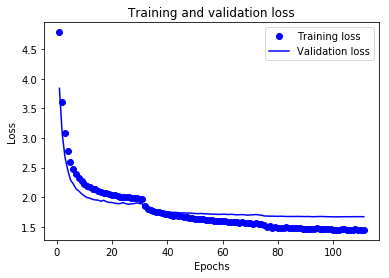

In [260]:
plt.clf()
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

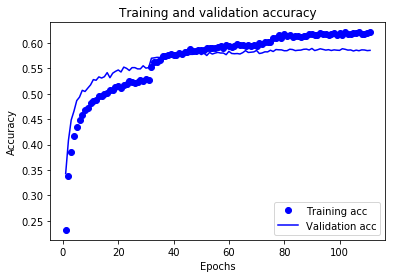

In [261]:
plt.clf()
acc = history2.history['acc']
val_acc = history2.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [262]:
results = model2.evaluate(x_test, one_hot_test_labels)
results

16147/16147 [==============================] - ETA: 4s - loss: 4.5935 - acc: 0.250 - ETA: 3s - loss: 2.4421 - acc: 0.385 - ETA: 3s - loss: 2.1921 - acc: 0.481 - ETA: 3s - loss: 2.0664 - acc: 0.519 - ETA: 3s - loss: 1.9124 - acc: 0.546 - ETA: 2s - loss: 1.9949 - acc: 0.524 - ETA: 2s - loss: 1.9206 - acc: 0.541 - ETA: 2s - loss: 1.8970 - acc: 0.544 - ETA: 2s - loss: 1.8607 - acc: 0.547 - ETA: 2s - loss: 1.8596 - acc: 0.541 - ETA: 2s - loss: 1.7176 - acc: 0.579 - ETA: 2s - loss: 1.6054 - acc: 0.609 - ETA: 2s - loss: 1.5119 - acc: 0.634 - ETA: 2s - loss: 1.4466 - acc: 0.651 - ETA: 2s - loss: 1.3797 - acc: 0.668 - ETA: 2s - loss: 1.3329 - acc: 0.681 - ETA: 2s - loss: 1.3719 - acc: 0.669 - ETA: 2s - loss: 1.3550 - acc: 0.668 - ETA: 2s - loss: 1.3248 - acc: 0.673 - ETA: 2s - loss: 1.2948 - acc: 0.682 - ETA: 2s - loss: 1.3026 - acc: 0.678 - ETA: 1s - loss: 1.3000 - acc: 0.684 - ETA: 1s - loss: 1.3236 - acc: 0.680 - ETA: 1s - loss: 1.3592 - acc: 0.670 - ETA: 1s - loss: 1.3581 - acc: 0.671 - ETA

[1.669876272408019, 0.5935468]

In [263]:
y_pred_one_hot = model2.predict(x_test)
y_pred = np.argmax(y_pred_one_hot, axis=1)
print(classification_report(y_test_idx, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.29      0.33        78
           1       0.40      0.47      0.43       182
           2       0.23      0.11      0.15        73
           3       0.81      0.68      0.74        19
           4       0.50      0.32      0.39        22
           5       0.60      0.36      0.45        25
           6       0.40      0.40      0.40        15
           7       0.55      0.85      0.67       161
           8       0.61      0.70      0.65        33
           9       0.65      0.46      0.54        24
          10       0.50      0.05      0.08        22
          11       0.51      0.79      0.62        82
          12       0.33      0.17      0.23        23
          13       0.70      0.88      0.78        34
          14       0.47      0.25      0.33        55
          15       0.38      0.19      0.25        16
          16       0.67      0.53      0.59       109
          17       0.66    